# Stock Market Prediction Methods

The goal of the project is to use machine learning algorithms for stock market predictions.<br>
We are using stocks from Yahoo Finance for analysis.

In [1]:
#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

### Web Scrapping
#### The historical data of the stock market is extracted using web scrapping method on Yahoo finance website. 
#### Using this method the historical data of any stock can be extracted for analysis

In [2]:
# Web scrapper function for yahoo finance 

import re
from io import StringIO
from datetime import datetime, timedelta

import requests
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

class YahooFinanceHistory:
    timeout = 2
    crumb_link = 'https://finance.yahoo.com/quote/{0}/history?p={0}'
    crumble_regex = r'CrumbStore":{"crumb":"(.*?)"}'
    quote_link = 'https://query1.finance.yahoo.com/v7/finance/download/{quote}?period1={dfrom}&period2={dto}&interval=1d&events=history&crumb={crumb}'

    def __init__(self, symbol, days_back=7):
        self.symbol = symbol
        self.session = requests.Session()
        self.dt = timedelta(days=days_back)

    def get_crumb(self):
        response = self.session.get(self.crumb_link.format(self.symbol), timeout=self.timeout)
        response.raise_for_status()
        match = re.search(self.crumble_regex, response.text)
        if not match:
            raise ValueError('Could not get crumb from Yahoo Finance')
        else:
            self.crumb = match.group(1)

    def get_quote(self):
        if not hasattr(self, 'crumb') or len(self.session.cookies) == 0:
            self.get_crumb()
        now = datetime.now()
        dateto = int(now.timestamp())
        datefrom = int((now - self.dt).timestamp())
        url = self.quote_link.format(quote=self.symbol, dfrom=datefrom, dto=dateto, crumb=self.crumb)
        response = self.session.get(url)
        response.raise_for_status()
        return pd.read_csv(StringIO(response.text), parse_dates=['Date'])

#### Use function YahooFinanaceHistory('Ticker_Name', days_back = Number of days in history)

We are selecting Morgan Stanley (MS) stock for analysis

In [3]:
# Use YahooFinanaceHistory('Ticker_Name', days_back = Number of days in history)
ticker = 'MS'
df = YahooFinanceHistory(ticker, days_back=4000).get_quote()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2752,2020-03-05,43.509998,43.939999,42.139999,42.590000,42.590000,23950200
2753,2020-03-06,40.509998,42.240002,40.340000,41.840000,41.840000,30898400
2754,2020-03-09,36.849998,39.020000,36.849998,37.500000,37.500000,28177500
2755,2020-03-10,39.810001,39.990002,37.049999,39.500000,39.500000,27108300
2756,2020-03-11,38.230000,38.860001,36.443001,36.869999,36.869999,26793755


In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-03-30,22.740000,23.230000,21.799999,22.129999,18.628920,44639500
1,2009-03-31,22.700001,23.160000,21.670000,22.770000,19.167675,54515100
2,2009-04-01,22.190001,24.200001,22.010000,23.730000,19.975796,46279700
3,2009-04-02,24.950001,25.000000,22.950001,23.110001,19.453882,67785600
4,2009-04-03,22.600000,24.160000,22.070000,24.059999,20.253586,52638500


## Exploratory Data Analysis

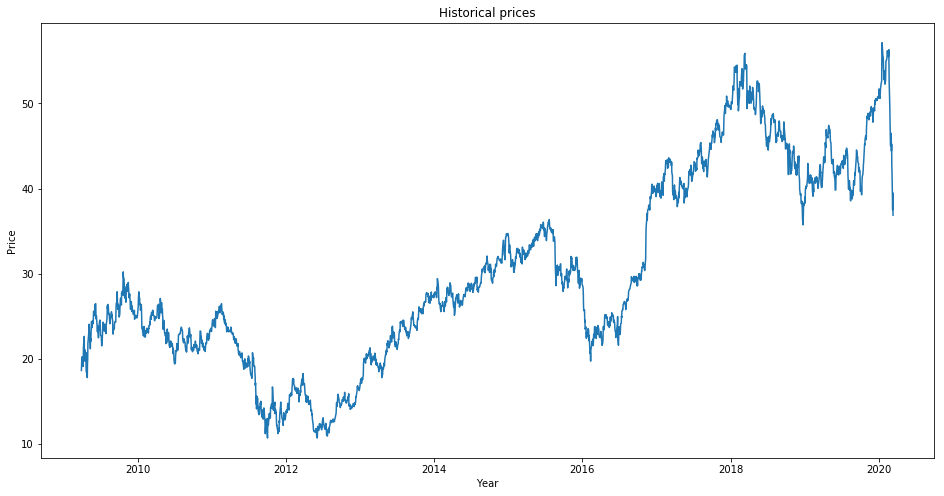

In [5]:
plt.figure(figsize=(16,8))
plt.title('Historical prices')
plt.xlabel('Year')
plt.ylabel('Price')
plt.plot(df['Date'], df['Adj Close'], label='Close Price history')
plt.show()

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-03-30,22.740000,23.230000,21.799999,22.129999,18.628920,44639500
1,2009-03-31,22.700001,23.160000,21.670000,22.770000,19.167675,54515100
2,2009-04-01,22.190001,24.200001,22.010000,23.730000,19.975796,46279700
3,2009-04-02,24.950001,25.000000,22.950001,23.110001,19.453882,67785600
4,2009-04-03,22.600000,24.160000,22.070000,24.059999,20.253586,52638500


In [7]:
df.shape

(2757, 7)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2757 entries, 0 to 2756
Data columns (total 7 columns):
Date         2757 non-null datetime64[ns]
Open         2757 non-null float64
High         2757 non-null float64
Low          2757 non-null float64
Close        2757 non-null float64
Adj Close    2757 non-null float64
Volume       2757 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 150.8 KB


In [9]:
df.isna().values.any()

False

### Data Preprocessing

In [10]:
#sorting
data = df.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Adj Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Adj Close'][i] = data['Adj Close'][i]

data = data[['Date','Adj Close']]

Set up for train and test data. 80% train and 20% train

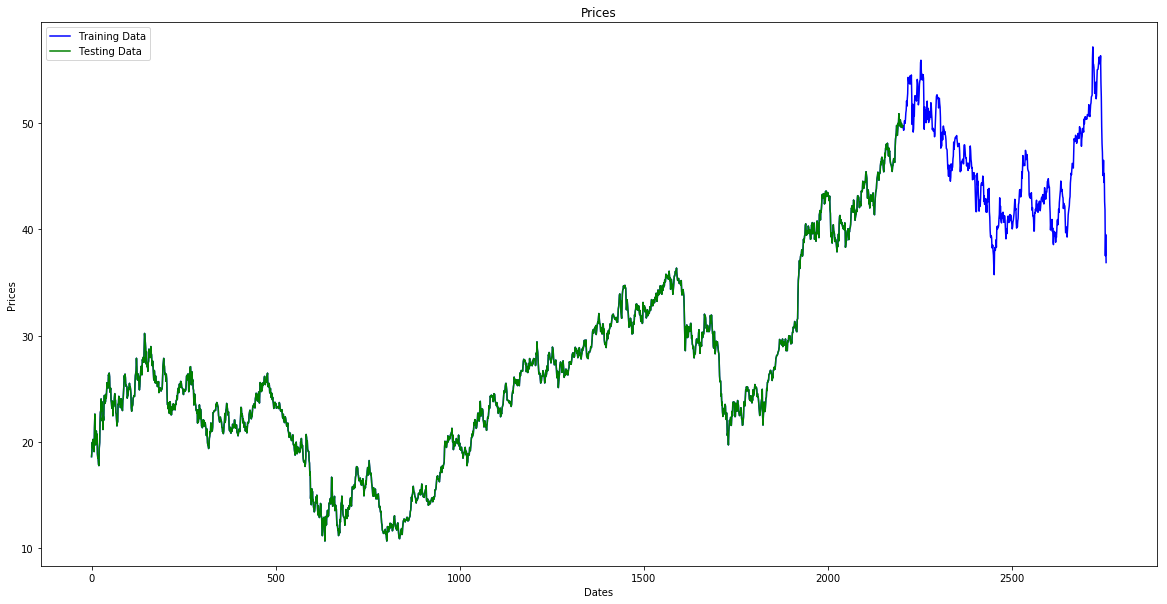

In [11]:
train, valid = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
plt.figure(figsize=(20,10))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data['Adj Close'], 'blue', label='Training Data')
plt.plot(train['Adj Close'], 'green', label='Testing Data')
plt.legend()
plt.show()

In [12]:
x_train = np.array(train.index).reshape(-1, 1)
y_train = pd.DataFrame(train['Adj Close'])
x_valid = valid.drop('Adj Close', axis=1)
y_valid = np.array(valid['Adj Close']).reshape(-1,1)

## Linear Regression

Our data contains only one **independent variable (X)** which represents the **date** and the **dependent variable (Y)** we are trying to predict is the Stock Price. To fit a line to the data points, which then represents an estimated relationship between **X and Y**, we can use a Simple Linear Regression.

**The best fit line can be described with**

 **Y = 𝛽0 + 𝛽1 X**


where

$Y$ is the predicted value of the dependent variable

$\beta_0$ is the y-intercept

$\beta_1$ is the slope

$X$ is the value of the independent variable

The goal is to find such coefficients $\beta_0$ and $\beta_1$ that the Sum of Squared Errors, which represents the difference between each point in the dataset with it’s corresponding predicted value outputted by the model, is minimal.

Training a Linear Regression Model

#### Implement linear regression

#### Make predictions and find the rmse

#### Evaluation of the model by plotting predictions along with train and test data

The above plot shows that the linear regression has performed poorly for price prediction

#### Statistical evaluation of the model

The above statistics show poor performance of the linear model

#### Practical evaluation of the model

Conclusion: The linear model performs poorly for linear regression

### k Nearest Neighbours algorithm

The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other. <br><br>The KNN algorithm hinges on this assumption being true enough for the algorithm to be useful. KNN captures the idea of similarity (sometimes called distance, proximity, or closeness) with some mathematics we might have learned in our childhood— calculating the distance between points on a graph. To select the K that’s right for your data, we run the KNN algorithm several times with different values of K and choose the K that reduces the number of errors we encounter while maintaining the algorithm’s ability to accurately make predictions when it’s given data it hasn’t seen before.
#### Advantages
The algorithm is simple and easy to implement<br>
There’s no need to build a model, tune several parameters, or make additional assumptions<br>
The algorithm is versatile. It can be used for classification, regression, and search
#### Disadvantage
The algorithm gets significantly slower as the number of examples and/or predictors/independent variables increase.<br>


#### Building model 

#### Statistical evaluation of the model

The statistical data is better than that of the linear model but not good enough for accurate predictions

#### Evaluation of the model by plotting predictions

The above plot shows the KNN model provides better results than linear model. The predictions nealy match the actual prices.

The predicted price is nearly equal to actual price, but we cannot rely on this model for trading.

### Support Vector Machines 

Support Vector Machine is used to find a Hyperplane in an N Dimensional Space (where N is the number of features) that distinctly classifies the data points.<br>
Hyperplanes are decision boundaries that help classify the data points. Data points falling on either side of the hyperplane can be attributed to different classes.<br>
This can help us in building hyperplanes around the data points to decide if the stock prices are undervalued or overvalued and help us deciding whether to buy or sell.

#### Data Preprocessing

#### Building linear, polynomial and RBF kernels for SVM

#### Evaluation of the model by plotting hyperplanes around the data points

The above plot shows that the RBF model is better model than linear or polynomial to determine that the prices are overvalued or undervalued

### Stock Market Prediction using ARIMA

#### The goal is to find the price of the stock tomorrow using ARIMA model and the historical data of the stock market.

ARIMA stands for Auto Regressive Integrated Moving Average

#### Auto Regressive
The model that takes advantages of the connection between a predefined number of lagged observations and current one
#### Integrated
Difference between raw observations
#### Moving Average
The model that takes advantage of the relationship between residual error and the observations

The ARIMA model make use of these three parameters
p = number of lag observations
d = the degree of differencing
q = the size of the moving average window

ARIMA can lead to good results if applied to short time predictions. 

#### Data Preprocessing

In [13]:
data = YahooFinanceHistory('MS', days_back=4000).get_quote()
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2752,2020-03-05,43.509998,43.939999,42.139999,42.590000,42.590000,23950200
2753,2020-03-06,40.509998,42.240002,40.340000,41.840000,41.840000,30898400
2754,2020-03-09,36.849998,39.020000,36.849998,37.500000,37.500000,28177500
2755,2020-03-10,39.810001,39.990002,37.049999,39.500000,39.500000,27108300
2756,2020-03-11,38.230000,38.860001,36.443001,36.869999,36.869999,26793755


In [14]:
# Set datetime index for the stock data
data.set_index('Date', inplace = True)

In [15]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-03-30,22.740000,23.230000,21.799999,22.129999,18.628920,44639500
2009-03-31,22.700001,23.160000,21.670000,22.770000,19.167675,54515100
2009-04-01,22.190001,24.200001,22.010000,23.730000,19.975796,46279700
2009-04-02,24.950001,25.000000,22.950001,23.110001,19.453882,67785600
2009-04-03,22.600000,24.160000,22.070000,24.059999,20.253586,52638500


#### Plot the training and test dataset for the selected stock
We will examine the adjusted close value as the end of day close price of the stock for analysis

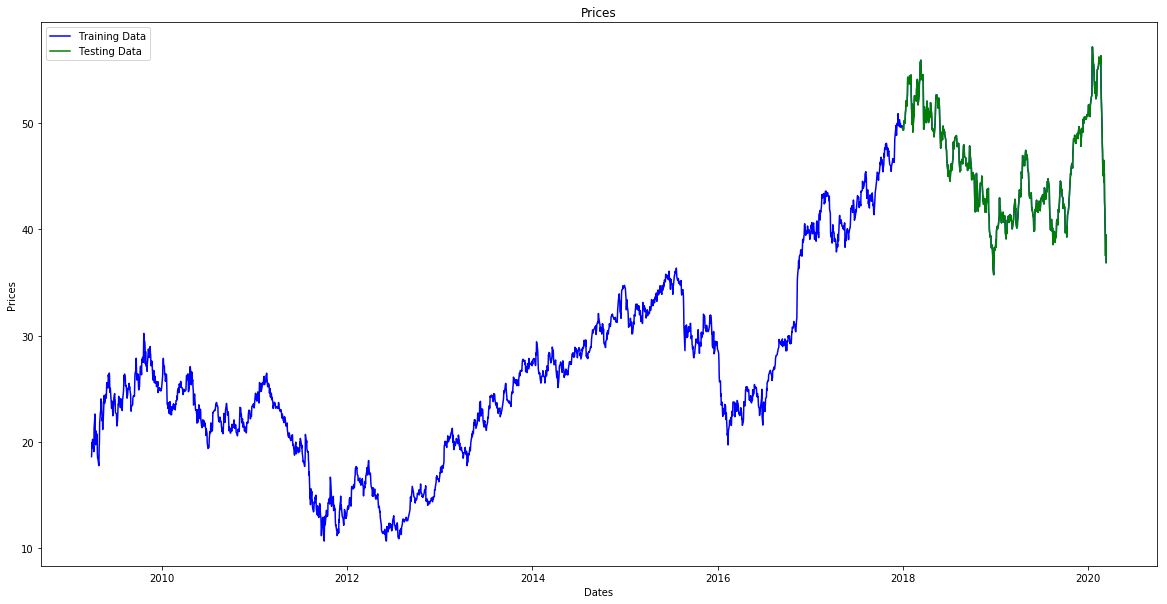

In [16]:
import matplotlib.pyplot as plt
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
plt.figure(figsize=(20,10))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(data['Adj Close'], 'blue', label='Training Data')
plt.plot(test_data['Adj Close'], 'green', label='Testing Data')
plt.legend()
plt.show()

Text(0.5,1,'Autocorrelation plot')

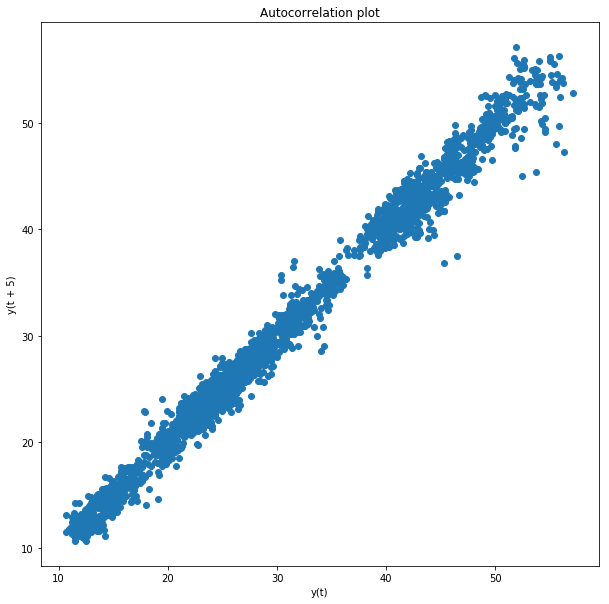

In [17]:
from pandas.plotting import lag_plot
plt.figure(figsize=(10,10))
lag_plot(data['Adj Close'], lag=5)
plt.title('Autocorrelation plot')

The results shown from the above plot show that ARIMA would be good model to be applied to this type of data

For model evaluation, we decide to use the Mean Squared Error(MSE) and Symmetric Mean Absolute Percentage Error.

Symmetric mean absolute percentage error (SMAPE or sMAPE) is an accuracy measure based on percentage (or relative) errors.

In [18]:
#Symmetric mean absolute percentage error used for relative errors
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [19]:
test_data = test_data.dropna()
train_data = train_data.dropna()

In [20]:
train_start_date = train_data.head(1).index[0].strftime("%Y-%m-%d")
train_end_date = train_data.tail(1).index[0].strftime("%Y-%m-%d")
test_start_date = test_data.head(1).index[0].strftime("%Y-%m-%d")
test_end_date = test_data.tail(1).index[0].strftime("%Y-%m-%d")
print(train_start_date)
print(train_end_date)
print(test_start_date)
print(test_end_date)


2009-03-30
2017-12-28
2017-12-29
2020-03-11


### Build ARIMA model using parameters:
Number of lag operations      (p) = 5 <br>
Degree of differencing        (d) = 1 <br>
Size of moving average window (q) = 0

In [21]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

Testing Mean Squared Error: 0.656
Symmetric mean absolute percentage error: 11.637


### Plot train, actual and predicted data to examine the efficiency of the model
It can be observed from the below plot that the predicted results are close to the actual data

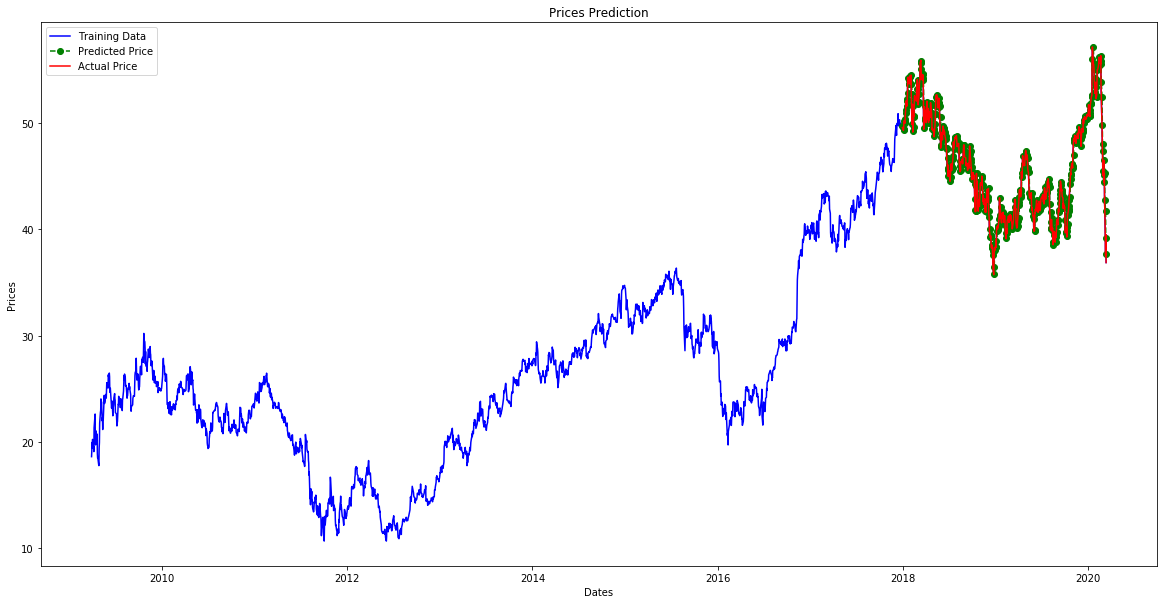

In [22]:
plt.figure(figsize=(20,10))
plt.plot(data['Adj Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Adj Close'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

Create a dataframe to compare the actual and predicted data

In [23]:
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
predict.tail()

,0
Date,
2020-03-05,45.240996
2020-03-06,42.731861
2020-03-09,41.720179
2020-03-10,37.667127
2020-03-11,39.206460


#### Practical evaluation of the model

In [24]:
today_actual = data['Adj Close'].loc[test_end_date]
today_predicted = predict[0].loc[test_end_date]
print(today_actual, today_predicted)

36.869999 39.2064604033635


It can be obseved that the predicted and actual prices are almost the same.

### Actual and Predicted Comparison
We have build a model that predicts the value using lagged observation and moving averages. This means the predicted value is what the value should be as per the trained model and if the actual value is slightly offset that mean that next value is tend to converge towards the predicted value.<br>
We have tried to build a program that recommends when to buy, sell or hold stocks depending on these observations

In [25]:
data['Prediction'] = round(predict[0],2)
data['Adj Close'] = round(data['Adj Close'],2)

In [26]:
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()

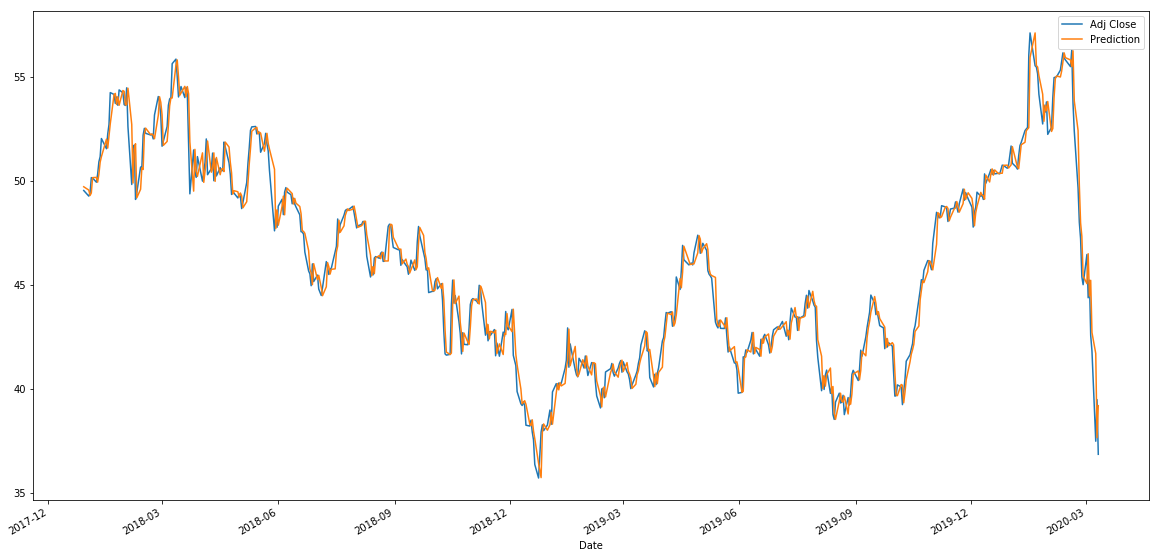

In [27]:
S1 = pd.Series(data['Adj Close'])
S2 = pd.Series(data['Prediction'])
pd.concat([S1,S2],axis=1).plot(figsize=(20,10))
plt.show()

#### Cointegration test for actual and predicted time series
Cointegration means the ratio between two series will vary around the mean.
Lets test the cointegration of the actual and predicted time series. If they are highly cointegrated, that means the ratio over time must converge to the mean.

In [28]:
from statsmodels.tsa.stattools import coint
score, pvalue, _ = coint(data['Adj Close'], data['Prediction'])
print('P Value', pvalue)

P Value 2.0648471663491524e-26


In [29]:
data['Adj Close'].corr(data['Prediction'])

0.9851918933540833

The above observations show the time series are highly cointegrated and correlated. This means when the time series drift towards or apart from each other, there will be times when the spread is high and times when spread is low.<br> 
Considering the actual time series should converge towards predicted, we buy stocks when predicted price is higher than actual since prices are supposed to rise. Similarly, we sell when actual price is lower than predited since prices are suppose to fall.

The ratio of the two time series show when the actual price of the stock is underpriced or overpriced. This way we buy the underpriced stocks and sell the overpriced ones. For convinience, we define z score of the ratios to recommend, when to trade.

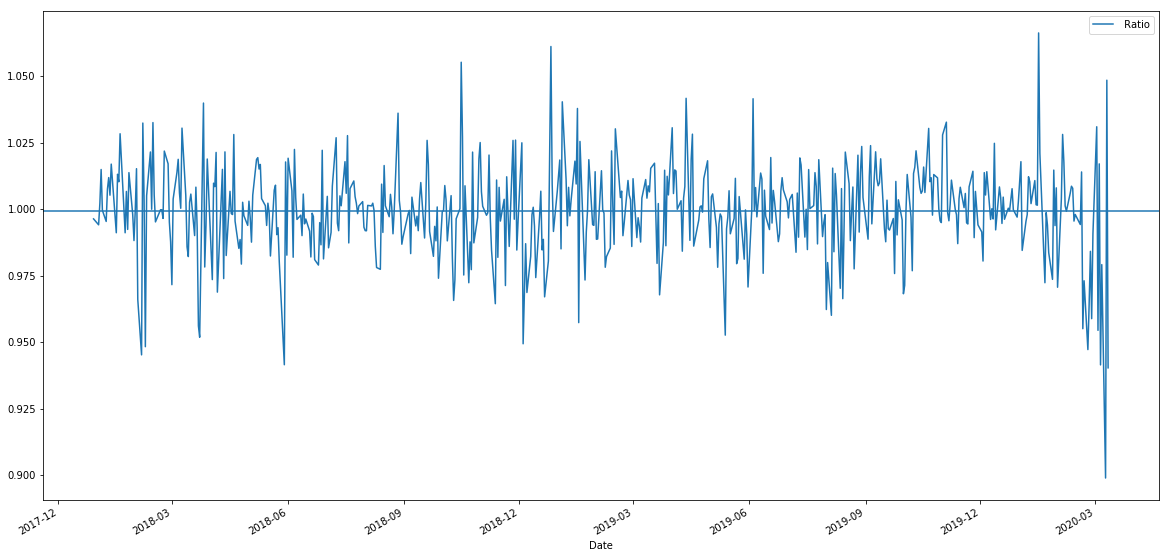

In [30]:
plt.figure(figsize=(20,10))

actual = data['Adj Close']
predicted = data['Prediction']
# score, pvalue, _ = coint(S1, S2)
# print(pvalue)
ratios = actual / predicted
ratios.plot()
plt.axhline(ratios.mean())
plt.legend([' Ratio'])
plt.show()

### Z Score
A Z-score is a numerical measurement used in statistics of a value's relationship to the mean (average) of a group of values, measured in terms of standard deviations from the mean. If a Z-score is 0, it indicates that the data point's score is identical to the mean score.

In [31]:
def zscore(series) :
    return (series - series.mean())/np.std(series)

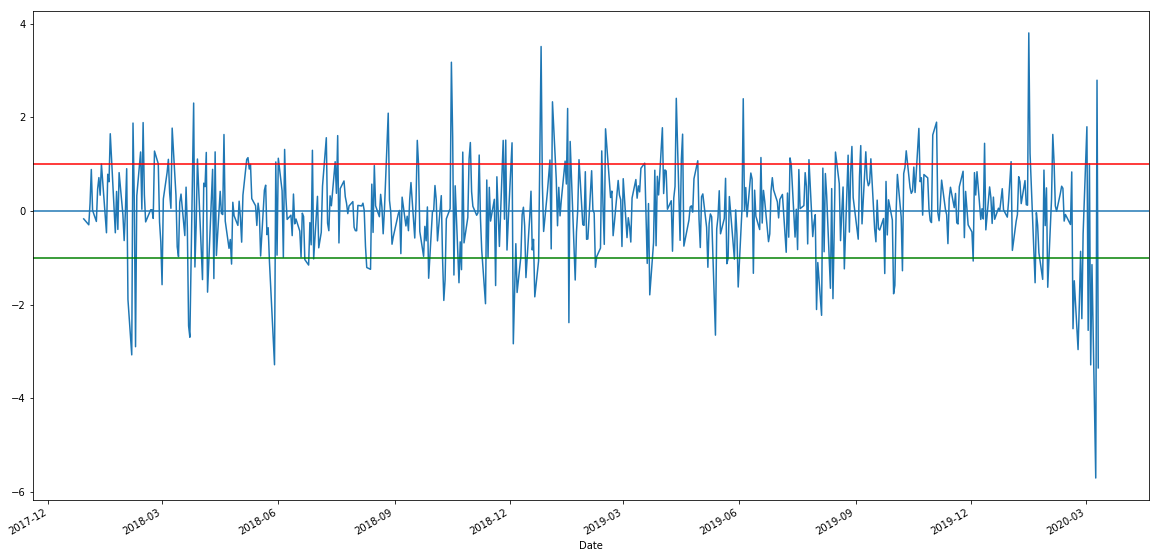

In [32]:
plt.figure(figsize=(20,10))

zscore(ratios).plot()
plt.axhline(zscore(ratios).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [33]:
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

In [34]:
testZScores.head()

,Z Score,Adj Close,Prediction
Date,,,
2017-12-29,-0.167741,49.56,49.74
2018-01-02,-0.294256,49.29,49.58
2018-01-03,0.164052,49.43,49.32
2018-01-04,0.886577,50.18,49.44
2018-01-05,0.014928,50.16,50.18


### When to Buy, Sell or Hold
Buy when stock is underpriced testZScores['Z Score'] <=-1.00 <br>
Sell when stock is overpriced testZScores['Z Score'] >= 1.00 <br>
Hold otherwise (testZScores['Z Score'] <  1.00) & (testZScores['Z Score'] > -1.00)

In [35]:
zthreshold = 0.2

In [36]:
testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                'Buy ',
                                 np.where(testZScores['Z Score']>=zthreshold, 
                                          'Sell',
                                          np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                   'Hold',
                                                   'Invalid')))

In [37]:
actions = testZScores[['Adj Close', 'Action']]
actions.head()

,Adj Close,Action
Date,,
2017-12-29,49.56,Hold
2018-01-02,49.29,Buy
2018-01-03,49.43,Hold
2018-01-04,50.18,Sell
2018-01-05,50.16,Hold


In [38]:
#Buy and Sell Functions
def buy(money, current_price):
    no_of_shares = money//current_price
    investment = (current_price*no_of_shares)
    money = money - investment
    # print(money, no_of_shares, investment)
    return money, investment, no_of_shares, current_price

def sell(money, current_price, no_of_shares):
    investment = (current_price*no_of_shares)
    money = money + investment
    no_of_shares = 0
    # print(money, no_of_shares, investment)
    return money, investment, no_of_shares

### Trading Simulation
Let us simulate the trading using $1000 as the initial amount

In [39]:
#Trading Simulation  

money = 1000
total_investment = 0
no_of_shares = 0
isInvested = 0
current_investment = 0

print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

i_money, i_current_investment, i_no_of_shares, i_buy_price = buy(money, actions['Adj Close'][0])

for i in range(len(actions)):
    if actions['Action'][i] == 'Buy ' and isInvested == 0:
        print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
        if money>=actions['Adj Close'][i]:
            money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
            total_investment = total_investment + current_investment
            isInvested = 1            
    elif actions['Action'][i] == 'Sell':
        print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
        if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
            money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
            total_investment = 0
            isInvested = 0    
    else:
        print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
print()
print('The above recommendation log shows that $1000 invested on ', test_start_date, ' gives us ', round(money + (round(no_of_shares*actions['Adj Close'][i],2)),2), 'as returns' )
print('We bought ', i_no_of_shares, ' shares at prices of $', i_buy_price, ' with remaining amount as ', round(i_money,2))
print('If we had gone for long term investment plan and checked the profits today, the return would have been ', round(i_money + (i_no_of_shares*actions['Adj Close'][len(actions)-1]),2))
print('Trading recommendation algorithm performance is ',round(((round(money + (round(no_of_shares*actions['Adj Close'][i],2)),2)) - ((round(i_money + (i_no_of_shares*actions['Adj Close'][len(actions)-1]),2)))) / (round(money + (round(no_of_shares*actions['Adj Close'][i],2)),2))*100,2) , '%')

Date                 Action  Money  Current  Price
2017-12-29 00:00:00   Hold   1000   0.0   49.56
2018-01-02 00:00:00   Buy    1000   0.0   49.29
2018-01-03 00:00:00   Hold   14.2   988.6   49.43
2018-01-04 00:00:00   Sell   14.2   1003.6   50.18
2018-01-05 00:00:00   Hold   1017.8   0.0   50.16
2018-01-08 00:00:00   Buy    1017.8   0.0   49.96
2018-01-09 00:00:00   Sell   18.6   1006.8   50.34
2018-01-10 00:00:00   Sell   1025.4   0.0   50.94
2018-01-11 00:00:00   Sell   1025.4   0.0   51.19
2018-01-12 00:00:00   Sell   1025.4   0.0   52.06
2018-01-16 00:00:00   Buy    1025.4   0.0   51.57
2018-01-17 00:00:00   Sell   45.57   993.32   52.28
2018-01-18 00:00:00   Sell   1038.89   0.0   52.74
2018-01-19 00:00:00   Sell   1038.89   0.0   54.27
2018-01-22 00:00:00   Hold   1038.89   0.0   54.18
2018-01-23 00:00:00   Buy    1038.89   0.0   53.75
2018-01-24 00:00:00   Sell   17.64   1027.14   54.06
2018-01-25 00:00:00   Buy    1044.78   0.0   53.66
2018-01-26 00:00:00   Sell   25.24   1033

2018-09-10 00:00:00   Buy    42.48   873.43   45.97
2018-09-11 00:00:00   Hold   42.48   871.91   45.89
2018-09-12 00:00:00   Buy    42.48   865.07   45.53
2018-09-13 00:00:00   Sell   42.48   869.44   45.76
2018-09-14 00:00:00   Sell   42.48   877.99   46.21
2018-09-17 00:00:00   Buy    42.48   868.68   45.72
2018-09-18 00:00:00   Hold   42.48   871.72   45.88
2018-09-19 00:00:00   Sell   42.48   894.52   47.08
2018-09-20 00:00:00   Sell   42.48   908.77   47.83
2018-09-21 00:00:00   Buy    42.48   900.22   47.38
2018-09-24 00:00:00   Buy    42.48   884.64   46.56
2018-09-25 00:00:00   Buy    42.48   879.51   46.29
2018-09-26 00:00:00   Buy    42.48   869.06   45.74
2018-09-27 00:00:00   Hold   42.48   870.2   45.8
2018-09-28 00:00:00   Buy    42.48   848.35   44.65
2018-10-01 00:00:00   Hold   42.48   849.49   44.71
2018-10-02 00:00:00   Hold   42.48   849.49   44.71
2018-10-03 00:00:00   Sell   42.48   858.23   45.17
2018-10-04 00:00:00   Sell   42.48   861.08   45.32
2018-10-05 00:

2019-08-14 00:00:00   Buy    42.48   736.82   38.78
2019-08-15 00:00:00   Buy    42.48   732.45   38.55
2019-08-16 00:00:00   Sell   42.48   748.22   39.38
2019-08-19 00:00:00   Sell   42.48   756.39   39.81
2019-08-20 00:00:00   Buy    42.48   747.46   39.34
2019-08-21 00:00:00   Hold   42.48   748.22   39.38
2019-08-22 00:00:00   Sell   42.48   754.49   39.71
2019-08-23 00:00:00   Buy    42.48   736.82   38.78
2019-08-26 00:00:00   Sell   42.48   752.4   39.6
2019-08-27 00:00:00   Buy    42.48   745.56   39.24
2019-08-28 00:00:00   Sell   42.48   756.58   39.82
2019-08-29 00:00:00   Sell   42.48   773.49   40.71
2019-08-30 00:00:00   Sell   42.48   777.29   40.91
2019-09-03 00:00:00   Buy    42.48   767.98   40.42
2019-09-04 00:00:00   Sell   42.48   778.05   40.95
2019-09-05 00:00:00   Sell   42.48   795.72   41.88
2019-09-06 00:00:00   Buy    42.48   790.21   41.59
2019-09-09 00:00:00   Sell   42.48   807.69   42.51
2019-09-10 00:00:00   Sell   42.48   816.43   42.97
2019-09-11 00:

The above recommendation log shows that \\$1000 invested on 2017-09-22 gives us \\$1151.02 as returns<br>
We bought 22 shares at price of \\$45.17 with remaining amount as \\$6.37<br>
If we had gone for a long term plan and removed the money at \\$49.48, the return would have been \\$1094.93<br>
This mean we have upped the profit by 50% and we can say our trading recommendation algorithm performed 50% better than the market

We can further improve the recommendations by using the optimal value of zthreshold. This can be found by find zthreshold that generates maximum returns in the investments

In [40]:
portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+(no_of_shares*actions['Adj Close'][i]),2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))

    

In [41]:
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
38,1063.93,1.90


The above results show that the algorithm will generate maximum profits at zthreshold = 1.25 and 1.30

In [42]:
#start_actual = data['Adj Close'].loc['2017-09-22']
start_actual = data['Adj Close'].loc[test_start_date]
start_predict = data['Prediction'].loc[test_start_date]
today_actual = data['Adj Close'].loc[test_end_date]
today_predicted = data['Prediction'].loc[test_end_date]
print('Price on ', test_start_date, ' : ', start_actual, 'Price on ', test_end_date, ': ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
returns = returns[returns['zthreshold']==returns['zthreshold'].min()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', round(((long_term_returns - 1000)/1000)*100,2),'%')
print('Percent return using trading algorithm: ', round(((trading_return - 1000)/1000)*100,2), '%')
print()
print('A return on investment of $',trading_return, ' is more than what we get by long term investment')
print('Also the portfolio percent value changed by ', round(((trading_return - 1000)/1000)*100,2), '%')
print('While the change in stock value over 3 years of long term investment is ', round(((long_term_returns - 1000)/1000)*100,2), '%')

Price on  2017-12-29  :  49.56 Price on  2020-03-11 :  36.87
Long term returns:  746.2
Returns using algorithm:  1063.93
Percent return on long term investment:  -25.38 %
Percent return using trading algorithm:  6.39 %

A return on investment of $ 1063.93  is more than what we get by long term investment
Also the portfolio percent value changed by  6.39 %
While the change in stock value over 3 years of long term investment is  -25.38 %


### Trading simulation results for different stocks

We will now try to simulate trading for different kind of stocks

#### Trading Apple Inc.(AAPL) 

In [43]:
data = YahooFinanceHistory('AAPL', days_back=4000).get_quote()
data.set_index('Date', inplace = True)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
# print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
data['Prediction'] = predict[0]
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()
plt.figure(figsize=(20,10))
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
            print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
            print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
        else:
            print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+(no_of_shares*actions['Adj Close'][i]),2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))
portfolios[portfolios['returns']==portfolios['returns'].max()]

2017-12-29 00:00:00   Buy    1000   0.0   163.87
2018-01-02 00:00:00   Buy    16.78   1000.82   166.8
2018-01-03 00:00:00   Sell   16.78   1000.65   166.77
2018-01-04 00:00:00   Sell   1017.43   0.0   167.55
2018-01-05 00:00:00   Sell   1017.43   0.0   169.46
2018-01-08 00:00:00   Buy    1017.43   0.0   168.83
2018-01-09 00:00:00   Sell   4.46   1012.85   168.81
2018-01-10 00:00:00   Sell   4.46   1012.62   168.77
2018-01-11 00:00:00   Sell   4.46   1018.37   169.73
2018-01-12 00:00:00   Sell   1022.83   0.0   171.48
2018-01-16 00:00:00   Buy    1022.83   0.0   170.61
2018-01-17 00:00:00   Sell   169.79   867.14   173.43
2018-01-18 00:00:00   Sell   1036.92   0.0   173.58
2018-01-19 00:00:00   Sell   1036.92   0.0   172.81
2018-01-22 00:00:00   Sell   1036.92   0.0   171.39
2018-01-23 00:00:00   Buy    1036.92   0.0   171.43
2018-01-24 00:00:00   Sell   8.33   1012.21   168.7
2018-01-25 00:00:00   Buy    8.33   994.14   165.69
2018-01-26 00:00:00   Sell   8.33   996.47   166.08
2018-01

2018-09-20 00:00:00   Sell   1245.19   0.0   215.51
2018-09-21 00:00:00   Buy    1245.19   0.0   213.19
2018-09-24 00:00:00   Buy    179.26   1081.26   216.25
2018-09-25 00:00:00   Buy    179.26   1088.12   217.62
2018-09-26 00:00:00   Buy    179.26   1079.45   215.89
2018-09-27 00:00:00   Sell   179.26   1101.63   220.33
2018-09-28 00:00:00   Buy    1280.89   0.0   221.1
2018-10-01 00:00:00   Buy    175.39   1112.95   222.59
2018-10-02 00:00:00   Sell   175.39   1122.84   224.57
2018-10-03 00:00:00   Sell   1298.23   0.0   227.3
2018-10-04 00:00:00   Sell   1298.23   0.0   223.3
2018-10-05 00:00:00   Buy    1298.23   0.0   219.68
2018-10-08 00:00:00   Sell   199.83   1095.85   219.17
2018-10-09 00:00:00   Buy    199.83   1111.04   222.21
2018-10-10 00:00:00   Buy    199.83   1059.57   211.91
2018-10-11 00:00:00   Buy    199.83   1050.21   210.04
2018-10-12 00:00:00   Buy    199.83   1087.73   217.55
2018-10-15 00:00:00   Sell   199.83   1064.46   212.89
2018-10-16 00:00:00   Sell   19

2019-07-19 00:00:00   Sell   199.83   1003.71   200.74
2019-07-22 00:00:00   Sell   199.83   1026.65   205.33
2019-07-23 00:00:00   Sell   199.83   1034.68   206.94
2019-07-24 00:00:00   Sell   199.83   1033.84   206.77
2019-07-25 00:00:00   Buy    199.83   1025.66   205.13
2019-07-26 00:00:00   Sell   199.83   1029.23   205.85
2019-07-29 00:00:00   Buy    199.83   1038.84   207.77
2019-07-30 00:00:00   Buy    199.83   1034.38   206.88
2019-07-31 00:00:00   Buy    199.83   1055.49   211.1
2019-08-01 00:00:00   Buy    199.83   1032.65   206.53
2019-08-02 00:00:00   Buy    199.83   1010.8   202.16
2019-08-05 00:00:00   Buy    199.83   957.88   191.58
2019-08-06 00:00:00   Sell   199.83   976.02   195.2
2019-08-07 00:00:00   Buy    199.83   986.13   197.23
2019-08-08 00:00:00   Sell   199.83   1007.87   201.57
2019-08-09 00:00:00   Sell   199.83   999.57   199.91
2019-08-12 00:00:00   Buy    199.83   997.03   199.41
2019-08-13 00:00:00   Sell   199.83   1039.26   207.85
2019-08-14 00:00:0

2018-06-28 00:00:00   Sell   177.31   905.26   181.05
2018-06-29 00:00:00   Buy    177.31   903.36   180.67
2018-07-02 00:00:00   Sell   177.31   913.46   182.69
2018-07-03 00:00:00   Buy    177.31   897.55   179.51
2018-07-05 00:00:00   Buy    177.31   904.77   180.95
2018-07-06 00:00:00   Sell   177.31   917.32   183.46
2018-07-09 00:00:00   Sell   177.31   930.05   186.01
2018-07-10 00:00:00   Buy    177.31   928.93   185.79
2018-07-11 00:00:00   Buy    177.31   916.88   183.38
2018-07-12 00:00:00   Sell   177.31   932.25   186.45
2018-07-13 00:00:00   Sell   177.31   933.71   186.74
2018-07-16 00:00:00   Sell   177.31   931.66   186.33
2018-07-17 00:00:00   Sell   177.31   934.3   186.86
2018-07-18 00:00:00   Sell   177.31   929.18   185.84
2018-07-19 00:00:00   Buy    177.31   936.4   187.28
2018-07-20 00:00:00   Sell   177.31   934.25   186.85
2018-07-23 00:00:00   Sell   177.31   935.08   187.02
2018-07-24 00:00:00   Sell   177.31   941.86   188.37
2018-07-25 00:00:00   Sell   1

2019-08-06 00:00:00   Sell   198.31   976.02   195.2
2019-08-07 00:00:00   Buy    198.31   986.13   197.23
2019-08-08 00:00:00   Sell   198.31   1007.87   201.57
2019-08-09 00:00:00   Sell   198.31   999.57   199.91
2019-08-12 00:00:00   Buy    198.31   997.03   199.41
2019-08-13 00:00:00   Sell   198.31   1039.26   207.85
2019-08-14 00:00:00   Buy    198.31   1008.32   201.66
2019-08-15 00:00:00   Buy    198.31   1003.3   200.66
2019-08-16 00:00:00   Sell   198.31   1026.97   205.39
2019-08-19 00:00:00   Sell   198.31   1046.12   209.22
2019-08-20 00:00:00   Buy    198.31   1046.17   209.23
2019-08-21 00:00:00   Hold   198.31   1057.51   211.5
2019-08-22 00:00:00   Sell   198.31   1056.61   211.32
2019-08-23 00:00:00   Buy    198.31   1007.78   201.56
2019-08-26 00:00:00   Sell   198.31   1026.92   205.38
2019-08-27 00:00:00   Buy    198.31   1015.33   203.07
2019-08-28 00:00:00   Sell   198.31   1022.15   204.43
2019-08-29 00:00:00   Sell   198.31   1039.45   207.89
2019-08-30 00:00:

2018-07-17 00:00:00   Sell   177.31   934.3   186.86
2018-07-18 00:00:00   Sell   177.31   929.18   185.84
2018-07-19 00:00:00   Buy    177.31   936.4   187.28
2018-07-20 00:00:00   Sell   177.31   934.25   186.85
2018-07-23 00:00:00   Sell   177.31   935.08   187.02
2018-07-24 00:00:00   Sell   177.31   941.86   188.37
2018-07-25 00:00:00   Sell   1119.18   0.0   190.15
2018-07-26 00:00:00   Hold   1119.18   0.0   189.55
2018-07-27 00:00:00   Sell   1119.18   0.0   186.4
2018-07-30 00:00:00   Sell   1119.18   0.0   185.36
2018-07-31 00:00:00   Buy    1119.18   0.0   185.73
2018-08-01 00:00:00   Buy    4.81   1180.01   196.67
2018-08-02 00:00:00   Buy    4.81   1214.51   202.42
2018-08-03 00:00:00   Sell   4.81   1218.02   203.0
2018-08-06 00:00:00   Sell   1222.83   0.0   204.06
2018-08-07 00:00:00   Sell   1222.83   0.0   202.14
2018-08-08 00:00:00   Hold   1222.83   0.0   202.28
2018-08-09 00:00:00   Buy    1222.83   0.0   203.87
2018-08-10 00:00:00   Buy    203.47   1016.32   203.2

2019-03-15 00:00:00   Sell   18.9   1102.29   183.72
2019-03-18 00:00:00   Sell   18.9   1113.54   185.59
2019-03-19 00:00:00   Hold   18.9   1104.72   184.12
2019-03-20 00:00:00   Buy    18.9   1114.37   185.73
2019-03-21 00:00:00   Sell   18.9   1155.42   192.57
2019-03-22 00:00:00   Buy    18.9   1131.49   188.58
2019-03-25 00:00:00   Buy    18.9   1117.81   186.3
2019-03-26 00:00:00   Sell   18.9   1106.26   184.38
2019-03-27 00:00:00   Buy    18.9   1116.21   186.03
2019-03-28 00:00:00   Sell   18.9   1117.69   186.28
2019-03-29 00:00:00   Sell   18.9   1124.98   187.5
2019-04-01 00:00:00   Sell   18.9   1132.62   188.77
2019-04-02 00:00:00   Sell   18.9   1149.08   191.51
2019-04-03 00:00:00   Sell   18.9   1156.96   192.83
2019-04-04 00:00:00   Sell   18.9   1158.97   193.16
2019-04-05 00:00:00   Hold   18.9   1166.73   194.45
2019-04-08 00:00:00   Sell   18.9   1185.09   197.51
2019-04-09 00:00:00   Buy    18.9   1181.53   196.92
2019-04-10 00:00:00   Sell   18.9   1188.17   19

2019-11-11 00:00:00   Hold   1508.61   0.0   261.58
2019-11-12 00:00:00   Hold   1508.61   0.0   261.34
2019-11-13 00:00:00   Buy    1508.61   0.0   263.84
2019-11-14 00:00:00   Sell   189.39   1310.09   262.02
2019-11-15 00:00:00   Sell   189.39   1325.65   265.13
2019-11-18 00:00:00   Hold   1515.05   0.0   266.47
2019-11-19 00:00:00   Sell   1515.05   0.0   265.66
2019-11-20 00:00:00   Buy    1515.05   0.0   262.57
2019-11-21 00:00:00   Buy    202.21   1306.95   261.39
2019-11-22 00:00:00   Sell   202.21   1305.8   261.16
2019-11-25 00:00:00   Sell   202.21   1328.7   265.74
2019-11-26 00:00:00   Buy    1530.91   0.0   263.66
2019-11-27 00:00:00   Sell   212.59   1336.03   267.21
2019-11-29 00:00:00   Buy    1548.62   0.0   266.62
2019-12-02 00:00:00   Buy    215.53   1317.67   263.53
2019-12-03 00:00:00   Buy    215.53   1294.18   258.84
2019-12-04 00:00:00   Sell   215.53   1305.6   261.12
2019-12-05 00:00:00   Sell   215.53   1324.76   264.95
2019-12-06 00:00:00   Sell   215.53  

2018-04-30 00:00:00   Buy    11.77   964.07   160.68
2018-05-01 00:00:00   Sell   11.77   986.47   164.41
2018-05-02 00:00:00   Hold   11.77   1030.05   171.67
2018-05-03 00:00:00   Buy    11.77   1031.91   171.99
2018-05-04 00:00:00   Sell   11.77   1072.4   178.73
2018-05-07 00:00:00   Sell   1084.17   0.0   180.03
2018-05-08 00:00:00   Sell   1084.17   0.0   180.89
2018-05-09 00:00:00   Sell   1084.17   0.0   182.17
2018-05-10 00:00:00   Sell   1084.17   0.0   184.77
2018-05-11 00:00:00   Sell   1084.17   0.0   184.07
2018-05-14 00:00:00   Hold   1084.17   0.0   183.64
2018-05-15 00:00:00   Buy    1084.17   0.0   181.97
2018-05-16 00:00:00   Sell   174.32   918.34   183.67
2018-05-17 00:00:00   Hold   1092.66   0.0   182.51
2018-05-18 00:00:00   Buy    1092.66   0.0   181.84
2018-05-21 00:00:00   Sell   1.6   1098.79   183.13
2018-05-22 00:00:00   Sell   1100.39   0.0   182.67
2018-05-23 00:00:00   Buy    1100.39   0.0   183.84
2018-05-24 00:00:00   Buy    181.17   918.19   183.64
2

2019-06-10 00:00:00   Sell   13.6   1144.94   190.82
2019-06-11 00:00:00   Sell   13.6   1158.2   193.03
2019-06-12 00:00:00   Buy    13.6   1154.52   192.42
2019-06-13 00:00:00   Sell   13.6   1154.28   192.38
2019-06-14 00:00:00   Hold   13.6   1145.89   190.98
2019-06-17 00:00:00   Buy    13.6   1152.73   192.12
2019-06-18 00:00:00   Sell   13.6   1179.84   196.64
2019-06-19 00:00:00   Buy    13.6   1176.39   196.07
2019-06-20 00:00:00   Sell   13.6   1185.85   197.64
2019-06-21 00:00:00   Sell   13.6   1181.8   196.97
2019-06-24 00:00:00   Buy    13.6   1180.62   196.77
2019-06-25 00:00:00   Buy    13.6   1162.72   193.79
2019-06-26 00:00:00   Sell   13.6   1187.87   197.98
2019-06-27 00:00:00   Sell   13.6   1187.51   197.92
2019-06-28 00:00:00   Sell   13.6   1176.69   196.12
2019-07-01 00:00:00   Sell   13.6   1198.27   199.71
2019-07-02 00:00:00   Hold   13.6   1205.29   200.88
2019-07-03 00:00:00   Sell   13.6   1215.28   202.55
2019-07-05 00:00:00   Sell   13.6   1214.21   20

2018-05-07 00:00:00   Sell   1061.69   0.0   180.03
2018-05-08 00:00:00   Sell   1061.69   0.0   180.89
2018-05-09 00:00:00   Sell   1061.69   0.0   182.17
2018-05-10 00:00:00   Sell   1061.69   0.0   184.77
2018-05-11 00:00:00   Sell   1061.69   0.0   184.07
2018-05-14 00:00:00   Hold   1061.69   0.0   183.64
2018-05-15 00:00:00   Buy    1061.69   0.0   181.97
2018-05-16 00:00:00   Hold   151.84   918.34   183.67
2018-05-17 00:00:00   Hold   151.84   912.53   182.51
2018-05-18 00:00:00   Buy    151.84   909.22   181.84
2018-05-21 00:00:00   Sell   151.84   915.66   183.13
2018-05-22 00:00:00   Sell   1067.5   0.0   182.67
2018-05-23 00:00:00   Buy    1067.5   0.0   183.84
2018-05-24 00:00:00   Buy    148.28   918.19   183.64
2018-05-25 00:00:00   Buy    148.28   920.29   184.06
2018-05-29 00:00:00   Buy    148.28   916.97   183.39
2018-05-30 00:00:00   Sell   148.28   915.02   183.0
2018-05-31 00:00:00   Buy    148.28   911.95   182.39
2018-06-01 00:00:00   Sell   148.28   928.39   18

2019-01-03 00:00:00   Buy    190.42   698.77   139.75
2019-01-04 00:00:00   Sell   190.42   728.6   145.72
2019-01-07 00:00:00   Sell   190.42   726.98   145.4
2019-01-08 00:00:00   Buy    190.42   740.83   148.17
2019-01-09 00:00:00   Sell   190.42   753.41   150.68
2019-01-10 00:00:00   Hold   190.42   755.82   151.16
2019-01-11 00:00:00   Sell   190.42   748.4   149.68
2019-01-14 00:00:00   Sell   190.42   737.15   147.43
2019-01-15 00:00:00   Sell   190.42   752.24   150.45
2019-01-16 00:00:00   Sell   190.42   761.43   152.29
2019-01-17 00:00:00   Buy    190.42   765.95   153.19
2019-01-18 00:00:00   Sell   190.42   770.66   154.13
2019-01-22 00:00:00   Buy    190.42   753.37   150.67
2019-01-23 00:00:00   Buy    190.42   756.41   151.28
2019-01-24 00:00:00   Hold   190.42   750.42   150.08
2019-01-25 00:00:00   Sell   190.42   775.28   155.06
2019-01-28 00:00:00   Buy    190.42   768.11   153.62
2019-01-29 00:00:00   Buy    190.42   760.15   152.03
2019-01-30 00:00:00   Sell   19

2019-09-03 00:00:00   Buy    190.42   1022.99   204.6
2019-09-04 00:00:00   Sell   190.42   1040.35   208.07
2019-09-05 00:00:00   Sell   190.42   1060.69   212.14
2019-09-06 00:00:00   Buy    190.42   1060.59   212.12
2019-09-09 00:00:00   Sell   190.42   1065.12   213.02
2019-09-10 00:00:00   Sell   190.42   1077.7   215.54
2019-09-11 00:00:00   Sell   190.42   1111.96   222.39
2019-09-12 00:00:00   Sell   1302.39   0.0   221.9
2019-09-13 00:00:00   Sell   1302.39   0.0   217.58
2019-09-16 00:00:00   Buy    1302.39   0.0   218.72
2019-09-17 00:00:00   Buy    208.77   1097.59   219.52
2019-09-18 00:00:00   Sell   208.77   1107.89   221.58
2019-09-19 00:00:00   Buy    1316.66   0.0   219.78
2019-09-20 00:00:00   Buy    217.77   1082.82   216.56
2019-09-23 00:00:00   Hold   217.77   1087.74   217.55
2019-09-24 00:00:00   Buy    217.77   1082.57   216.51
2019-09-25 00:00:00   Sell   217.77   1099.23   219.85
2019-09-26 00:00:00   Buy    1317.01   0.0   218.71
2019-09-27 00:00:00   Sell  

2018-02-21 00:00:00   Hold   160.65   831.64   166.33
2018-02-22 00:00:00   Hold   160.65   838.59   167.72
2018-02-23 00:00:00   Sell   160.65   853.17   170.63
2018-02-26 00:00:00   Sell   160.65   870.04   174.01
2018-02-27 00:00:00   Hold   1030.69   0.0   173.44
2018-02-28 00:00:00   Buy    1030.69   0.0   173.18
2018-03-01 00:00:00   Buy    164.79   850.74   170.15
2018-03-02 00:00:00   Sell   164.79   856.62   171.32
2018-03-05 00:00:00   Sell   164.79   859.59   171.92
2018-03-06 00:00:00   Sell   164.79   858.86   171.77
2018-03-07 00:00:00   Sell   164.79   850.89   170.18
2018-03-08 00:00:00   Hold   164.79   860.17   172.03
2018-03-09 00:00:00   Sell   164.79   874.95   174.99
2018-03-12 00:00:00   Sell   1039.74   0.0   176.68
2018-03-13 00:00:00   Buy    1039.74   0.0   174.98
2018-03-14 00:00:00   Buy    164.83   867.46   173.49
2018-03-15 00:00:00   Hold   164.83   868.48   173.7
2018-03-16 00:00:00   Sell   164.83   865.42   173.08
2018-03-19 00:00:00   Buy    164.83  

2018-10-17 00:00:00   Sell   141.98   1083.22   216.64
2018-10-18 00:00:00   Buy    141.98   1057.9   211.58
2018-10-19 00:00:00   Sell   141.98   1074.01   214.8
2018-10-22 00:00:00   Buy    141.98   1080.58   216.12
2018-10-23 00:00:00   Buy    141.98   1090.76   218.15
2018-10-24 00:00:00   Buy    141.98   1053.35   210.67
2018-10-25 00:00:00   Sell   141.98   1076.41   215.28
2018-10-26 00:00:00   Buy    141.98   1059.27   211.85
2018-10-29 00:00:00   Hold   141.98   1039.39   207.88
2018-10-30 00:00:00   Sell   141.98   1044.58   208.92
2018-10-31 00:00:00   Sell   141.98   1071.81   214.36
2018-11-01 00:00:00   Sell   141.98   1088.26   217.65
2018-11-02 00:00:00   Hold   141.98   1016.08   203.22
2018-11-05 00:00:00   Hold   141.98   987.23   197.45
2018-11-06 00:00:00   Hold   141.98   997.91   199.58
2018-11-07 00:00:00   Sell   141.98   1028.17   205.63
2018-11-08 00:00:00   Hold   141.98   1024.59   204.92
2018-11-09 00:00:00   Buy    141.98   1004.83   200.97
2018-11-12 00:

2019-06-19 00:00:00   Buy    141.98   980.33   196.07
2019-06-20 00:00:00   Sell   141.98   988.21   197.64
2019-06-21 00:00:00   Hold   141.98   984.84   196.97
2019-06-24 00:00:00   Buy    141.98   983.85   196.77
2019-06-25 00:00:00   Buy    141.98   968.93   193.79
2019-06-26 00:00:00   Sell   141.98   989.89   197.98
2019-06-27 00:00:00   Sell   141.98   989.59   197.92
2019-06-28 00:00:00   Sell   141.98   980.58   196.12
2019-07-01 00:00:00   Hold   141.98   998.56   199.71
2019-07-02 00:00:00   Hold   141.98   1004.41   200.88
2019-07-03 00:00:00   Hold   141.98   1012.73   202.55
2019-07-05 00:00:00   Sell   141.98   1011.84   202.37
2019-07-08 00:00:00   Buy    141.98   990.98   198.2
2019-07-09 00:00:00   Sell   141.98   997.02   199.4
2019-07-10 00:00:00   Buy    141.98   1006.88   201.38
2019-07-11 00:00:00   Sell   141.98   999.55   199.91
2019-07-12 00:00:00   Sell   141.98   1007.23   201.45
2019-07-15 00:00:00   Buy    141.98   1016.69   203.34
2019-07-16 00:00:00   Ho

2020-02-14 00:00:00   Hold   1425.91   0.0   324.95
2020-02-18 00:00:00   Buy    1425.91   0.0   319.0
2020-02-19 00:00:00   Sell   149.91   1294.48   323.62
2020-02-20 00:00:00   Buy    1444.39   0.0   320.3
2020-02-21 00:00:00   Buy    163.19   1252.2   313.05
2020-02-24 00:00:00   Buy    163.19   1192.72   298.18
2020-02-25 00:00:00   Buy    163.19   1152.32   288.08
2020-02-26 00:00:00   Buy    163.19   1170.6   292.65
2020-02-27 00:00:00   Buy    163.19   1094.08   273.52
2020-02-28 00:00:00   Buy    163.19   1093.44   273.36
2020-03-02 00:00:00   Sell   163.19   1195.24   298.81
2020-03-03 00:00:00   Buy    163.19   1157.28   289.32
2020-03-04 00:00:00   Sell   163.19   1210.96   302.74
2020-03-05 00:00:00   Buy    163.19   1171.68   292.92
2020-03-06 00:00:00   Buy    163.19   1156.12   289.03
2020-03-09 00:00:00   Buy    163.19   1064.68   266.17
2020-03-10 00:00:00   Sell   163.19   1141.36   285.34
2020-03-11 00:00:00   Buy    163.19   1101.72   275.43
2017-12-29 00:00:00   H

2018-08-03 00:00:00   Hold   147.9   1015.02   203.0
2018-08-06 00:00:00   Hold   147.9   1020.29   204.06
2018-08-07 00:00:00   Hold   147.9   1010.72   202.14
2018-08-08 00:00:00   Hold   147.9   1011.41   202.28
2018-08-09 00:00:00   Buy    147.9   1019.36   203.87
2018-08-10 00:00:00   Buy    147.9   1016.32   203.26
2018-08-13 00:00:00   Buy    147.9   1022.89   204.58
2018-08-14 00:00:00   Sell   147.9   1027.2   205.44
2018-08-15 00:00:00   Buy    1175.1   0.0   205.92
2018-08-16 00:00:00   Sell   145.5   1044.68   208.94
2018-08-17 00:00:00   Hold   1190.18   0.0   213.11
2018-08-20 00:00:00   Hold   1190.18   0.0   211.03
2018-08-21 00:00:00   Sell   1190.18   0.0   210.62
2018-08-22 00:00:00   Hold   1190.18   0.0   210.63
2018-08-23 00:00:00   Buy    1190.18   0.0   211.06
2018-08-24 00:00:00   Hold   134.87   1058.59   211.72
2018-08-27 00:00:00   Sell   134.87   1067.3   213.46
2018-08-28 00:00:00   Hold   1202.18   0.0   215.18
2018-08-29 00:00:00   Hold   1202.18   0.0  

2019-04-04 00:00:00   Sell   138.25   965.81   193.16
2019-04-05 00:00:00   Hold   138.25   972.27   194.45
2019-04-08 00:00:00   Hold   138.25   987.57   197.51
2019-04-09 00:00:00   Buy    138.25   984.61   196.92
2019-04-10 00:00:00   Hold   138.25   990.14   198.03
2019-04-11 00:00:00   Sell   138.25   981.9   196.38
2019-04-12 00:00:00   Sell   138.25   981.5   196.3
2019-04-15 00:00:00   Buy    138.25   983.28   196.66
2019-04-16 00:00:00   Sell   138.25   983.38   196.68
2019-04-17 00:00:00   Sell   138.25   1002.53   200.51
2019-04-18 00:00:00   Buy    138.25   1006.13   201.23
2019-04-22 00:00:00   Hold   138.25   1009.44   201.89
2019-04-23 00:00:00   Hold   138.25   1024.0   204.8
2019-04-24 00:00:00   Hold   138.25   1022.42   204.48
2019-04-25 00:00:00   Hold   138.25   1013.14   202.63
2019-04-26 00:00:00   Sell   138.25   1008.3   201.66
2019-04-29 00:00:00   Sell   138.25   1009.83   201.97
2019-04-30 00:00:00   Hold   138.25   990.39   198.08
2019-05-01 00:00:00   Buy 

2019-11-29 00:00:00   Hold   1323.64   0.0   266.62
2019-12-02 00:00:00   Buy    1323.64   0.0   263.53
2019-12-03 00:00:00   Buy    5.97   1294.18   258.84
2019-12-04 00:00:00   Sell   5.97   1305.6   261.12
2019-12-05 00:00:00   Sell   5.97   1324.76   264.95
2019-12-06 00:00:00   Sell   1330.72   0.0   270.07
2019-12-09 00:00:00   Hold   1330.72   0.0   266.29
2019-12-10 00:00:00   Hold   1330.72   0.0   267.84
2019-12-11 00:00:00   Hold   1330.72   0.0   270.13
2019-12-12 00:00:00   Sell   1330.72   0.0   270.82
2019-12-13 00:00:00   Buy    1330.72   0.0   274.5
2019-12-16 00:00:00   Sell   232.73   1116.79   279.2
2019-12-17 00:00:00   Hold   1349.52   0.0   279.75
2019-12-18 00:00:00   Hold   1349.52   0.0   279.08
2019-12-19 00:00:00   Hold   1349.52   0.0   279.36
2019-12-20 00:00:00   Hold   1349.52   0.0   278.78
2019-12-23 00:00:00   Hold   1349.52   0.0   283.33
2019-12-24 00:00:00   Hold   1349.52   0.0   283.6
2019-12-26 00:00:00   Sell   1349.52   0.0   289.22
2019-12-27

2018-05-21 00:00:00   Sell   152.02   915.66   183.13
2018-05-22 00:00:00   Sell   1067.68   0.0   182.67
2018-05-23 00:00:00   Buy    1067.68   0.0   183.84
2018-05-24 00:00:00   Buy    148.46   918.19   183.64
2018-05-25 00:00:00   Buy    148.46   920.29   184.06
2018-05-29 00:00:00   Buy    148.46   916.97   183.39
2018-05-30 00:00:00   Sell   148.46   915.02   183.0
2018-05-31 00:00:00   Buy    148.46   911.95   182.39
2018-06-01 00:00:00   Sell   148.46   928.39   185.68
2018-06-04 00:00:00   Sell   1076.86   0.0   187.23
2018-06-05 00:00:00   Buy    1076.86   0.0   188.68
2018-06-06 00:00:00   Sell   133.48   946.65   189.33
2018-06-07 00:00:00   Hold   1080.12   0.0   188.82
2018-06-08 00:00:00   Hold   1080.12   0.0   187.1
2018-06-11 00:00:00   Hold   1080.12   0.0   186.65
2018-06-12 00:00:00   Buy    1080.12   0.0   187.67
2018-06-13 00:00:00   Sell   141.77   930.64   186.13
2018-06-14 00:00:00   Hold   141.77   931.13   186.23
2018-06-15 00:00:00   Hold   141.77   921.56  

2019-01-18 00:00:00   Sell   132.13   770.66   154.13
2019-01-22 00:00:00   Buy    132.13   753.37   150.67
2019-01-23 00:00:00   Buy    132.13   756.41   151.28
2019-01-24 00:00:00   Hold   132.13   750.42   150.08
2019-01-25 00:00:00   Sell   132.13   775.28   155.06
2019-01-28 00:00:00   Hold   132.13   768.11   153.62
2019-01-29 00:00:00   Hold   132.13   760.15   152.03
2019-01-30 00:00:00   Sell   132.13   812.09   162.42
2019-01-31 00:00:00   Buy    132.13   817.94   163.59
2019-02-01 00:00:00   Buy    132.13   818.33   163.67
2019-02-04 00:00:00   Sell   132.13   841.58   168.32
2019-02-05 00:00:00   Hold   132.13   855.98   171.2
2019-02-06 00:00:00   Hold   132.13   856.27   171.25
2019-02-07 00:00:00   Buy    132.13   840.05   168.01
2019-02-08 00:00:00   Buy    132.13   841.04   168.21
2019-02-11 00:00:00   Buy    132.13   836.2   167.24
2019-02-12 00:00:00   Sell   132.13   843.41   168.68
2019-02-13 00:00:00   Hold   132.13   839.91   167.98
2019-02-14 00:00:00   Buy    1

2019-09-17 00:00:00   Buy    150.48   1097.59   219.52
2019-09-18 00:00:00   Hold   150.48   1107.89   221.58
2019-09-19 00:00:00   Buy    150.48   1098.89   219.78
2019-09-20 00:00:00   Buy    150.48   1082.82   216.56
2019-09-23 00:00:00   Hold   150.48   1087.74   217.55
2019-09-24 00:00:00   Buy    150.48   1082.57   216.51
2019-09-25 00:00:00   Sell   150.48   1099.23   219.85
2019-09-26 00:00:00   Buy    1249.71   0.0   218.71
2019-09-27 00:00:00   Hold   156.15   1088.24   217.65
2019-09-30 00:00:00   Hold   156.15   1113.85   222.77
2019-10-01 00:00:00   Buy    156.15   1116.94   223.39
2019-10-02 00:00:00   Buy    156.15   1088.94   217.79
2019-10-03 00:00:00   Hold   156.15   1098.19   219.64
2019-10-04 00:00:00   Sell   156.15   1128.97   225.79
2019-10-07 00:00:00   Hold   1285.12   0.0   225.84
2019-10-08 00:00:00   Buy    1285.12   0.0   223.2
2019-10-09 00:00:00   Sell   169.13   1129.07   225.81
2019-10-10 00:00:00   Sell   1298.2   0.0   228.86
2019-10-11 00:00:00   Se

2018-03-07 00:00:00   Hold   161.06   850.89   170.18
2018-03-08 00:00:00   Hold   161.06   860.17   172.03
2018-03-09 00:00:00   Sell   161.06   874.95   174.99
2018-03-12 00:00:00   Hold   1036.01   0.0   176.68
2018-03-13 00:00:00   Buy    1036.01   0.0   174.98
2018-03-14 00:00:00   Buy    161.11   867.46   173.49
2018-03-15 00:00:00   Hold   161.11   868.48   173.7
2018-03-16 00:00:00   Hold   161.11   865.42   173.08
2018-03-19 00:00:00   Buy    161.11   852.2   170.44
2018-03-20 00:00:00   Sell   161.11   851.91   170.38
2018-03-21 00:00:00   Hold   161.11   832.61   166.52
2018-03-22 00:00:00   Buy    161.11   820.84   164.17
2018-03-23 00:00:00   Buy    161.11   801.84   160.37
2018-03-26 00:00:00   Sell   161.11   839.9   167.98
2018-03-27 00:00:00   Buy    161.11   818.36   163.67
2018-03-28 00:00:00   Hold   161.11   809.32   161.86
2018-03-29 00:00:00   Sell   161.11   815.64   163.13
2018-04-02 00:00:00   Buy    161.11   810.29   162.06
2018-04-03 00:00:00   Sell   161.11

2018-10-31 00:00:00   Sell   132.13   1071.81   214.36
2018-11-01 00:00:00   Sell   132.13   1088.26   217.65
2018-11-02 00:00:00   Hold   132.13   1016.08   203.22
2018-11-05 00:00:00   Hold   132.13   987.23   197.45
2018-11-06 00:00:00   Hold   132.13   997.91   199.58
2018-11-07 00:00:00   Sell   132.13   1028.17   205.63
2018-11-08 00:00:00   Hold   132.13   1024.59   204.92
2018-11-09 00:00:00   Buy    132.13   1004.83   200.97
2018-11-12 00:00:00   Buy    132.13   954.21   190.84
2018-11-13 00:00:00   Sell   132.13   944.68   188.94
2018-11-14 00:00:00   Buy    132.13   918.0   183.6
2018-11-15 00:00:00   Sell   132.13   940.65   188.13
2018-11-16 00:00:00   Hold   132.13   951.07   190.21
2018-11-19 00:00:00   Hold   132.13   913.38   182.68
2018-11-20 00:00:00   Buy    132.13   869.74   173.95
2018-11-21 00:00:00   Sell   132.13   868.75   173.75
2018-11-23 00:00:00   Buy    132.13   846.69   169.34
2018-11-26 00:00:00   Sell   132.13   858.14   171.63
2018-11-27 00:00:00   Ho

2019-07-03 00:00:00   Hold   132.13   1012.73   202.55
2019-07-05 00:00:00   Hold   132.13   1011.84   202.37
2019-07-08 00:00:00   Buy    132.13   990.98   198.2
2019-07-09 00:00:00   Hold   132.13   997.02   199.4
2019-07-10 00:00:00   Buy    132.13   1006.88   201.38
2019-07-11 00:00:00   Sell   132.13   999.55   199.91
2019-07-12 00:00:00   Sell   132.13   1007.23   201.45
2019-07-15 00:00:00   Buy    132.13   1016.69   203.34
2019-07-16 00:00:00   Hold   132.13   1013.18   202.64
2019-07-17 00:00:00   Buy    132.13   1007.48   201.5
2019-07-18 00:00:00   Sell   132.13   1018.92   203.78
2019-07-19 00:00:00   Hold   132.13   1003.71   200.74
2019-07-22 00:00:00   Hold   132.13   1026.65   205.33
2019-07-23 00:00:00   Sell   132.13   1034.68   206.94
2019-07-24 00:00:00   Sell   132.13   1033.84   206.77
2019-07-25 00:00:00   Buy    132.13   1025.66   205.13
2019-07-26 00:00:00   Sell   132.13   1029.23   205.85
2019-07-29 00:00:00   Buy    132.13   1038.84   207.77
2019-07-30 00:00

2020-03-03 00:00:00   Buy    142.0   1157.28   289.32
2020-03-04 00:00:00   Sell   142.0   1210.96   302.74
2020-03-05 00:00:00   Buy    142.0   1171.68   292.92
2020-03-06 00:00:00   Buy    142.0   1156.12   289.03
2020-03-09 00:00:00   Buy    142.0   1064.68   266.17
2020-03-10 00:00:00   Sell   142.0   1141.36   285.34
2020-03-11 00:00:00   Buy    142.0   1101.72   275.43
2017-12-29 00:00:00   Hold   1000   0.0   163.87
2018-01-02 00:00:00   Hold   1000   0.0   166.8
2018-01-03 00:00:00   Hold   1000   0.0   166.77
2018-01-04 00:00:00   Sell   1000   0.0   167.55
2018-01-05 00:00:00   Hold   1000   0.0   169.46
2018-01-08 00:00:00   Hold   1000   0.0   168.83
2018-01-09 00:00:00   Sell   1000   0.0   168.81
2018-01-10 00:00:00   Sell   1000   0.0   168.77
2018-01-11 00:00:00   Hold   1000   0.0   169.73
2018-01-12 00:00:00   Sell   1000   0.0   171.48
2018-01-16 00:00:00   Buy    1000   0.0   170.61
2018-01-17 00:00:00   Sell   146.95   867.14   173.43
2018-01-18 00:00:00   Sell   1

2018-08-17 00:00:00   Hold   1181.76   0.0   213.11
2018-08-20 00:00:00   Hold   1181.76   0.0   211.03
2018-08-21 00:00:00   Hold   1181.76   0.0   210.62
2018-08-22 00:00:00   Hold   1181.76   0.0   210.63
2018-08-23 00:00:00   Buy    1181.76   0.0   211.06
2018-08-24 00:00:00   Hold   126.45   1058.59   211.72
2018-08-27 00:00:00   Sell   126.45   1067.3   213.46
2018-08-28 00:00:00   Hold   1193.76   0.0   215.18
2018-08-29 00:00:00   Hold   1193.76   0.0   218.4
2018-08-30 00:00:00   Buy    1193.76   0.0   220.41
2018-08-31 00:00:00   Buy    91.73   1114.76   222.95
2018-09-04 00:00:00   Hold   91.73   1118.33   223.67
2018-09-05 00:00:00   Hold   91.73   1111.04   222.21
2018-09-06 00:00:00   Buy    91.73   1092.57   218.51
2018-09-07 00:00:00   Hold   91.73   1083.76   216.75
2018-09-10 00:00:00   Hold   91.73   1069.21   213.84
2018-09-11 00:00:00   Hold   91.73   1096.25   219.25
2018-09-12 00:00:00   Hold   91.73   1082.63   216.53
2018-09-13 00:00:00   Hold   91.73   1108.78

2019-04-18 00:00:00   Buy    129.83   1006.13   201.23
2019-04-22 00:00:00   Hold   129.83   1009.44   201.89
2019-04-23 00:00:00   Hold   129.83   1024.0   204.8
2019-04-24 00:00:00   Hold   129.83   1022.42   204.48
2019-04-25 00:00:00   Hold   129.83   1013.14   202.63
2019-04-26 00:00:00   Sell   129.83   1008.3   201.66
2019-04-29 00:00:00   Sell   129.83   1009.83   201.97
2019-04-30 00:00:00   Hold   129.83   990.39   198.08
2019-05-01 00:00:00   Buy    129.83   1039.0   207.8
2019-05-02 00:00:00   Hold   129.83   1032.24   206.45
2019-05-03 00:00:00   Hold   129.83   1045.07   209.01
2019-05-06 00:00:00   Hold   129.83   1028.93   205.79
2019-05-07 00:00:00   Buy    129.83   1001.2   200.24
2019-05-08 00:00:00   Hold   129.83   1001.39   200.28
2019-05-09 00:00:00   Hold   129.83   990.63   198.13
2019-05-10 00:00:00   Hold   129.83   976.91   195.38
2019-05-13 00:00:00   Buy    129.83   920.13   184.03
2019-05-14 00:00:00   Hold   129.83   934.7   186.94
2019-05-15 00:00:00   

2019-12-13 00:00:00   Hold   1322.7   0.0   274.5
2019-12-16 00:00:00   Sell   1322.7   0.0   279.2
2019-12-17 00:00:00   Hold   1322.7   0.0   279.75
2019-12-18 00:00:00   Hold   1322.7   0.0   279.08
2019-12-19 00:00:00   Hold   1322.7   0.0   279.36
2019-12-20 00:00:00   Hold   1322.7   0.0   278.78
2019-12-23 00:00:00   Hold   1322.7   0.0   283.33
2019-12-24 00:00:00   Hold   1322.7   0.0   283.6
2019-12-26 00:00:00   Sell   1322.7   0.0   289.22
2019-12-27 00:00:00   Hold   1322.7   0.0   289.11
2019-12-30 00:00:00   Hold   1322.7   0.0   290.83
2019-12-31 00:00:00   Hold   1322.7   0.0   292.95
2020-01-02 00:00:00   Sell   1322.7   0.0   299.64
2020-01-03 00:00:00   Buy    1322.7   0.0   296.73
2020-01-06 00:00:00   Hold   135.79   1196.36   299.09
2020-01-07 00:00:00   Hold   135.79   1190.73   297.68
2020-01-08 00:00:00   Sell   135.79   1209.89   302.47
2020-01-09 00:00:00   Sell   1345.68   0.0   308.9
2020-01-10 00:00:00   Hold   1345.68   0.0   309.6
2020-01-13 00:00:00   

2018-06-05 00:00:00   Buy    1124.3   0.0   188.68
2018-06-06 00:00:00   Sell   180.92   946.65   189.33
2018-06-07 00:00:00   Hold   1127.57   0.0   188.82
2018-06-08 00:00:00   Hold   1127.57   0.0   187.1
2018-06-11 00:00:00   Hold   1127.57   0.0   186.65
2018-06-12 00:00:00   Buy    1127.57   0.0   187.67
2018-06-13 00:00:00   Hold   1.55   1116.77   186.13
2018-06-14 00:00:00   Hold   1.55   1117.35   186.23
2018-06-15 00:00:00   Hold   1.55   1105.87   184.31
2018-06-18 00:00:00   Hold   1.55   1105.29   184.21
2018-06-19 00:00:00   Buy    1.55   1087.43   181.24
2018-06-20 00:00:00   Hold   1.55   1092.17   182.03
2018-06-21 00:00:00   Hold   1.55   1086.08   181.01
2018-06-22 00:00:00   Buy    1.55   1082.92   180.49
2018-06-25 00:00:00   Buy    1.55   1066.81   177.8
2018-06-26 00:00:00   Hold   1.55   1080.05   180.01
2018-06-27 00:00:00   Buy    1.55   1078.47   179.74
2018-06-28 00:00:00   Sell   1.55   1086.32   181.05
2018-06-29 00:00:00   Buy    1.55   1084.03   180.67


2019-02-04 00:00:00   Sell   170.26   841.58   168.32
2019-02-05 00:00:00   Hold   170.26   855.98   171.2
2019-02-06 00:00:00   Hold   170.26   856.27   171.25
2019-02-07 00:00:00   Buy    170.26   840.05   168.01
2019-02-08 00:00:00   Buy    170.26   841.04   168.21
2019-02-11 00:00:00   Buy    170.26   836.2   167.24
2019-02-12 00:00:00   Sell   170.26   843.41   168.68
2019-02-13 00:00:00   Hold   170.26   839.91   167.98
2019-02-14 00:00:00   Buy    170.26   842.97   168.59
2019-02-15 00:00:00   Sell   170.26   841.09   168.22
2019-02-19 00:00:00   Hold   170.26   843.61   168.72
2019-02-20 00:00:00   Hold   170.26   849.04   169.81
2019-02-21 00:00:00   Buy    170.26   844.25   168.85
2019-02-22 00:00:00   Hold   170.26   853.68   170.74
2019-02-25 00:00:00   Sell   170.26   859.89   171.98
2019-02-26 00:00:00   Hold   170.26   860.39   172.08
2019-02-27 00:00:00   Hold   170.26   863.05   172.61
2019-02-28 00:00:00   Buy    170.26   854.56   170.91
2019-03-01 00:00:00   Sell   1

2019-10-01 00:00:00   Buy    190.3   1116.94   223.39
2019-10-02 00:00:00   Buy    190.3   1088.94   217.79
2019-10-03 00:00:00   Hold   190.3   1098.19   219.64
2019-10-04 00:00:00   Sell   190.3   1128.97   225.79
2019-10-07 00:00:00   Hold   1319.27   0.0   225.84
2019-10-08 00:00:00   Buy    1319.27   0.0   223.2
2019-10-09 00:00:00   Sell   203.28   1129.07   225.81
2019-10-10 00:00:00   Sell   1332.35   0.0   228.86
2019-10-11 00:00:00   Sell   1332.35   0.0   234.95
2019-10-14 00:00:00   Sell   1332.35   0.0   234.61
2019-10-15 00:00:00   Hold   1332.35   0.0   234.06
2019-10-16 00:00:00   Hold   1332.35   0.0   233.12
2019-10-17 00:00:00   Sell   1332.35   0.0   234.02
2019-10-18 00:00:00   Hold   1332.35   0.0   235.14
2019-10-21 00:00:00   Sell   1332.35   0.0   239.22
2019-10-22 00:00:00   Sell   1332.35   0.0   238.68
2019-10-23 00:00:00   Sell   1332.35   0.0   241.88
2019-10-24 00:00:00   Hold   1332.35   0.0   242.28
2019-10-25 00:00:00   Sell   1332.35   0.0   245.26
20

2018-03-21 00:00:00   Hold   28.15   999.13   166.52
2018-03-22 00:00:00   Buy    28.15   985.01   164.17
2018-03-23 00:00:00   Buy    28.15   962.2   160.37
2018-03-26 00:00:00   Sell   28.15   1007.88   167.98
2018-03-27 00:00:00   Buy    28.15   982.04   163.67
2018-03-28 00:00:00   Hold   28.15   971.19   161.86
2018-03-29 00:00:00   Sell   28.15   978.77   163.13
2018-04-02 00:00:00   Buy    28.15   972.35   162.06
2018-04-03 00:00:00   Sell   28.15   982.33   163.72
2018-04-04 00:00:00   Hold   28.15   1001.11   166.85
2018-04-05 00:00:00   Sell   28.15   1008.05   168.01
2018-04-06 00:00:00   Buy    28.15   982.27   163.71
2018-04-09 00:00:00   Hold   28.15   992.01   165.34
2018-04-10 00:00:00   Sell   28.15   1010.68   168.45
2018-04-11 00:00:00   Buy    28.15   1005.95   167.66
2018-04-12 00:00:00   Sell   28.15   1015.87   169.31
2018-04-13 00:00:00   Buy    28.15   1019.31   169.89
2018-04-16 00:00:00   Hold   28.15   1025.67   170.95
2018-04-17 00:00:00   Hold   28.15   10

2018-11-14 00:00:00   Buy    161.85   918.0   183.6
2018-11-15 00:00:00   Hold   161.85   940.65   188.13
2018-11-16 00:00:00   Hold   161.85   951.07   190.21
2018-11-19 00:00:00   Hold   161.85   913.38   182.68
2018-11-20 00:00:00   Buy    161.85   869.74   173.95
2018-11-21 00:00:00   Sell   161.85   868.75   173.75
2018-11-23 00:00:00   Buy    161.85   846.69   169.34
2018-11-26 00:00:00   Sell   161.85   858.14   171.63
2018-11-27 00:00:00   Hold   161.85   856.27   171.25
2018-11-28 00:00:00   Sell   161.85   889.2   177.84
2018-11-29 00:00:00   Buy    161.85   882.37   176.47
2018-11-30 00:00:00   Hold   161.85   877.6   175.52
2018-12-03 00:00:00   Sell   161.85   908.27   181.65
2018-12-04 00:00:00   Buy    161.85   868.31   173.66
2018-12-06 00:00:00   Buy    161.85   858.63   171.73
2018-12-07 00:00:00   Buy    161.85   828.01   165.6
2018-12-10 00:00:00   Buy    161.85   833.47   166.69
2018-12-11 00:00:00   Hold   161.85   828.7   165.74
2018-12-12 00:00:00   Hold   161.8

2019-07-18 00:00:00   Sell   161.85   1018.92   203.78
2019-07-19 00:00:00   Hold   161.85   1003.71   200.74
2019-07-22 00:00:00   Hold   161.85   1026.65   205.33
2019-07-23 00:00:00   Sell   161.85   1034.68   206.94
2019-07-24 00:00:00   Hold   161.85   1033.84   206.77
2019-07-25 00:00:00   Buy    161.85   1025.66   205.13
2019-07-26 00:00:00   Sell   161.85   1029.23   205.85
2019-07-29 00:00:00   Hold   161.85   1038.84   207.77
2019-07-30 00:00:00   Hold   161.85   1034.38   206.88
2019-07-31 00:00:00   Hold   161.85   1055.49   211.1
2019-08-01 00:00:00   Buy    161.85   1032.65   206.53
2019-08-02 00:00:00   Buy    161.85   1010.8   202.16
2019-08-05 00:00:00   Buy    161.85   957.88   191.58
2019-08-06 00:00:00   Sell   161.85   976.02   195.2
2019-08-07 00:00:00   Buy    161.85   986.13   197.23
2019-08-08 00:00:00   Sell   161.85   1007.87   201.57
2019-08-09 00:00:00   Hold   161.85   999.57   199.91
2019-08-12 00:00:00   Buy    161.85   997.03   199.41
2019-08-13 00:00:0

2018-01-04 00:00:00   Sell   1000   0.0   167.55
2018-01-05 00:00:00   Hold   1000   0.0   169.46
2018-01-08 00:00:00   Hold   1000   0.0   168.83
2018-01-09 00:00:00   Hold   1000   0.0   168.81
2018-01-10 00:00:00   Sell   1000   0.0   168.77
2018-01-11 00:00:00   Hold   1000   0.0   169.73
2018-01-12 00:00:00   Sell   1000   0.0   171.48
2018-01-16 00:00:00   Hold   1000   0.0   170.61
2018-01-17 00:00:00   Sell   1000   0.0   173.43
2018-01-18 00:00:00   Sell   1000   0.0   173.58
2018-01-19 00:00:00   Sell   1000   0.0   172.81
2018-01-22 00:00:00   Hold   1000   0.0   171.39
2018-01-23 00:00:00   Hold   1000   0.0   171.43
2018-01-24 00:00:00   Hold   1000   0.0   168.7
2018-01-25 00:00:00   Hold   1000   0.0   165.69
2018-01-26 00:00:00   Sell   1000   0.0   166.08
2018-01-29 00:00:00   Hold   1000   0.0   162.64
2018-01-30 00:00:00   Buy    1000   0.0   161.68
2018-01-31 00:00:00   Hold   29.91   972.76   162.13
2018-02-01 00:00:00   Sell   29.91   974.8   162.47
2018-02-02 00:

2018-08-31 00:00:00   Hold   195.49   1114.76   222.95
2018-09-04 00:00:00   Hold   195.49   1118.33   223.67
2018-09-05 00:00:00   Hold   195.49   1111.04   222.21
2018-09-06 00:00:00   Buy    195.49   1092.57   218.51
2018-09-07 00:00:00   Hold   195.49   1083.76   216.75
2018-09-10 00:00:00   Hold   195.49   1069.21   213.84
2018-09-11 00:00:00   Hold   195.49   1096.25   219.25
2018-09-12 00:00:00   Hold   195.49   1082.63   216.53
2018-09-13 00:00:00   Hold   195.49   1108.78   221.76
2018-09-14 00:00:00   Sell   195.49   1096.2   219.24
2018-09-17 00:00:00   Hold   195.49   1067.01   213.4
2018-09-18 00:00:00   Hold   195.49   1068.77   213.75
2018-09-19 00:00:00   Sell   195.49   1069.41   213.88
2018-09-20 00:00:00   Sell   195.49   1077.54   215.51
2018-09-21 00:00:00   Hold   195.49   1065.93   213.19
2018-09-24 00:00:00   Buy    195.49   1081.26   216.25
2018-09-25 00:00:00   Hold   195.49   1088.12   217.62
2018-09-26 00:00:00   Buy    195.49   1079.45   215.89
2018-09-27 0

2019-05-03 00:00:00   Hold   195.49   1045.07   209.01
2019-05-06 00:00:00   Hold   195.49   1028.93   205.79
2019-05-07 00:00:00   Buy    195.49   1001.2   200.24
2019-05-08 00:00:00   Hold   195.49   1001.39   200.28
2019-05-09 00:00:00   Hold   195.49   990.63   198.13
2019-05-10 00:00:00   Hold   195.49   976.91   195.38
2019-05-13 00:00:00   Buy    195.49   920.13   184.03
2019-05-14 00:00:00   Hold   195.49   934.7   186.94
2019-05-15 00:00:00   Hold   195.49   945.9   189.18
2019-05-16 00:00:00   Hold   195.49   941.73   188.35
2019-05-17 00:00:00   Hold   195.49   936.38   187.28
2019-05-20 00:00:00   Hold   195.49   907.1   181.42
2019-05-21 00:00:00   Sell   195.49   924.49   184.9
2019-05-22 00:00:00   Buy    195.49   905.57   181.11
2019-05-23 00:00:00   Buy    195.49   890.11   178.02
2019-05-24 00:00:00   Hold   195.49   886.69   177.34
2019-05-28 00:00:00   Buy    195.49   883.02   176.6
2019-05-29 00:00:00   Hold   195.49   878.81   175.76
2019-05-30 00:00:00   Hold   1

2019-12-31 00:00:00   Hold   1352.62   0.0   292.95
2020-01-02 00:00:00   Sell   1352.62   0.0   299.64
2020-01-03 00:00:00   Buy    1352.62   0.0   296.73
2020-01-06 00:00:00   Hold   165.72   1196.36   299.09
2020-01-07 00:00:00   Hold   165.72   1190.73   297.68
2020-01-08 00:00:00   Sell   165.72   1209.89   302.47
2020-01-09 00:00:00   Sell   1375.61   0.0   308.9
2020-01-10 00:00:00   Hold   1375.61   0.0   309.6
2020-01-13 00:00:00   Sell   1375.61   0.0   316.21
2020-01-14 00:00:00   Hold   1375.61   0.0   311.94
2020-01-15 00:00:00   Hold   1375.61   0.0   310.6
2020-01-16 00:00:00   Sell   1375.61   0.0   314.49
2020-01-17 00:00:00   Sell   1375.61   0.0   317.98
2020-01-21 00:00:00   Buy    1375.61   0.0   315.82
2020-01-22 00:00:00   Hold   112.32   1267.79   316.95
2020-01-23 00:00:00   Hold   112.32   1273.9   318.47
2020-01-24 00:00:00   Buy    112.32   1270.23   317.56
2020-01-27 00:00:00   Buy    112.32   1232.87   308.22
2020-01-28 00:00:00   Sell   112.32   1267.75  

2018-06-19 00:00:00   Buy    1133.58   0.0   181.24
2018-06-20 00:00:00   Hold   46.15   1092.17   182.03
2018-06-21 00:00:00   Hold   46.15   1086.08   181.01
2018-06-22 00:00:00   Buy    46.15   1082.92   180.49
2018-06-25 00:00:00   Buy    46.15   1066.81   177.8
2018-06-26 00:00:00   Hold   46.15   1080.05   180.01
2018-06-27 00:00:00   Buy    46.15   1078.47   179.74
2018-06-28 00:00:00   Sell   46.15   1086.32   181.05
2018-06-29 00:00:00   Buy    46.15   1084.03   180.67
2018-07-02 00:00:00   Hold   46.15   1096.15   182.69
2018-07-03 00:00:00   Buy    46.15   1077.06   179.51
2018-07-05 00:00:00   Hold   46.15   1085.73   180.95
2018-07-06 00:00:00   Hold   46.15   1100.78   183.46
2018-07-09 00:00:00   Sell   46.15   1116.06   186.01
2018-07-10 00:00:00   Hold   1162.21   0.0   185.79
2018-07-11 00:00:00   Hold   1162.21   0.0   183.38
2018-07-12 00:00:00   Hold   1162.21   0.0   186.45
2018-07-13 00:00:00   Hold   1162.21   0.0   186.74
2018-07-16 00:00:00   Sell   1162.21   

2019-02-19 00:00:00   Hold   190.13   843.61   168.72
2019-02-20 00:00:00   Hold   190.13   849.04   169.81
2019-02-21 00:00:00   Hold   190.13   844.25   168.85
2019-02-22 00:00:00   Hold   190.13   853.68   170.74
2019-02-25 00:00:00   Sell   190.13   859.89   171.98
2019-02-26 00:00:00   Hold   190.13   860.39   172.08
2019-02-27 00:00:00   Hold   190.13   863.05   172.61
2019-02-28 00:00:00   Buy    190.13   854.56   170.91
2019-03-01 00:00:00   Sell   190.13   863.55   172.71
2019-03-04 00:00:00   Hold   190.13   867.89   173.58
2019-03-05 00:00:00   Hold   190.13   866.31   173.26
2019-03-06 00:00:00   Hold   190.13   861.33   172.27
2019-03-07 00:00:00   Buy    190.13   851.36   170.27
2019-03-08 00:00:00   Hold   190.13   853.38   170.68
2019-03-11 00:00:00   Sell   190.13   882.94   176.59
2019-03-12 00:00:00   Hold   190.13   892.86   178.57
2019-03-13 00:00:00   Hold   190.13   896.81   179.36
2019-03-14 00:00:00   Hold   190.13   906.78   181.36
2019-03-15 00:00:00   Sell  

2019-10-15 00:00:00   Hold   1332.18   0.0   234.06
2019-10-16 00:00:00   Hold   1332.18   0.0   233.12
2019-10-17 00:00:00   Sell   1332.18   0.0   234.02
2019-10-18 00:00:00   Hold   1332.18   0.0   235.14
2019-10-21 00:00:00   Sell   1332.18   0.0   239.22
2019-10-22 00:00:00   Hold   1332.18   0.0   238.68
2019-10-23 00:00:00   Sell   1332.18   0.0   241.88
2019-10-24 00:00:00   Hold   1332.18   0.0   242.28
2019-10-25 00:00:00   Sell   1332.18   0.0   245.26
2019-10-28 00:00:00   Sell   1332.18   0.0   247.72
2019-10-29 00:00:00   Hold   1332.18   0.0   241.99
2019-10-30 00:00:00   Hold   1332.18   0.0   241.96
2019-10-31 00:00:00   Hold   1332.18   0.0   247.43
2019-11-01 00:00:00   Sell   1332.18   0.0   254.45
2019-11-04 00:00:00   Sell   1332.18   0.0   256.12
2019-11-05 00:00:00   Hold   1332.18   0.0   255.75
2019-11-06 00:00:00   Hold   1332.18   0.0   255.86
2019-11-07 00:00:00   Hold   1332.18   0.0   258.82
2019-11-08 00:00:00   Sell   1332.18   0.0   259.52
2019-11-11 0

2018-04-05 00:00:00   Sell   23.21   1008.05   168.01
2018-04-06 00:00:00   Buy    23.21   982.27   163.71
2018-04-09 00:00:00   Hold   23.21   992.01   165.34
2018-04-10 00:00:00   Sell   23.21   1010.68   168.45
2018-04-11 00:00:00   Buy    23.21   1005.95   167.66
2018-04-12 00:00:00   Sell   23.21   1015.87   169.31
2018-04-13 00:00:00   Buy    23.21   1019.31   169.89
2018-04-16 00:00:00   Hold   23.21   1025.67   170.95
2018-04-17 00:00:00   Hold   23.21   1039.79   173.3
2018-04-18 00:00:00   Hold   23.21   1037.46   172.91
2018-04-19 00:00:00   Sell   23.21   1008.05   168.01
2018-04-20 00:00:00   Hold   23.21   966.75   161.13
2018-04-23 00:00:00   Buy    23.21   963.95   160.66
2018-04-24 00:00:00   Hold   23.21   950.54   158.42
2018-04-25 00:00:00   Buy    23.21   954.68   159.11
2018-04-26 00:00:00   Hold   23.21   958.0   159.67
2018-04-27 00:00:00   Hold   23.21   946.92   157.82
2018-04-30 00:00:00   Hold   23.21   964.07   160.68
2018-05-01 00:00:00   Hold   23.21   98

2018-11-30 00:00:00   Hold   85.27   877.6   175.52
2018-12-03 00:00:00   Sell   85.27   908.27   181.65
2018-12-04 00:00:00   Buy    85.27   868.31   173.66
2018-12-06 00:00:00   Hold   85.27   858.63   171.73
2018-12-07 00:00:00   Buy    85.27   828.01   165.6
2018-12-10 00:00:00   Buy    85.27   833.47   166.69
2018-12-11 00:00:00   Hold   85.27   828.7   165.74
2018-12-12 00:00:00   Hold   85.27   831.01   166.2
2018-12-13 00:00:00   Hold   85.27   840.1   168.02
2018-12-14 00:00:00   Buy    85.27   813.22   162.64
2018-12-17 00:00:00   Hold   85.27   805.65   161.13
2018-12-18 00:00:00   Hold   85.27   816.12   163.22
2018-12-19 00:00:00   Buy    85.27   790.67   158.13
2018-12-20 00:00:00   Hold   85.27   770.71   154.14
2018-12-21 00:00:00   Buy    85.27   740.74   148.15
2018-12-24 00:00:00   Buy    85.27   721.57   144.31
2018-12-26 00:00:00   Sell   85.27   772.38   154.48
2018-12-27 00:00:00   Hold   85.27   767.37   153.47
2018-12-28 00:00:00   Hold   85.27   767.76   153.5

2019-08-01 00:00:00   Buy    85.27   1032.65   206.53
2019-08-02 00:00:00   Buy    85.27   1010.8   202.16
2019-08-05 00:00:00   Buy    85.27   957.88   191.58
2019-08-06 00:00:00   Sell   85.27   976.02   195.2
2019-08-07 00:00:00   Buy    85.27   986.13   197.23
2019-08-08 00:00:00   Sell   85.27   1007.87   201.57
2019-08-09 00:00:00   Hold   85.27   999.57   199.91
2019-08-12 00:00:00   Buy    85.27   997.03   199.41
2019-08-13 00:00:00   Hold   85.27   1039.26   207.85
2019-08-14 00:00:00   Buy    85.27   1008.32   201.66
2019-08-15 00:00:00   Hold   85.27   1003.3   200.66
2019-08-16 00:00:00   Sell   85.27   1026.97   205.39
2019-08-19 00:00:00   Hold   85.27   1046.12   209.22
2019-08-20 00:00:00   Hold   85.27   1046.17   209.23
2019-08-21 00:00:00   Hold   85.27   1057.51   211.5
2019-08-22 00:00:00   Hold   85.27   1056.61   211.32
2019-08-23 00:00:00   Buy    85.27   1007.78   201.56
2019-08-26 00:00:00   Sell   85.27   1026.92   205.38
2019-08-27 00:00:00   Hold   85.27   

2018-01-19 00:00:00   Sell   1000   0.0   172.81
2018-01-22 00:00:00   Hold   1000   0.0   171.39
2018-01-23 00:00:00   Hold   1000   0.0   171.43
2018-01-24 00:00:00   Hold   1000   0.0   168.7
2018-01-25 00:00:00   Hold   1000   0.0   165.69
2018-01-26 00:00:00   Sell   1000   0.0   166.08
2018-01-29 00:00:00   Hold   1000   0.0   162.64
2018-01-30 00:00:00   Hold   1000   0.0   161.68
2018-01-31 00:00:00   Hold   1000   0.0   162.13
2018-02-01 00:00:00   Sell   1000   0.0   162.47
2018-02-02 00:00:00   Buy    1000   0.0   155.42
2018-02-05 00:00:00   Buy    67.5   909.2   151.53
2018-02-06 00:00:00   Sell   67.5   947.2   157.87
2018-02-07 00:00:00   Hold   1014.7   0.0   154.49
2018-02-08 00:00:00   Buy    1014.7   0.0   150.24
2018-02-09 00:00:00   Hold   113.28   912.44   152.07
2018-02-12 00:00:00   Sell   113.28   949.19   158.2
2018-02-13 00:00:00   Hold   1062.48   0.0   159.78
2018-02-14 00:00:00   Sell   1062.48   0.0   162.73
2018-02-15 00:00:00   Hold   1062.48   0.0   16

2018-09-17 00:00:00   Hold   94.73   1067.01   213.4
2018-09-18 00:00:00   Hold   94.73   1068.77   213.75
2018-09-19 00:00:00   Sell   94.73   1069.41   213.88
2018-09-20 00:00:00   Sell   94.73   1077.54   215.51
2018-09-21 00:00:00   Hold   94.73   1065.93   213.19
2018-09-24 00:00:00   Buy    94.73   1081.26   216.25
2018-09-25 00:00:00   Hold   94.73   1088.12   217.62
2018-09-26 00:00:00   Hold   94.73   1079.45   215.89
2018-09-27 00:00:00   Hold   94.73   1101.63   220.33
2018-09-28 00:00:00   Buy    94.73   1105.5   221.1
2018-10-01 00:00:00   Hold   94.73   1112.95   222.59
2018-10-02 00:00:00   Hold   94.73   1122.84   224.57
2018-10-03 00:00:00   Hold   94.73   1136.5   227.3
2018-10-04 00:00:00   Hold   94.73   1116.52   223.3
2018-10-05 00:00:00   Hold   94.73   1098.4   219.68
2018-10-08 00:00:00   Hold   94.73   1095.85   219.17
2018-10-09 00:00:00   Buy    94.73   1111.04   222.21
2018-10-10 00:00:00   Buy    94.73   1059.57   211.91
2018-10-11 00:00:00   Buy    94.73 

2019-05-17 00:00:00   Hold   94.73   936.38   187.28
2019-05-20 00:00:00   Hold   94.73   907.1   181.42
2019-05-21 00:00:00   Hold   94.73   924.49   184.9
2019-05-22 00:00:00   Buy    94.73   905.57   181.11
2019-05-23 00:00:00   Buy    94.73   890.11   178.02
2019-05-24 00:00:00   Hold   94.73   886.69   177.34
2019-05-28 00:00:00   Buy    94.73   883.02   176.6
2019-05-29 00:00:00   Hold   94.73   878.81   175.76
2019-05-30 00:00:00   Hold   94.73   883.37   176.67
2019-05-31 00:00:00   Buy    94.73   867.37   173.47
2019-06-03 00:00:00   Hold   94.73   858.6   171.72
2019-06-04 00:00:00   Sell   94.73   890.01   178.0
2019-06-05 00:00:00   Hold   94.73   904.38   180.88
2019-06-06 00:00:00   Hold   94.73   917.66   183.53
2019-06-07 00:00:00   Hold   94.73   942.08   188.42
2019-06-10 00:00:00   Sell   94.73   954.12   190.82
2019-06-11 00:00:00   Hold   94.73   965.17   193.03
2019-06-12 00:00:00   Buy    94.73   962.1   192.42
2019-06-13 00:00:00   Hold   94.73   961.9   192.38


2020-01-15 00:00:00   Hold   59.01   1242.41   310.6
2020-01-16 00:00:00   Sell   59.01   1257.97   314.49
2020-01-17 00:00:00   Sell   1316.99   0.0   317.98
2020-01-21 00:00:00   Buy    1316.99   0.0   315.82
2020-01-22 00:00:00   Hold   53.71   1267.79   316.95
2020-01-23 00:00:00   Hold   53.71   1273.9   318.47
2020-01-24 00:00:00   Buy    53.71   1270.23   317.56
2020-01-27 00:00:00   Buy    53.71   1232.87   308.22
2020-01-28 00:00:00   Sell   53.71   1267.75   316.94
2020-01-29 00:00:00   Hold   1321.46   0.0   323.57
2020-01-30 00:00:00   Hold   1321.46   0.0   323.1
2020-01-31 00:00:00   Buy    1321.46   0.0   308.78
2020-02-03 00:00:00   Hold   86.35   1231.72   307.93
2020-02-04 00:00:00   Sell   86.35   1272.38   318.1
2020-02-05 00:00:00   Sell   1358.73   0.0   320.69
2020-02-06 00:00:00   Hold   1358.73   0.0   324.44
2020-02-07 00:00:00   Hold   1358.73   0.0   320.03
2020-02-10 00:00:00   Hold   1358.73   0.0   321.55
2020-02-11 00:00:00   Hold   1358.73   0.0   319.6

2018-07-03 00:00:00   Hold   55.5   1077.06   179.51
2018-07-05 00:00:00   Hold   55.5   1085.73   180.95
2018-07-06 00:00:00   Hold   55.5   1100.78   183.46
2018-07-09 00:00:00   Sell   55.5   1116.06   186.01
2018-07-10 00:00:00   Hold   1171.56   0.0   185.79
2018-07-11 00:00:00   Hold   1171.56   0.0   183.38
2018-07-12 00:00:00   Hold   1171.56   0.0   186.45
2018-07-13 00:00:00   Hold   1171.56   0.0   186.74
2018-07-16 00:00:00   Sell   1171.56   0.0   186.33
2018-07-17 00:00:00   Hold   1171.56   0.0   186.86
2018-07-18 00:00:00   Sell   1171.56   0.0   185.84
2018-07-19 00:00:00   Hold   1171.56   0.0   187.28
2018-07-20 00:00:00   Hold   1171.56   0.0   186.85
2018-07-23 00:00:00   Hold   1171.56   0.0   187.02
2018-07-24 00:00:00   Hold   1171.56   0.0   188.37
2018-07-25 00:00:00   Hold   1171.56   0.0   190.15
2018-07-26 00:00:00   Hold   1171.56   0.0   189.55
2018-07-27 00:00:00   Hold   1171.56   0.0   186.4
2018-07-30 00:00:00   Hold   1171.56   0.0   185.36
2018-07-3

2019-03-05 00:00:00   Hold   107.34   866.31   173.26
2019-03-06 00:00:00   Hold   107.34   861.33   172.27
2019-03-07 00:00:00   Hold   107.34   851.36   170.27
2019-03-08 00:00:00   Hold   107.34   853.38   170.68
2019-03-11 00:00:00   Hold   107.34   882.94   176.59
2019-03-12 00:00:00   Hold   107.34   892.86   178.57
2019-03-13 00:00:00   Hold   107.34   896.81   179.36
2019-03-14 00:00:00   Hold   107.34   906.78   181.36
2019-03-15 00:00:00   Sell   107.34   918.58   183.72
2019-03-18 00:00:00   Sell   107.34   927.95   185.59
2019-03-19 00:00:00   Hold   107.34   920.6   184.12
2019-03-20 00:00:00   Buy    107.34   928.64   185.73
2019-03-21 00:00:00   Hold   107.34   962.85   192.57
2019-03-22 00:00:00   Buy    107.34   942.91   188.58
2019-03-25 00:00:00   Hold   107.34   931.51   186.3
2019-03-26 00:00:00   Sell   107.34   921.88   184.38
2019-03-27 00:00:00   Hold   107.34   930.17   186.03
2019-03-28 00:00:00   Hold   107.34   931.41   186.28
2019-03-29 00:00:00   Hold   1

2019-10-29 00:00:00   Hold   1236.41   0.0   241.99
2019-10-30 00:00:00   Hold   1236.41   0.0   241.96
2019-10-31 00:00:00   Hold   1236.41   0.0   247.43
2019-11-01 00:00:00   Sell   1236.41   0.0   254.45
2019-11-04 00:00:00   Sell   1236.41   0.0   256.12
2019-11-05 00:00:00   Hold   1236.41   0.0   255.75
2019-11-06 00:00:00   Hold   1236.41   0.0   255.86
2019-11-07 00:00:00   Hold   1236.41   0.0   258.82
2019-11-08 00:00:00   Hold   1236.41   0.0   259.52
2019-11-11 00:00:00   Hold   1236.41   0.0   261.58
2019-11-12 00:00:00   Hold   1236.41   0.0   261.34
2019-11-13 00:00:00   Hold   1236.41   0.0   263.84
2019-11-14 00:00:00   Hold   1236.41   0.0   262.02
2019-11-15 00:00:00   Hold   1236.41   0.0   265.13
2019-11-18 00:00:00   Hold   1236.41   0.0   266.47
2019-11-19 00:00:00   Hold   1236.41   0.0   265.66
2019-11-20 00:00:00   Hold   1236.41   0.0   262.57
2019-11-21 00:00:00   Hold   1236.41   0.0   261.39
2019-11-22 00:00:00   Hold   1236.41   0.0   261.16
2019-11-25 0

2018-04-19 00:00:00   Sell   31.26   1008.05   168.01
2018-04-20 00:00:00   Hold   31.26   966.75   161.13
2018-04-23 00:00:00   Hold   31.26   963.95   160.66
2018-04-24 00:00:00   Hold   31.26   950.54   158.42
2018-04-25 00:00:00   Buy    31.26   954.68   159.11
2018-04-26 00:00:00   Hold   31.26   958.0   159.67
2018-04-27 00:00:00   Hold   31.26   946.92   157.82
2018-04-30 00:00:00   Hold   31.26   964.07   160.68
2018-05-01 00:00:00   Hold   31.26   986.47   164.41
2018-05-02 00:00:00   Hold   31.26   1030.05   171.67
2018-05-03 00:00:00   Hold   31.26   1031.91   171.99
2018-05-04 00:00:00   Hold   31.26   1072.4   178.73
2018-05-07 00:00:00   Sell   31.26   1080.16   180.03
2018-05-08 00:00:00   Sell   1111.42   0.0   180.89
2018-05-09 00:00:00   Sell   1111.42   0.0   182.17
2018-05-10 00:00:00   Sell   1111.42   0.0   184.77
2018-05-11 00:00:00   Hold   1111.42   0.0   184.07
2018-05-14 00:00:00   Hold   1111.42   0.0   183.64
2018-05-15 00:00:00   Hold   1111.42   0.0   181

2018-12-17 00:00:00   Hold   106.47   805.65   161.13
2018-12-18 00:00:00   Hold   106.47   816.12   163.22
2018-12-19 00:00:00   Hold   106.47   790.67   158.13
2018-12-20 00:00:00   Hold   106.47   770.71   154.14
2018-12-21 00:00:00   Buy    106.47   740.74   148.15
2018-12-24 00:00:00   Buy    106.47   721.57   144.31
2018-12-26 00:00:00   Sell   106.47   772.38   154.48
2018-12-27 00:00:00   Hold   106.47   767.37   153.47
2018-12-28 00:00:00   Hold   106.47   767.76   153.55
2018-12-31 00:00:00   Hold   106.47   775.19   155.04
2019-01-02 00:00:00   Sell   106.47   776.07   155.21
2019-01-03 00:00:00   Hold   106.47   698.77   139.75
2019-01-04 00:00:00   Sell   106.47   728.6   145.72
2019-01-07 00:00:00   Hold   106.47   726.98   145.4
2019-01-08 00:00:00   Hold   106.47   740.83   148.17
2019-01-09 00:00:00   Hold   106.47   753.41   150.68
2019-01-10 00:00:00   Hold   106.47   755.82   151.16
2019-01-11 00:00:00   Hold   106.47   748.4   149.68
2019-01-14 00:00:00   Sell   10

2019-08-15 00:00:00   Hold   106.47   1003.3   200.66
2019-08-16 00:00:00   Sell   106.47   1026.97   205.39
2019-08-19 00:00:00   Hold   106.47   1046.12   209.22
2019-08-20 00:00:00   Hold   106.47   1046.17   209.23
2019-08-21 00:00:00   Hold   106.47   1057.51   211.5
2019-08-22 00:00:00   Hold   106.47   1056.61   211.32
2019-08-23 00:00:00   Buy    106.47   1007.78   201.56
2019-08-26 00:00:00   Sell   106.47   1026.92   205.38
2019-08-27 00:00:00   Hold   106.47   1015.33   203.07
2019-08-28 00:00:00   Hold   106.47   1022.15   204.43
2019-08-29 00:00:00   Sell   106.47   1039.45   207.89
2019-08-30 00:00:00   Hold   106.47   1038.11   207.62
2019-09-03 00:00:00   Hold   106.47   1022.99   204.6
2019-09-04 00:00:00   Hold   106.47   1040.35   208.07
2019-09-05 00:00:00   Sell   106.47   1060.69   212.14
2019-09-06 00:00:00   Hold   106.47   1060.59   212.12
2019-09-09 00:00:00   Sell   106.47   1065.12   213.02
2019-09-10 00:00:00   Hold   106.47   1077.7   215.54
2019-09-11 00:

2018-02-02 00:00:00   Buy    1000   0.0   155.42
2018-02-05 00:00:00   Buy    67.5   909.2   151.53
2018-02-06 00:00:00   Sell   67.5   947.2   157.87
2018-02-07 00:00:00   Hold   1014.7   0.0   154.49
2018-02-08 00:00:00   Buy    1014.7   0.0   150.24
2018-02-09 00:00:00   Hold   113.28   912.44   152.07
2018-02-12 00:00:00   Sell   113.28   949.19   158.2
2018-02-13 00:00:00   Hold   1062.48   0.0   159.78
2018-02-14 00:00:00   Sell   1062.48   0.0   162.73
2018-02-15 00:00:00   Hold   1062.48   0.0   168.19
2018-02-16 00:00:00   Hold   1062.48   0.0   167.65
2018-02-20 00:00:00   Hold   1062.48   0.0   167.09
2018-02-21 00:00:00   Hold   1062.48   0.0   166.33
2018-02-22 00:00:00   Hold   1062.48   0.0   167.72
2018-02-23 00:00:00   Sell   1062.48   0.0   170.63
2018-02-26 00:00:00   Sell   1062.48   0.0   174.01
2018-02-27 00:00:00   Hold   1062.48   0.0   173.44
2018-02-28 00:00:00   Hold   1062.48   0.0   173.18
2018-03-01 00:00:00   Buy    1062.48   0.0   170.15
2018-03-02 00:00

2018-10-02 00:00:00   Hold   106.47   1122.84   224.57
2018-10-03 00:00:00   Hold   106.47   1136.5   227.3
2018-10-04 00:00:00   Hold   106.47   1116.52   223.3
2018-10-05 00:00:00   Hold   106.47   1098.4   219.68
2018-10-08 00:00:00   Hold   106.47   1095.85   219.17
2018-10-09 00:00:00   Buy    106.47   1111.04   222.21
2018-10-10 00:00:00   Buy    106.47   1059.57   211.91
2018-10-11 00:00:00   Buy    106.47   1050.21   210.04
2018-10-12 00:00:00   Hold   106.47   1087.73   217.55
2018-10-15 00:00:00   Hold   106.47   1064.46   212.89
2018-10-16 00:00:00   Sell   106.47   1087.92   217.58
2018-10-17 00:00:00   Sell   106.47   1083.22   216.64
2018-10-18 00:00:00   Buy    106.47   1057.9   211.58
2018-10-19 00:00:00   Hold   106.47   1074.01   214.8
2018-10-22 00:00:00   Buy    106.47   1080.58   216.12
2018-10-23 00:00:00   Hold   106.47   1090.76   218.15
2018-10-24 00:00:00   Buy    106.47   1053.35   210.67
2018-10-25 00:00:00   Sell   106.47   1076.41   215.28
2018-10-26 00:00

2019-06-03 00:00:00   Hold   106.47   858.6   171.72
2019-06-04 00:00:00   Sell   106.47   890.01   178.0
2019-06-05 00:00:00   Hold   106.47   904.38   180.88
2019-06-06 00:00:00   Hold   106.47   917.66   183.53
2019-06-07 00:00:00   Hold   106.47   942.08   188.42
2019-06-10 00:00:00   Hold   106.47   954.12   190.82
2019-06-11 00:00:00   Hold   106.47   965.17   193.03
2019-06-12 00:00:00   Buy    106.47   962.1   192.42
2019-06-13 00:00:00   Hold   106.47   961.9   192.38
2019-06-14 00:00:00   Hold   106.47   954.91   190.98
2019-06-17 00:00:00   Hold   106.47   960.61   192.12
2019-06-18 00:00:00   Sell   106.47   983.2   196.64
2019-06-19 00:00:00   Hold   106.47   980.33   196.07
2019-06-20 00:00:00   Hold   106.47   988.21   197.64
2019-06-21 00:00:00   Hold   106.47   984.84   196.97
2019-06-24 00:00:00   Hold   106.47   983.85   196.77
2019-06-25 00:00:00   Hold   106.47   968.93   193.79
2019-06-26 00:00:00   Hold   106.47   989.89   197.98
2019-06-27 00:00:00   Hold   106.

2020-01-30 00:00:00   Hold   35.4   1292.41   323.1
2020-01-31 00:00:00   Buy    35.4   1235.11   308.78
2020-02-03 00:00:00   Hold   35.4   1231.72   307.93
2020-02-04 00:00:00   Sell   35.4   1272.38   318.1
2020-02-05 00:00:00   Sell   1307.78   0.0   320.69
2020-02-06 00:00:00   Hold   1307.78   0.0   324.44
2020-02-07 00:00:00   Hold   1307.78   0.0   320.03
2020-02-10 00:00:00   Hold   1307.78   0.0   321.55
2020-02-11 00:00:00   Hold   1307.78   0.0   319.61
2020-02-12 00:00:00   Hold   1307.78   0.0   327.2
2020-02-13 00:00:00   Hold   1307.78   0.0   324.87
2020-02-14 00:00:00   Hold   1307.78   0.0   324.95
2020-02-18 00:00:00   Hold   1307.78   0.0   319.0
2020-02-19 00:00:00   Hold   1307.78   0.0   323.62
2020-02-20 00:00:00   Buy    1307.78   0.0   320.3
2020-02-21 00:00:00   Buy    26.58   1252.2   313.05
2020-02-24 00:00:00   Buy    26.58   1192.72   298.18
2020-02-25 00:00:00   Buy    26.58   1152.32   288.08
2020-02-26 00:00:00   Hold   26.58   1170.6   292.65
2020-02

2018-07-18 00:00:00   Sell   1150.3   0.0   185.84
2018-07-19 00:00:00   Hold   1150.3   0.0   187.28
2018-07-20 00:00:00   Hold   1150.3   0.0   186.85
2018-07-23 00:00:00   Hold   1150.3   0.0   187.02
2018-07-24 00:00:00   Hold   1150.3   0.0   188.37
2018-07-25 00:00:00   Hold   1150.3   0.0   190.15
2018-07-26 00:00:00   Hold   1150.3   0.0   189.55
2018-07-27 00:00:00   Hold   1150.3   0.0   186.4
2018-07-30 00:00:00   Hold   1150.3   0.0   185.36
2018-07-31 00:00:00   Hold   1150.3   0.0   185.73
2018-08-01 00:00:00   Hold   1150.3   0.0   196.67
2018-08-02 00:00:00   Hold   1150.3   0.0   202.42
2018-08-03 00:00:00   Hold   1150.3   0.0   203.0
2018-08-06 00:00:00   Hold   1150.3   0.0   204.06
2018-08-07 00:00:00   Hold   1150.3   0.0   202.14
2018-08-08 00:00:00   Hold   1150.3   0.0   202.28
2018-08-09 00:00:00   Hold   1150.3   0.0   203.87
2018-08-10 00:00:00   Buy    1150.3   0.0   203.26
2018-08-13 00:00:00   Buy    133.97   1022.89   204.58
2018-08-14 00:00:00   Hold   

2019-03-19 00:00:00   Hold   58.77   1104.72   184.12
2019-03-20 00:00:00   Buy    58.77   1114.37   185.73
2019-03-21 00:00:00   Hold   58.77   1155.42   192.57
2019-03-22 00:00:00   Buy    58.77   1131.49   188.58
2019-03-25 00:00:00   Hold   58.77   1117.81   186.3
2019-03-26 00:00:00   Hold   58.77   1106.26   184.38
2019-03-27 00:00:00   Hold   58.77   1116.21   186.03
2019-03-28 00:00:00   Hold   58.77   1117.69   186.28
2019-03-29 00:00:00   Hold   58.77   1124.98   187.5
2019-04-01 00:00:00   Sell   58.77   1132.62   188.77
2019-04-02 00:00:00   Hold   58.77   1149.08   191.51
2019-04-03 00:00:00   Hold   58.77   1156.96   192.83
2019-04-04 00:00:00   Hold   58.77   1158.97   193.16
2019-04-05 00:00:00   Hold   58.77   1166.73   194.45
2019-04-08 00:00:00   Hold   58.77   1185.09   197.51
2019-04-09 00:00:00   Hold   58.77   1181.53   196.92
2019-04-10 00:00:00   Hold   58.77   1188.17   198.03
2019-04-11 00:00:00   Hold   58.77   1178.28   196.38
2019-04-12 00:00:00   Sell   5

2019-11-13 00:00:00   Hold   1344.14   0.0   263.84
2019-11-14 00:00:00   Hold   1344.14   0.0   262.02
2019-11-15 00:00:00   Hold   1344.14   0.0   265.13
2019-11-18 00:00:00   Hold   1344.14   0.0   266.47
2019-11-19 00:00:00   Hold   1344.14   0.0   265.66
2019-11-20 00:00:00   Hold   1344.14   0.0   262.57
2019-11-21 00:00:00   Hold   1344.14   0.0   261.39
2019-11-22 00:00:00   Hold   1344.14   0.0   261.16
2019-11-25 00:00:00   Hold   1344.14   0.0   265.74
2019-11-26 00:00:00   Hold   1344.14   0.0   263.66
2019-11-27 00:00:00   Hold   1344.14   0.0   267.21
2019-11-29 00:00:00   Hold   1344.14   0.0   266.62
2019-12-02 00:00:00   Hold   1344.14   0.0   263.53
2019-12-03 00:00:00   Buy    1344.14   0.0   258.84
2019-12-04 00:00:00   Hold   49.96   1305.6   261.12
2019-12-05 00:00:00   Hold   49.96   1324.76   264.95
2019-12-06 00:00:00   Hold   49.96   1350.35   270.07
2019-12-09 00:00:00   Hold   49.96   1331.44   266.29
2019-12-10 00:00:00   Hold   49.96   1339.22   267.84
201

2018-05-03 00:00:00   Hold   40.92   1203.9   171.99
2018-05-04 00:00:00   Hold   40.92   1251.13   178.73
2018-05-07 00:00:00   Sell   40.92   1260.19   180.03
2018-05-08 00:00:00   Sell   1301.1   0.0   180.89
2018-05-09 00:00:00   Hold   1301.1   0.0   182.17
2018-05-10 00:00:00   Hold   1301.1   0.0   184.77
2018-05-11 00:00:00   Hold   1301.1   0.0   184.07
2018-05-14 00:00:00   Hold   1301.1   0.0   183.64
2018-05-15 00:00:00   Hold   1301.1   0.0   181.97
2018-05-16 00:00:00   Hold   1301.1   0.0   183.67
2018-05-17 00:00:00   Hold   1301.1   0.0   182.51
2018-05-18 00:00:00   Hold   1301.1   0.0   181.84
2018-05-21 00:00:00   Hold   1301.1   0.0   183.13
2018-05-22 00:00:00   Hold   1301.1   0.0   182.67
2018-05-23 00:00:00   Hold   1301.1   0.0   183.84
2018-05-24 00:00:00   Hold   1301.1   0.0   183.64
2018-05-25 00:00:00   Buy    1301.1   0.0   184.06
2018-05-29 00:00:00   Buy    12.69   1283.76   183.39
2018-05-30 00:00:00   Sell   12.69   1281.03   183.0
2018-05-31 00:00:0

2019-01-02 00:00:00   Sell   88.35   931.28   155.21
2019-01-03 00:00:00   Hold   88.35   838.52   139.75
2019-01-04 00:00:00   Sell   88.35   874.32   145.72
2019-01-07 00:00:00   Hold   88.35   872.37   145.4
2019-01-08 00:00:00   Hold   88.35   889.0   148.17
2019-01-09 00:00:00   Hold   88.35   904.1   150.68
2019-01-10 00:00:00   Hold   88.35   906.99   151.16
2019-01-11 00:00:00   Hold   88.35   898.08   149.68
2019-01-14 00:00:00   Sell   88.35   884.58   147.43
2019-01-15 00:00:00   Hold   88.35   902.68   150.45
2019-01-16 00:00:00   Sell   88.35   913.71   152.29
2019-01-17 00:00:00   Buy    88.35   919.14   153.19
2019-01-18 00:00:00   Sell   88.35   924.8   154.13
2019-01-22 00:00:00   Buy    88.35   904.04   150.67
2019-01-23 00:00:00   Hold   88.35   907.7   151.28
2019-01-24 00:00:00   Hold   88.35   900.5   150.08
2019-01-25 00:00:00   Sell   88.35   930.34   155.06
2019-01-28 00:00:00   Hold   88.35   921.73   153.62
2019-01-29 00:00:00   Hold   88.35   912.18   152.03

2019-08-29 00:00:00   Sell   88.35   1247.35   207.89
2019-08-30 00:00:00   Hold   88.35   1245.73   207.62
2019-09-03 00:00:00   Hold   88.35   1227.59   204.6
2019-09-04 00:00:00   Hold   88.35   1248.42   208.07
2019-09-05 00:00:00   Sell   88.35   1272.83   212.14
2019-09-06 00:00:00   Hold   88.35   1272.71   212.12
2019-09-09 00:00:00   Sell   88.35   1278.14   213.02
2019-09-10 00:00:00   Hold   88.35   1293.24   215.54
2019-09-11 00:00:00   Hold   88.35   1334.36   222.39
2019-09-12 00:00:00   Hold   88.35   1331.37   221.9
2019-09-13 00:00:00   Sell   88.35   1305.47   217.58
2019-09-16 00:00:00   Hold   88.35   1312.34   218.72
2019-09-17 00:00:00   Hold   88.35   1317.11   219.52
2019-09-18 00:00:00   Hold   88.35   1329.46   221.58
2019-09-19 00:00:00   Hold   88.35   1318.66   219.78
2019-09-20 00:00:00   Hold   88.35   1299.39   216.56
2019-09-23 00:00:00   Hold   88.35   1305.29   217.55
2019-09-24 00:00:00   Buy    88.35   1299.09   216.51
2019-09-25 00:00:00   Hold   8

2018-02-16 00:00:00   Hold   1062.48   0.0   167.65
2018-02-20 00:00:00   Hold   1062.48   0.0   167.09
2018-02-21 00:00:00   Hold   1062.48   0.0   166.33
2018-02-22 00:00:00   Hold   1062.48   0.0   167.72
2018-02-23 00:00:00   Sell   1062.48   0.0   170.63
2018-02-26 00:00:00   Hold   1062.48   0.0   174.01
2018-02-27 00:00:00   Hold   1062.48   0.0   173.44
2018-02-28 00:00:00   Hold   1062.48   0.0   173.18
2018-03-01 00:00:00   Buy    1062.48   0.0   170.15
2018-03-02 00:00:00   Hold   41.59   1027.95   171.32
2018-03-05 00:00:00   Hold   41.59   1031.51   171.92
2018-03-06 00:00:00   Sell   41.59   1030.63   171.77
2018-03-07 00:00:00   Hold   1072.22   0.0   170.18
2018-03-08 00:00:00   Hold   1072.22   0.0   172.03
2018-03-09 00:00:00   Sell   1072.22   0.0   174.99
2018-03-12 00:00:00   Hold   1072.22   0.0   176.68
2018-03-13 00:00:00   Hold   1072.22   0.0   174.98
2018-03-14 00:00:00   Hold   1072.22   0.0   173.49
2018-03-15 00:00:00   Hold   1072.22   0.0   173.7
2018-03

2018-10-16 00:00:00   Sell   69.77   1305.51   217.58
2018-10-17 00:00:00   Sell   69.77   1299.86   216.64
2018-10-18 00:00:00   Buy    69.77   1269.48   211.58
2018-10-19 00:00:00   Hold   69.77   1288.82   214.8
2018-10-22 00:00:00   Buy    69.77   1296.69   216.12
2018-10-23 00:00:00   Hold   69.77   1308.91   218.15
2018-10-24 00:00:00   Buy    69.77   1264.02   210.67
2018-10-25 00:00:00   Sell   69.77   1291.7   215.28
2018-10-26 00:00:00   Hold   69.77   1271.13   211.85
2018-10-29 00:00:00   Hold   69.77   1247.27   207.88
2018-10-30 00:00:00   Sell   69.77   1253.5   208.92
2018-10-31 00:00:00   Sell   69.77   1286.17   214.36
2018-11-01 00:00:00   Hold   69.77   1305.92   217.65
2018-11-02 00:00:00   Hold   69.77   1219.29   203.22
2018-11-05 00:00:00   Hold   69.77   1184.68   197.45
2018-11-06 00:00:00   Hold   69.77   1197.49   199.58
2018-11-07 00:00:00   Sell   69.77   1233.81   205.63
2018-11-08 00:00:00   Hold   69.77   1229.5   204.92
2018-11-09 00:00:00   Hold   69.

2019-06-17 00:00:00   Hold   69.77   1152.73   192.12
2019-06-18 00:00:00   Sell   69.77   1179.84   196.64
2019-06-19 00:00:00   Hold   69.77   1176.39   196.07
2019-06-20 00:00:00   Hold   69.77   1185.85   197.64
2019-06-21 00:00:00   Hold   69.77   1181.8   196.97
2019-06-24 00:00:00   Hold   69.77   1180.62   196.77
2019-06-25 00:00:00   Hold   69.77   1162.72   193.79
2019-06-26 00:00:00   Hold   69.77   1187.87   197.98
2019-06-27 00:00:00   Hold   69.77   1187.51   197.92
2019-06-28 00:00:00   Hold   69.77   1176.69   196.12
2019-07-01 00:00:00   Hold   69.77   1198.27   199.71
2019-07-02 00:00:00   Hold   69.77   1205.29   200.88
2019-07-03 00:00:00   Hold   69.77   1215.28   202.55
2019-07-05 00:00:00   Hold   69.77   1214.21   202.37
2019-07-08 00:00:00   Hold   69.77   1189.18   198.2
2019-07-09 00:00:00   Hold   69.77   1196.43   199.4
2019-07-10 00:00:00   Hold   69.77   1208.26   201.38
2019-07-11 00:00:00   Sell   69.77   1199.46   199.91
2019-07-12 00:00:00   Hold   69

2020-02-13 00:00:00   Hold   1548.45   0.0   324.87
2020-02-14 00:00:00   Hold   1548.45   0.0   324.95
2020-02-18 00:00:00   Hold   1548.45   0.0   319.0
2020-02-19 00:00:00   Hold   1548.45   0.0   323.62
2020-02-20 00:00:00   Buy    1548.45   0.0   320.3
2020-02-21 00:00:00   Buy    267.25   1252.2   313.05
2020-02-24 00:00:00   Buy    267.25   1192.72   298.18
2020-02-25 00:00:00   Buy    267.25   1152.32   288.08
2020-02-26 00:00:00   Hold   267.25   1170.6   292.65
2020-02-27 00:00:00   Buy    267.25   1094.08   273.52
2020-02-28 00:00:00   Hold   267.25   1093.44   273.36
2020-03-02 00:00:00   Sell   267.25   1195.24   298.81
2020-03-03 00:00:00   Buy    267.25   1157.28   289.32
2020-03-04 00:00:00   Hold   267.25   1210.96   302.74
2020-03-05 00:00:00   Buy    267.25   1171.68   292.92
2020-03-06 00:00:00   Buy    267.25   1156.12   289.03
2020-03-09 00:00:00   Buy    267.25   1064.68   266.17
2020-03-10 00:00:00   Sell   267.25   1141.36   285.34
2020-03-11 00:00:00   Buy    

2018-10-19 00:00:00   Hold   74.41   1288.82   214.8
2018-10-22 00:00:00   Buy    74.41   1296.69   216.12
2018-10-23 00:00:00   Hold   74.41   1308.91   218.15
2018-10-24 00:00:00   Buy    74.41   1264.02   210.67
2018-10-25 00:00:00   Sell   74.41   1291.7   215.28
2018-10-26 00:00:00   Hold   74.41   1271.13   211.85
2018-10-29 00:00:00   Hold   74.41   1247.27   207.88
2018-10-30 00:00:00   Sell   74.41   1253.5   208.92
2018-10-31 00:00:00   Sell   74.41   1286.17   214.36
2018-11-01 00:00:00   Hold   74.41   1305.92   217.65
2018-11-02 00:00:00   Hold   74.41   1219.29   203.22
2018-11-05 00:00:00   Hold   74.41   1184.68   197.45
2018-11-06 00:00:00   Hold   74.41   1197.49   199.58
2018-11-07 00:00:00   Sell   74.41   1233.81   205.63
2018-11-08 00:00:00   Hold   74.41   1229.5   204.92
2018-11-09 00:00:00   Hold   74.41   1205.8   200.97
2018-11-12 00:00:00   Buy    74.41   1145.06   190.84
2018-11-13 00:00:00   Hold   74.41   1133.62   188.94
2018-11-14 00:00:00   Hold   74.4

2019-06-21 00:00:00   Hold   74.41   1181.8   196.97
2019-06-24 00:00:00   Hold   74.41   1180.62   196.77
2019-06-25 00:00:00   Hold   74.41   1162.72   193.79
2019-06-26 00:00:00   Hold   74.41   1187.87   197.98
2019-06-27 00:00:00   Hold   74.41   1187.51   197.92
2019-06-28 00:00:00   Hold   74.41   1176.69   196.12
2019-07-01 00:00:00   Hold   74.41   1198.27   199.71
2019-07-02 00:00:00   Hold   74.41   1205.29   200.88
2019-07-03 00:00:00   Hold   74.41   1215.28   202.55
2019-07-05 00:00:00   Hold   74.41   1214.21   202.37
2019-07-08 00:00:00   Hold   74.41   1189.18   198.2
2019-07-09 00:00:00   Hold   74.41   1196.43   199.4
2019-07-10 00:00:00   Hold   74.41   1208.26   201.38
2019-07-11 00:00:00   Sell   74.41   1199.46   199.91
2019-07-12 00:00:00   Hold   74.41   1208.68   201.45
2019-07-15 00:00:00   Hold   74.41   1220.03   203.34
2019-07-16 00:00:00   Hold   74.41   1215.81   202.64
2019-07-17 00:00:00   Hold   74.41   1208.97   201.5
2019-07-18 00:00:00   Hold   74.

2018-05-17 00:00:00   Hold   1174.02   0.0   182.51
2018-05-18 00:00:00   Hold   1174.02   0.0   181.84
2018-05-21 00:00:00   Hold   1174.02   0.0   183.13
2018-05-22 00:00:00   Hold   1174.02   0.0   182.67
2018-05-23 00:00:00   Hold   1174.02   0.0   183.84
2018-05-24 00:00:00   Hold   1174.02   0.0   183.64
2018-05-25 00:00:00   Hold   1174.02   0.0   184.06
2018-05-29 00:00:00   Buy    1174.02   0.0   183.39
2018-05-30 00:00:00   Hold   73.65   1098.03   183.0
2018-05-31 00:00:00   Hold   73.65   1094.34   182.39
2018-06-01 00:00:00   Hold   73.65   1114.07   185.68
2018-06-04 00:00:00   Hold   73.65   1123.38   187.23
2018-06-05 00:00:00   Hold   73.65   1132.05   188.68
2018-06-06 00:00:00   Sell   73.65   1135.98   189.33
2018-06-07 00:00:00   Hold   1209.62   0.0   188.82
2018-06-08 00:00:00   Hold   1209.62   0.0   187.1
2018-06-11 00:00:00   Hold   1209.62   0.0   186.65
2018-06-12 00:00:00   Hold   1209.62   0.0   187.67
2018-06-13 00:00:00   Hold   1209.62   0.0   186.13
20

2019-05-30 00:00:00   Hold   184.8   883.37   176.67
2019-05-31 00:00:00   Buy    184.8   867.37   173.47
2019-06-03 00:00:00   Hold   184.8   858.6   171.72
2019-06-04 00:00:00   Sell   184.8   890.01   178.0
2019-06-05 00:00:00   Hold   184.8   904.38   180.88
2019-06-06 00:00:00   Hold   184.8   917.66   183.53
2019-06-07 00:00:00   Hold   184.8   942.08   188.42
2019-06-10 00:00:00   Hold   184.8   954.12   190.82
2019-06-11 00:00:00   Hold   184.8   965.17   193.03
2019-06-12 00:00:00   Buy    184.8   962.1   192.42
2019-06-13 00:00:00   Hold   184.8   961.9   192.38
2019-06-14 00:00:00   Hold   184.8   954.91   190.98
2019-06-17 00:00:00   Hold   184.8   960.61   192.12
2019-06-18 00:00:00   Hold   184.8   983.2   196.64
2019-06-19 00:00:00   Hold   184.8   980.33   196.07
2019-06-20 00:00:00   Hold   184.8   988.21   197.64
2019-06-21 00:00:00   Hold   184.8   984.84   196.97
2019-06-24 00:00:00   Hold   184.8   983.85   196.77
2019-06-25 00:00:00   Hold   184.8   968.93   193.7

2018-03-05 00:00:00   Hold   41.59   1031.51   171.92
2018-03-06 00:00:00   Hold   41.59   1030.63   171.77
2018-03-07 00:00:00   Hold   41.59   1021.06   170.18
2018-03-08 00:00:00   Hold   41.59   1032.21   172.03
2018-03-09 00:00:00   Sell   41.59   1049.94   174.99
2018-03-12 00:00:00   Hold   1091.53   0.0   176.68
2018-03-13 00:00:00   Hold   1091.53   0.0   174.98
2018-03-14 00:00:00   Hold   1091.53   0.0   173.49
2018-03-15 00:00:00   Hold   1091.53   0.0   173.7
2018-03-16 00:00:00   Hold   1091.53   0.0   173.08
2018-03-19 00:00:00   Hold   1091.53   0.0   170.44
2018-03-20 00:00:00   Hold   1091.53   0.0   170.38
2018-03-21 00:00:00   Hold   1091.53   0.0   166.52
2018-03-22 00:00:00   Buy    1091.53   0.0   164.17
2018-03-23 00:00:00   Buy    106.52   962.2   160.37
2018-03-26 00:00:00   Sell   106.52   1007.88   167.98
2018-03-27 00:00:00   Hold   1114.4   0.0   163.67
2018-03-28 00:00:00   Hold   1114.4   0.0   161.86
2018-03-29 00:00:00   Hold   1114.4   0.0   163.13
20

2018-10-30 00:00:00   Hold   180.58   1044.58   208.92
2018-10-31 00:00:00   Sell   180.58   1071.81   214.36
2018-11-01 00:00:00   Hold   180.58   1088.26   217.65
2018-11-02 00:00:00   Hold   180.58   1016.08   203.22
2018-11-05 00:00:00   Hold   180.58   987.23   197.45
2018-11-06 00:00:00   Hold   180.58   997.91   199.58
2018-11-07 00:00:00   Hold   180.58   1028.17   205.63
2018-11-08 00:00:00   Hold   180.58   1024.59   204.92
2018-11-09 00:00:00   Hold   180.58   1004.83   200.97
2018-11-12 00:00:00   Buy    180.58   954.21   190.84
2018-11-13 00:00:00   Hold   180.58   944.68   188.94
2018-11-14 00:00:00   Hold   180.58   918.0   183.6
2018-11-15 00:00:00   Hold   180.58   940.65   188.13
2018-11-16 00:00:00   Hold   180.58   951.07   190.21
2018-11-19 00:00:00   Hold   180.58   913.38   182.68
2018-11-20 00:00:00   Buy    180.58   869.74   173.95
2018-11-21 00:00:00   Hold   180.58   868.75   173.75
2018-11-23 00:00:00   Hold   180.58   846.69   169.34
2018-11-26 00:00:00   S

2019-07-01 00:00:00   Hold   180.58   998.56   199.71
2019-07-02 00:00:00   Hold   180.58   1004.41   200.88
2019-07-03 00:00:00   Hold   180.58   1012.73   202.55
2019-07-05 00:00:00   Hold   180.58   1011.84   202.37
2019-07-08 00:00:00   Hold   180.58   990.98   198.2
2019-07-09 00:00:00   Hold   180.58   997.02   199.4
2019-07-10 00:00:00   Hold   180.58   1006.88   201.38
2019-07-11 00:00:00   Hold   180.58   999.55   199.91
2019-07-12 00:00:00   Hold   180.58   1007.23   201.45
2019-07-15 00:00:00   Hold   180.58   1016.69   203.34
2019-07-16 00:00:00   Hold   180.58   1013.18   202.64
2019-07-17 00:00:00   Hold   180.58   1007.48   201.5
2019-07-18 00:00:00   Hold   180.58   1018.92   203.78
2019-07-19 00:00:00   Hold   180.58   1003.71   200.74
2019-07-22 00:00:00   Hold   180.58   1026.65   205.33
2019-07-23 00:00:00   Hold   180.58   1034.68   206.94
2019-07-24 00:00:00   Hold   180.58   1033.84   206.77
2019-07-25 00:00:00   Hold   180.58   1025.66   205.13
2019-07-26 00:00:

2018-05-29 00:00:00   Buy    1189.3   0.0   183.39
2018-05-30 00:00:00   Hold   88.93   1098.03   183.0
2018-05-31 00:00:00   Hold   88.93   1094.34   182.39
2018-06-01 00:00:00   Hold   88.93   1114.07   185.68
2018-06-04 00:00:00   Hold   88.93   1123.38   187.23
2018-06-05 00:00:00   Hold   88.93   1132.05   188.68
2018-06-06 00:00:00   Sell   88.93   1135.98   189.33
2018-06-07 00:00:00   Hold   1224.91   0.0   188.82
2018-06-08 00:00:00   Hold   1224.91   0.0   187.1
2018-06-11 00:00:00   Hold   1224.91   0.0   186.65
2018-06-12 00:00:00   Hold   1224.91   0.0   187.67
2018-06-13 00:00:00   Hold   1224.91   0.0   186.13
2018-06-14 00:00:00   Hold   1224.91   0.0   186.23
2018-06-15 00:00:00   Hold   1224.91   0.0   184.31
2018-06-18 00:00:00   Hold   1224.91   0.0   184.21
2018-06-19 00:00:00   Hold   1224.91   0.0   181.24
2018-06-20 00:00:00   Hold   1224.91   0.0   182.03
2018-06-21 00:00:00   Hold   1224.91   0.0   181.01
2018-06-22 00:00:00   Hold   1224.91   0.0   180.49
201

2019-01-28 00:00:00   Hold   119.4   768.11   153.62
2019-01-29 00:00:00   Hold   119.4   760.15   152.03
2019-01-30 00:00:00   Hold   119.4   812.09   162.42
2019-01-31 00:00:00   Hold   119.4   817.94   163.59
2019-02-01 00:00:00   Hold   119.4   818.33   163.67
2019-02-04 00:00:00   Hold   119.4   841.58   168.32
2019-02-05 00:00:00   Hold   119.4   855.98   171.2
2019-02-06 00:00:00   Hold   119.4   856.27   171.25
2019-02-07 00:00:00   Hold   119.4   840.05   168.01
2019-02-08 00:00:00   Hold   119.4   841.04   168.21
2019-02-11 00:00:00   Hold   119.4   836.2   167.24
2019-02-12 00:00:00   Sell   119.4   843.41   168.68
2019-02-13 00:00:00   Hold   119.4   839.91   167.98
2019-02-14 00:00:00   Hold   119.4   842.97   168.59
2019-02-15 00:00:00   Sell   119.4   841.09   168.22
2019-02-19 00:00:00   Hold   119.4   843.61   168.72
2019-02-20 00:00:00   Hold   119.4   849.04   169.81
2019-02-21 00:00:00   Hold   119.4   844.25   168.85
2019-02-22 00:00:00   Hold   119.4   853.68   17

2019-09-24 00:00:00   Buy    119.4   1082.57   216.51
2019-09-25 00:00:00   Hold   119.4   1099.23   219.85
2019-09-26 00:00:00   Hold   119.4   1093.56   218.71
2019-09-27 00:00:00   Hold   119.4   1088.24   217.65
2019-09-30 00:00:00   Hold   119.4   1113.85   222.77
2019-10-01 00:00:00   Buy    119.4   1116.94   223.39
2019-10-02 00:00:00   Buy    119.4   1088.94   217.79
2019-10-03 00:00:00   Hold   119.4   1098.19   219.64
2019-10-04 00:00:00   Hold   119.4   1128.97   225.79
2019-10-07 00:00:00   Hold   119.4   1129.22   225.84
2019-10-08 00:00:00   Buy    119.4   1115.99   223.2
2019-10-09 00:00:00   Hold   119.4   1129.07   225.81
2019-10-10 00:00:00   Hold   119.4   1144.29   228.86
2019-10-11 00:00:00   Sell   119.4   1174.73   234.95
2019-10-14 00:00:00   Hold   1294.13   0.0   234.61
2019-10-15 00:00:00   Hold   1294.13   0.0   234.06
2019-10-16 00:00:00   Hold   1294.13   0.0   233.12
2019-10-17 00:00:00   Hold   1294.13   0.0   234.02
2019-10-18 00:00:00   Hold   1294.13 

2018-03-14 00:00:00   Hold   1118.71   0.0   173.49
2018-03-15 00:00:00   Hold   1118.71   0.0   173.7
2018-03-16 00:00:00   Hold   1118.71   0.0   173.08
2018-03-19 00:00:00   Hold   1118.71   0.0   170.44
2018-03-20 00:00:00   Hold   1118.71   0.0   170.38
2018-03-21 00:00:00   Hold   1118.71   0.0   166.52
2018-03-22 00:00:00   Buy    1118.71   0.0   164.17
2018-03-23 00:00:00   Buy    133.7   962.2   160.37
2018-03-26 00:00:00   Sell   133.7   1007.88   167.98
2018-03-27 00:00:00   Hold   1141.58   0.0   163.67
2018-03-28 00:00:00   Hold   1141.58   0.0   161.86
2018-03-29 00:00:00   Hold   1141.58   0.0   163.13
2018-04-02 00:00:00   Buy    1141.58   0.0   162.06
2018-04-03 00:00:00   Hold   7.17   1146.05   163.72
2018-04-04 00:00:00   Hold   7.17   1167.96   166.85
2018-04-05 00:00:00   Hold   7.17   1176.06   168.01
2018-04-06 00:00:00   Buy    7.17   1145.98   163.71
2018-04-09 00:00:00   Hold   7.17   1157.35   165.34
2018-04-10 00:00:00   Hold   7.17   1179.13   168.45
2018-

2018-11-07 00:00:00   Hold   113.34   1028.17   205.63
2018-11-08 00:00:00   Hold   113.34   1024.59   204.92
2018-11-09 00:00:00   Hold   113.34   1004.83   200.97
2018-11-12 00:00:00   Buy    113.34   954.21   190.84
2018-11-13 00:00:00   Hold   113.34   944.68   188.94
2018-11-14 00:00:00   Hold   113.34   918.0   183.6
2018-11-15 00:00:00   Hold   113.34   940.65   188.13
2018-11-16 00:00:00   Hold   113.34   951.07   190.21
2018-11-19 00:00:00   Hold   113.34   913.38   182.68
2018-11-20 00:00:00   Buy    113.34   869.74   173.95
2018-11-21 00:00:00   Hold   113.34   868.75   173.75
2018-11-23 00:00:00   Hold   113.34   846.69   169.34
2018-11-26 00:00:00   Sell   113.34   858.14   171.63
2018-11-27 00:00:00   Hold   113.34   856.27   171.25
2018-11-28 00:00:00   Sell   113.34   889.2   177.84
2018-11-29 00:00:00   Hold   113.34   882.37   176.47
2018-11-30 00:00:00   Hold   113.34   877.6   175.52
2018-12-03 00:00:00   Sell   113.34   908.27   181.65
2018-12-04 00:00:00   Buy    

2019-12-17 00:00:00   Hold   1309.45   0.0   279.75
2019-12-18 00:00:00   Hold   1309.45   0.0   279.08
2019-12-19 00:00:00   Hold   1309.45   0.0   279.36
2019-12-20 00:00:00   Hold   1309.45   0.0   278.78
2019-12-23 00:00:00   Hold   1309.45   0.0   283.33
2019-12-24 00:00:00   Hold   1309.45   0.0   283.6
2019-12-26 00:00:00   Hold   1309.45   0.0   289.22
2019-12-27 00:00:00   Hold   1309.45   0.0   289.11
2019-12-30 00:00:00   Hold   1309.45   0.0   290.83
2019-12-31 00:00:00   Hold   1309.45   0.0   292.95
2020-01-02 00:00:00   Hold   1309.45   0.0   299.64
2020-01-03 00:00:00   Hold   1309.45   0.0   296.73
2020-01-06 00:00:00   Hold   1309.45   0.0   299.09
2020-01-07 00:00:00   Hold   1309.45   0.0   297.68
2020-01-08 00:00:00   Hold   1309.45   0.0   302.47
2020-01-09 00:00:00   Hold   1309.45   0.0   308.9
2020-01-10 00:00:00   Hold   1309.45   0.0   309.6
2020-01-13 00:00:00   Hold   1309.45   0.0   316.21
2020-01-14 00:00:00   Hold   1309.45   0.0   311.94
2020-01-15 00:0

2018-06-07 00:00:00   Hold   82.86   1132.93   188.82
2018-06-08 00:00:00   Hold   82.86   1122.62   187.1
2018-06-11 00:00:00   Hold   82.86   1119.87   186.65
2018-06-12 00:00:00   Hold   82.86   1126.02   187.67
2018-06-13 00:00:00   Hold   82.86   1116.77   186.13
2018-06-14 00:00:00   Hold   82.86   1117.35   186.23
2018-06-15 00:00:00   Hold   82.86   1105.87   184.31
2018-06-18 00:00:00   Hold   82.86   1105.29   184.21
2018-06-19 00:00:00   Hold   82.86   1087.43   181.24
2018-06-20 00:00:00   Hold   82.86   1092.17   182.03
2018-06-21 00:00:00   Hold   82.86   1086.08   181.01
2018-06-22 00:00:00   Hold   82.86   1082.92   180.49
2018-06-25 00:00:00   Hold   82.86   1066.81   177.8
2018-06-26 00:00:00   Hold   82.86   1080.05   180.01
2018-06-27 00:00:00   Hold   82.86   1078.47   179.74
2018-06-28 00:00:00   Hold   82.86   1086.32   181.05
2018-06-29 00:00:00   Hold   82.86   1084.03   180.67
2018-07-02 00:00:00   Hold   82.86   1096.15   182.69
2018-07-03 00:00:00   Hold   8

2019-02-05 00:00:00   Hold   93.43   855.98   171.2
2019-02-06 00:00:00   Hold   93.43   856.27   171.25
2019-02-07 00:00:00   Hold   93.43   840.05   168.01
2019-02-08 00:00:00   Hold   93.43   841.04   168.21
2019-02-11 00:00:00   Hold   93.43   836.2   167.24
2019-02-12 00:00:00   Hold   93.43   843.41   168.68
2019-02-13 00:00:00   Hold   93.43   839.91   167.98
2019-02-14 00:00:00   Hold   93.43   842.97   168.59
2019-02-15 00:00:00   Sell   93.43   841.09   168.22
2019-02-19 00:00:00   Hold   93.43   843.61   168.72
2019-02-20 00:00:00   Hold   93.43   849.04   169.81
2019-02-21 00:00:00   Hold   93.43   844.25   168.85
2019-02-22 00:00:00   Hold   93.43   853.68   170.74
2019-02-25 00:00:00   Hold   93.43   859.89   171.98
2019-02-26 00:00:00   Hold   93.43   860.39   172.08
2019-02-27 00:00:00   Hold   93.43   863.05   172.61
2019-02-28 00:00:00   Hold   93.43   854.56   170.91
2019-03-01 00:00:00   Hold   93.43   863.55   172.71
2019-03-04 00:00:00   Hold   93.43   867.89   17

2018-01-02 00:00:00   Hold   1000   0.0   166.8
2018-01-03 00:00:00   Hold   1000   0.0   166.77
2018-01-04 00:00:00   Hold   1000   0.0   167.55
2018-01-05 00:00:00   Hold   1000   0.0   169.46
2018-01-08 00:00:00   Hold   1000   0.0   168.83
2018-01-09 00:00:00   Hold   1000   0.0   168.81
2018-01-10 00:00:00   Hold   1000   0.0   168.77
2018-01-11 00:00:00   Hold   1000   0.0   169.73
2018-01-12 00:00:00   Hold   1000   0.0   171.48
2018-01-16 00:00:00   Hold   1000   0.0   170.61
2018-01-17 00:00:00   Hold   1000   0.0   173.43
2018-01-18 00:00:00   Hold   1000   0.0   173.58
2018-01-19 00:00:00   Sell   1000   0.0   172.81
2018-01-22 00:00:00   Hold   1000   0.0   171.39
2018-01-23 00:00:00   Hold   1000   0.0   171.43
2018-01-24 00:00:00   Hold   1000   0.0   168.7
2018-01-25 00:00:00   Hold   1000   0.0   165.69
2018-01-26 00:00:00   Hold   1000   0.0   166.08
2018-01-29 00:00:00   Hold   1000   0.0   162.64
2018-01-30 00:00:00   Hold   1000   0.0   161.68
2018-01-31 00:00:00   

2018-08-30 00:00:00   Hold   1198.93   0.0   220.41
2018-08-31 00:00:00   Hold   1198.93   0.0   222.95
2018-09-04 00:00:00   Hold   1198.93   0.0   223.67
2018-09-05 00:00:00   Hold   1198.93   0.0   222.21
2018-09-06 00:00:00   Hold   1198.93   0.0   218.51
2018-09-07 00:00:00   Hold   1198.93   0.0   216.75
2018-09-10 00:00:00   Hold   1198.93   0.0   213.84
2018-09-11 00:00:00   Hold   1198.93   0.0   219.25
2018-09-12 00:00:00   Hold   1198.93   0.0   216.53
2018-09-13 00:00:00   Hold   1198.93   0.0   221.76
2018-09-14 00:00:00   Hold   1198.93   0.0   219.24
2018-09-17 00:00:00   Hold   1198.93   0.0   213.4
2018-09-18 00:00:00   Hold   1198.93   0.0   213.75
2018-09-19 00:00:00   Sell   1198.93   0.0   213.88
2018-09-20 00:00:00   Hold   1198.93   0.0   215.51
2018-09-21 00:00:00   Hold   1198.93   0.0   213.19
2018-09-24 00:00:00   Hold   1198.93   0.0   216.25
2018-09-25 00:00:00   Hold   1198.93   0.0   217.62
2018-09-26 00:00:00   Hold   1198.93   0.0   215.89
2018-09-27 00

2019-05-01 00:00:00   Hold   93.43   1039.0   207.8
2019-05-02 00:00:00   Hold   93.43   1032.24   206.45
2019-05-03 00:00:00   Hold   93.43   1045.07   209.01
2019-05-06 00:00:00   Hold   93.43   1028.93   205.79
2019-05-07 00:00:00   Hold   93.43   1001.2   200.24
2019-05-08 00:00:00   Hold   93.43   1001.39   200.28
2019-05-09 00:00:00   Hold   93.43   990.63   198.13
2019-05-10 00:00:00   Hold   93.43   976.91   195.38
2019-05-13 00:00:00   Buy    93.43   920.13   184.03
2019-05-14 00:00:00   Hold   93.43   934.7   186.94
2019-05-15 00:00:00   Hold   93.43   945.9   189.18
2019-05-16 00:00:00   Hold   93.43   941.73   188.35
2019-05-17 00:00:00   Hold   93.43   936.38   187.28
2019-05-20 00:00:00   Hold   93.43   907.1   181.42
2019-05-21 00:00:00   Hold   93.43   924.49   184.9
2019-05-22 00:00:00   Hold   93.43   905.57   181.11
2019-05-23 00:00:00   Hold   93.43   890.11   178.02
2019-05-24 00:00:00   Hold   93.43   886.69   177.34
2019-05-28 00:00:00   Hold   93.43   883.02   1

2019-12-27 00:00:00   Hold   1289.54   0.0   289.11
2019-12-30 00:00:00   Hold   1289.54   0.0   290.83
2019-12-31 00:00:00   Hold   1289.54   0.0   292.95
2020-01-02 00:00:00   Hold   1289.54   0.0   299.64
2020-01-03 00:00:00   Hold   1289.54   0.0   296.73
2020-01-06 00:00:00   Hold   1289.54   0.0   299.09
2020-01-07 00:00:00   Hold   1289.54   0.0   297.68
2020-01-08 00:00:00   Hold   1289.54   0.0   302.47
2020-01-09 00:00:00   Hold   1289.54   0.0   308.9
2020-01-10 00:00:00   Hold   1289.54   0.0   309.6
2020-01-13 00:00:00   Hold   1289.54   0.0   316.21
2020-01-14 00:00:00   Hold   1289.54   0.0   311.94
2020-01-15 00:00:00   Hold   1289.54   0.0   310.6
2020-01-16 00:00:00   Sell   1289.54   0.0   314.49
2020-01-17 00:00:00   Hold   1289.54   0.0   317.98
2020-01-21 00:00:00   Buy    1289.54   0.0   315.82
2020-01-22 00:00:00   Hold   26.26   1267.79   316.95
2020-01-23 00:00:00   Hold   26.26   1273.9   318.47
2020-01-24 00:00:00   Hold   26.26   1270.23   317.56
2020-01-27

2018-09-05 00:00:00   Hold   1198.93   0.0   222.21
2018-09-06 00:00:00   Hold   1198.93   0.0   218.51
2018-09-07 00:00:00   Hold   1198.93   0.0   216.75
2018-09-10 00:00:00   Hold   1198.93   0.0   213.84
2018-09-11 00:00:00   Hold   1198.93   0.0   219.25
2018-09-12 00:00:00   Hold   1198.93   0.0   216.53
2018-09-13 00:00:00   Hold   1198.93   0.0   221.76
2018-09-14 00:00:00   Hold   1198.93   0.0   219.24
2018-09-17 00:00:00   Hold   1198.93   0.0   213.4
2018-09-18 00:00:00   Hold   1198.93   0.0   213.75
2018-09-19 00:00:00   Sell   1198.93   0.0   213.88
2018-09-20 00:00:00   Hold   1198.93   0.0   215.51
2018-09-21 00:00:00   Hold   1198.93   0.0   213.19
2018-09-24 00:00:00   Hold   1198.93   0.0   216.25
2018-09-25 00:00:00   Hold   1198.93   0.0   217.62
2018-09-26 00:00:00   Hold   1198.93   0.0   215.89
2018-09-27 00:00:00   Hold   1198.93   0.0   220.33
2018-09-28 00:00:00   Hold   1198.93   0.0   221.1
2018-10-01 00:00:00   Hold   1198.93   0.0   222.59
2018-10-02 00:

2019-10-14 00:00:00   Hold   146.71   1173.04   234.61
2019-10-15 00:00:00   Hold   146.71   1170.3   234.06
2019-10-16 00:00:00   Hold   146.71   1165.58   233.12
2019-10-17 00:00:00   Hold   146.71   1170.1   234.02
2019-10-18 00:00:00   Hold   146.71   1175.72   235.14
2019-10-21 00:00:00   Sell   146.71   1196.11   239.22
2019-10-22 00:00:00   Hold   1342.82   0.0   238.68
2019-10-23 00:00:00   Hold   1342.82   0.0   241.88
2019-10-24 00:00:00   Hold   1342.82   0.0   242.28
2019-10-25 00:00:00   Hold   1342.82   0.0   245.26
2019-10-28 00:00:00   Hold   1342.82   0.0   247.72
2019-10-29 00:00:00   Hold   1342.82   0.0   241.99
2019-10-30 00:00:00   Hold   1342.82   0.0   241.96
2019-10-31 00:00:00   Hold   1342.82   0.0   247.43
2019-11-01 00:00:00   Sell   1342.82   0.0   254.45
2019-11-04 00:00:00   Sell   1342.82   0.0   256.12
2019-11-05 00:00:00   Hold   1342.82   0.0   255.75
2019-11-06 00:00:00   Hold   1342.82   0.0   255.86
2019-11-07 00:00:00   Hold   1342.82   0.0   258

2018-09-10 00:00:00   Hold   1183.06   0.0   213.84
2018-09-11 00:00:00   Hold   1183.06   0.0   219.25
2018-09-12 00:00:00   Hold   1183.06   0.0   216.53
2018-09-13 00:00:00   Hold   1183.06   0.0   221.76
2018-09-14 00:00:00   Hold   1183.06   0.0   219.24
2018-09-17 00:00:00   Hold   1183.06   0.0   213.4
2018-09-18 00:00:00   Hold   1183.06   0.0   213.75
2018-09-19 00:00:00   Sell   1183.06   0.0   213.88
2018-09-20 00:00:00   Hold   1183.06   0.0   215.51
2018-09-21 00:00:00   Hold   1183.06   0.0   213.19
2018-09-24 00:00:00   Hold   1183.06   0.0   216.25
2018-09-25 00:00:00   Hold   1183.06   0.0   217.62
2018-09-26 00:00:00   Hold   1183.06   0.0   215.89
2018-09-27 00:00:00   Hold   1183.06   0.0   220.33
2018-09-28 00:00:00   Hold   1183.06   0.0   221.1
2018-10-01 00:00:00   Hold   1183.06   0.0   222.59
2018-10-02 00:00:00   Hold   1183.06   0.0   224.57
2018-10-03 00:00:00   Hold   1183.06   0.0   227.3
2018-10-04 00:00:00   Hold   1183.06   0.0   223.3
2018-10-05 00:00

2019-10-17 00:00:00   Hold   130.84   1170.1   234.02
2019-10-18 00:00:00   Hold   130.84   1175.72   235.14
2019-10-21 00:00:00   Sell   130.84   1196.11   239.22
2019-10-22 00:00:00   Hold   1326.95   0.0   238.68
2019-10-23 00:00:00   Hold   1326.95   0.0   241.88
2019-10-24 00:00:00   Hold   1326.95   0.0   242.28
2019-10-25 00:00:00   Hold   1326.95   0.0   245.26
2019-10-28 00:00:00   Hold   1326.95   0.0   247.72
2019-10-29 00:00:00   Hold   1326.95   0.0   241.99
2019-10-30 00:00:00   Hold   1326.95   0.0   241.96
2019-10-31 00:00:00   Hold   1326.95   0.0   247.43
2019-11-01 00:00:00   Sell   1326.95   0.0   254.45
2019-11-04 00:00:00   Sell   1326.95   0.0   256.12
2019-11-05 00:00:00   Hold   1326.95   0.0   255.75
2019-11-06 00:00:00   Hold   1326.95   0.0   255.86
2019-11-07 00:00:00   Hold   1326.95   0.0   258.82
2019-11-08 00:00:00   Hold   1326.95   0.0   259.52
2019-11-11 00:00:00   Hold   1326.95   0.0   261.58
2019-11-12 00:00:00   Hold   1326.95   0.0   261.34
2019

2018-04-06 00:00:00   Buy    1141.58   0.0   163.71
2018-04-09 00:00:00   Hold   159.31   992.01   165.34
2018-04-10 00:00:00   Hold   159.31   1010.68   168.45
2018-04-11 00:00:00   Hold   159.31   1005.95   167.66
2018-04-12 00:00:00   Hold   159.31   1015.87   169.31
2018-04-13 00:00:00   Hold   159.31   1019.31   169.89
2018-04-16 00:00:00   Hold   159.31   1025.67   170.95
2018-04-17 00:00:00   Hold   159.31   1039.79   173.3
2018-04-18 00:00:00   Hold   159.31   1037.46   172.91
2018-04-19 00:00:00   Sell   159.31   1008.05   168.01
2018-04-20 00:00:00   Hold   1167.37   0.0   161.13
2018-04-23 00:00:00   Hold   1167.37   0.0   160.66
2018-04-24 00:00:00   Hold   1167.37   0.0   158.42
2018-04-25 00:00:00   Hold   1167.37   0.0   159.11
2018-04-26 00:00:00   Hold   1167.37   0.0   159.67
2018-04-27 00:00:00   Hold   1167.37   0.0   157.82
2018-04-30 00:00:00   Hold   1167.37   0.0   160.68
2018-05-01 00:00:00   Hold   1167.37   0.0   164.41
2018-05-02 00:00:00   Hold   1167.37   

2018-12-03 00:00:00   Hold   66.36   1089.92   181.65
2018-12-04 00:00:00   Buy    66.36   1041.97   173.66
2018-12-06 00:00:00   Hold   66.36   1030.36   171.73
2018-12-07 00:00:00   Buy    66.36   993.62   165.6
2018-12-10 00:00:00   Hold   66.36   1000.16   166.69
2018-12-11 00:00:00   Hold   66.36   994.44   165.74
2018-12-12 00:00:00   Hold   66.36   997.21   166.2
2018-12-13 00:00:00   Hold   66.36   1008.12   168.02
2018-12-14 00:00:00   Hold   66.36   975.87   162.64
2018-12-17 00:00:00   Hold   66.36   966.79   161.13
2018-12-18 00:00:00   Hold   66.36   979.35   163.22
2018-12-19 00:00:00   Hold   66.36   948.8   158.13
2018-12-20 00:00:00   Hold   66.36   924.86   154.14
2018-12-21 00:00:00   Buy    66.36   888.88   148.15
2018-12-24 00:00:00   Hold   66.36   865.88   144.31
2018-12-26 00:00:00   Sell   66.36   926.86   154.48
2018-12-27 00:00:00   Hold   66.36   920.85   153.47
2018-12-28 00:00:00   Hold   66.36   921.32   153.55
2018-12-31 00:00:00   Hold   66.36   930.22 

2019-08-05 00:00:00   Buy    140.0   1149.46   191.58
2019-08-06 00:00:00   Hold   140.0   1171.22   195.2
2019-08-07 00:00:00   Hold   140.0   1183.35   197.23
2019-08-08 00:00:00   Hold   140.0   1209.45   201.57
2019-08-09 00:00:00   Hold   140.0   1199.48   199.91
2019-08-12 00:00:00   Buy    140.0   1196.44   199.41
2019-08-13 00:00:00   Hold   140.0   1247.11   207.85
2019-08-14 00:00:00   Buy    140.0   1209.99   201.66
2019-08-15 00:00:00   Hold   140.0   1203.96   200.66
2019-08-16 00:00:00   Hold   140.0   1232.37   205.39
2019-08-19 00:00:00   Hold   140.0   1255.34   209.22
2019-08-20 00:00:00   Hold   140.0   1255.4   209.23
2019-08-21 00:00:00   Hold   140.0   1269.01   211.5
2019-08-22 00:00:00   Hold   140.0   1267.94   211.32
2019-08-23 00:00:00   Hold   140.0   1209.33   201.56
2019-08-26 00:00:00   Hold   140.0   1232.31   205.38
2019-08-27 00:00:00   Hold   140.0   1218.4   203.07
2019-08-28 00:00:00   Hold   140.0   1226.58   204.43
2019-08-29 00:00:00   Hold   140

2018-06-29 00:00:00   Hold   37.94   1084.03   180.67
2018-07-02 00:00:00   Hold   37.94   1096.15   182.69
2018-07-03 00:00:00   Hold   37.94   1077.06   179.51
2018-07-05 00:00:00   Hold   37.94   1085.73   180.95
2018-07-06 00:00:00   Hold   37.94   1100.78   183.46
2018-07-09 00:00:00   Hold   37.94   1116.06   186.01
2018-07-10 00:00:00   Hold   37.94   1114.72   185.79
2018-07-11 00:00:00   Hold   37.94   1100.25   183.38
2018-07-12 00:00:00   Hold   37.94   1118.7   186.45
2018-07-13 00:00:00   Hold   37.94   1120.46   186.74
2018-07-16 00:00:00   Hold   37.94   1118.0   186.33
2018-07-17 00:00:00   Hold   37.94   1121.16   186.86
2018-07-18 00:00:00   Sell   37.94   1115.01   185.84
2018-07-19 00:00:00   Hold   1152.95   0.0   187.28
2018-07-20 00:00:00   Hold   1152.95   0.0   186.85
2018-07-23 00:00:00   Hold   1152.95   0.0   187.02
2018-07-24 00:00:00   Hold   1152.95   0.0   188.37
2018-07-25 00:00:00   Hold   1152.95   0.0   190.15
2018-07-26 00:00:00   Hold   1152.95   0

2019-03-01 00:00:00   Hold   36.25   1036.26   172.71
2019-03-04 00:00:00   Hold   36.25   1041.47   173.58
2019-03-05 00:00:00   Hold   36.25   1039.57   173.26
2019-03-06 00:00:00   Hold   36.25   1033.59   172.27
2019-03-07 00:00:00   Hold   36.25   1021.63   170.27
2019-03-08 00:00:00   Hold   36.25   1024.06   170.68
2019-03-11 00:00:00   Hold   36.25   1059.53   176.59
2019-03-12 00:00:00   Hold   36.25   1071.44   178.57
2019-03-13 00:00:00   Hold   36.25   1076.17   179.36
2019-03-14 00:00:00   Hold   36.25   1088.14   181.36
2019-03-15 00:00:00   Hold   36.25   1102.29   183.72
2019-03-18 00:00:00   Hold   36.25   1113.54   185.59
2019-03-19 00:00:00   Hold   36.25   1104.72   184.12
2019-03-20 00:00:00   Hold   36.25   1114.37   185.73
2019-03-21 00:00:00   Hold   36.25   1155.42   192.57
2019-03-22 00:00:00   Buy    36.25   1131.49   188.58
2019-03-25 00:00:00   Hold   36.25   1117.81   186.3
2019-03-26 00:00:00   Hold   36.25   1106.26   184.38
2019-03-27 00:00:00   Hold   

2019-10-28 00:00:00   Hold   1545.23   0.0   247.72
2019-10-29 00:00:00   Hold   1545.23   0.0   241.99
2019-10-30 00:00:00   Hold   1545.23   0.0   241.96
2019-10-31 00:00:00   Hold   1545.23   0.0   247.43
2019-11-01 00:00:00   Sell   1545.23   0.0   254.45
2019-11-04 00:00:00   Sell   1545.23   0.0   256.12
2019-11-05 00:00:00   Hold   1545.23   0.0   255.75
2019-11-06 00:00:00   Hold   1545.23   0.0   255.86
2019-11-07 00:00:00   Hold   1545.23   0.0   258.82
2019-11-08 00:00:00   Hold   1545.23   0.0   259.52
2019-11-11 00:00:00   Hold   1545.23   0.0   261.58
2019-11-12 00:00:00   Hold   1545.23   0.0   261.34
2019-11-13 00:00:00   Hold   1545.23   0.0   263.84
2019-11-14 00:00:00   Hold   1545.23   0.0   262.02
2019-11-15 00:00:00   Hold   1545.23   0.0   265.13
2019-11-18 00:00:00   Hold   1545.23   0.0   266.47
2019-11-19 00:00:00   Hold   1545.23   0.0   265.66
2019-11-20 00:00:00   Hold   1545.23   0.0   262.57
2019-11-21 00:00:00   Hold   1545.23   0.0   261.39
2019-11-22 0

2018-04-17 00:00:00   Hold   130.26   1039.79   173.3
2018-04-18 00:00:00   Hold   130.26   1037.46   172.91
2018-04-19 00:00:00   Hold   130.26   1008.05   168.01
2018-04-20 00:00:00   Hold   130.26   966.75   161.13
2018-04-23 00:00:00   Hold   130.26   963.95   160.66
2018-04-24 00:00:00   Hold   130.26   950.54   158.42
2018-04-25 00:00:00   Hold   130.26   954.68   159.11
2018-04-26 00:00:00   Hold   130.26   958.0   159.67
2018-04-27 00:00:00   Hold   130.26   946.92   157.82
2018-04-30 00:00:00   Hold   130.26   964.07   160.68
2018-05-01 00:00:00   Hold   130.26   986.47   164.41
2018-05-02 00:00:00   Hold   130.26   1030.05   171.67
2018-05-03 00:00:00   Hold   130.26   1031.91   171.99
2018-05-04 00:00:00   Hold   130.26   1072.4   178.73
2018-05-07 00:00:00   Hold   130.26   1080.16   180.03
2018-05-08 00:00:00   Hold   130.26   1085.35   180.89
2018-05-09 00:00:00   Hold   130.26   1092.99   182.17
2018-05-10 00:00:00   Hold   130.26   1108.63   184.77
2018-05-11 00:00:00  

2019-05-24 00:00:00   Hold   11.04   1418.7   177.34
2019-05-28 00:00:00   Hold   11.04   1412.84   176.6
2019-05-29 00:00:00   Hold   11.04   1406.1   175.76
2019-05-30 00:00:00   Hold   11.04   1413.39   176.67
2019-05-31 00:00:00   Hold   11.04   1387.79   173.47
2019-06-03 00:00:00   Hold   11.04   1373.76   171.72
2019-06-04 00:00:00   Sell   11.04   1424.02   178.0
2019-06-05 00:00:00   Hold   11.04   1447.0   180.88
2019-06-06 00:00:00   Hold   11.04   1468.25   183.53
2019-06-07 00:00:00   Hold   11.04   1507.33   188.42
2019-06-10 00:00:00   Hold   11.04   1526.59   190.82
2019-06-11 00:00:00   Hold   11.04   1544.27   193.03
2019-06-12 00:00:00   Hold   11.04   1539.35   192.42
2019-06-13 00:00:00   Hold   11.04   1539.04   192.38
2019-06-14 00:00:00   Hold   11.04   1527.86   190.98
2019-06-17 00:00:00   Hold   11.04   1536.98   192.12
2019-06-18 00:00:00   Hold   11.04   1573.12   196.64
2019-06-19 00:00:00   Hold   11.04   1568.53   196.07
2019-06-20 00:00:00   Hold   11.0

2020-01-22 00:00:00   Hold   1924.82   0.0   316.95
2020-01-23 00:00:00   Hold   1924.82   0.0   318.47
2020-01-24 00:00:00   Hold   1924.82   0.0   317.56
2020-01-27 00:00:00   Hold   1924.82   0.0   308.22
2020-01-28 00:00:00   Hold   1924.82   0.0   316.94
2020-01-29 00:00:00   Hold   1924.82   0.0   323.57
2020-01-30 00:00:00   Hold   1924.82   0.0   323.1
2020-01-31 00:00:00   Hold   1924.82   0.0   308.78
2020-02-03 00:00:00   Hold   1924.82   0.0   307.93
2020-02-04 00:00:00   Hold   1924.82   0.0   318.1
2020-02-05 00:00:00   Hold   1924.82   0.0   320.69
2020-02-06 00:00:00   Hold   1924.82   0.0   324.44
2020-02-07 00:00:00   Hold   1924.82   0.0   320.03
2020-02-10 00:00:00   Hold   1924.82   0.0   321.55
2020-02-11 00:00:00   Hold   1924.82   0.0   319.61
2020-02-12 00:00:00   Hold   1924.82   0.0   327.2
2020-02-13 00:00:00   Hold   1924.82   0.0   324.87
2020-02-14 00:00:00   Hold   1924.82   0.0   324.95
2020-02-18 00:00:00   Hold   1924.82   0.0   319.0
2020-02-19 00:00

2018-07-11 00:00:00   Hold   130.26   1100.25   183.38
2018-07-12 00:00:00   Hold   130.26   1118.7   186.45
2018-07-13 00:00:00   Hold   130.26   1120.46   186.74
2018-07-16 00:00:00   Hold   130.26   1118.0   186.33
2018-07-17 00:00:00   Hold   130.26   1121.16   186.86
2018-07-18 00:00:00   Hold   130.26   1115.01   185.84
2018-07-19 00:00:00   Hold   130.26   1123.68   187.28
2018-07-20 00:00:00   Hold   130.26   1121.1   186.85
2018-07-23 00:00:00   Hold   130.26   1122.1   187.02
2018-07-24 00:00:00   Hold   130.26   1130.24   188.37
2018-07-25 00:00:00   Hold   130.26   1140.89   190.15
2018-07-26 00:00:00   Hold   130.26   1137.32   189.55
2018-07-27 00:00:00   Hold   130.26   1118.41   186.4
2018-07-30 00:00:00   Hold   130.26   1112.14   185.36
2018-07-31 00:00:00   Hold   130.26   1114.37   185.73
2018-08-01 00:00:00   Hold   130.26   1180.01   196.67
2018-08-02 00:00:00   Hold   130.26   1214.51   202.42
2018-08-03 00:00:00   Hold   130.26   1218.02   203.0
2018-08-06 00:00

2019-03-12 00:00:00   Hold   109.15   1250.01   178.57
2019-03-13 00:00:00   Hold   109.15   1255.54   179.36
2019-03-14 00:00:00   Hold   109.15   1269.49   181.36
2019-03-15 00:00:00   Hold   109.15   1286.01   183.72
2019-03-18 00:00:00   Hold   109.15   1299.14   185.59
2019-03-19 00:00:00   Hold   109.15   1288.84   184.12
2019-03-20 00:00:00   Hold   109.15   1300.1   185.73
2019-03-21 00:00:00   Hold   109.15   1347.99   192.57
2019-03-22 00:00:00   Buy    109.15   1320.07   188.58
2019-03-25 00:00:00   Hold   109.15   1304.11   186.3
2019-03-26 00:00:00   Hold   109.15   1290.64   184.38
2019-03-27 00:00:00   Hold   109.15   1302.24   186.03
2019-03-28 00:00:00   Hold   109.15   1303.97   186.28
2019-03-29 00:00:00   Hold   109.15   1312.47   187.5
2019-04-01 00:00:00   Sell   109.15   1321.38   188.77
2019-04-02 00:00:00   Hold   109.15   1340.59   191.51
2019-04-03 00:00:00   Hold   109.15   1349.78   192.83
2019-04-04 00:00:00   Hold   109.15   1352.13   193.16
2019-04-05 00

2019-11-05 00:00:00   Hold   1924.82   0.0   255.75
2019-11-06 00:00:00   Hold   1924.82   0.0   255.86
2019-11-07 00:00:00   Hold   1924.82   0.0   258.82
2019-11-08 00:00:00   Hold   1924.82   0.0   259.52
2019-11-11 00:00:00   Hold   1924.82   0.0   261.58
2019-11-12 00:00:00   Hold   1924.82   0.0   261.34
2019-11-13 00:00:00   Hold   1924.82   0.0   263.84
2019-11-14 00:00:00   Hold   1924.82   0.0   262.02
2019-11-15 00:00:00   Hold   1924.82   0.0   265.13
2019-11-18 00:00:00   Hold   1924.82   0.0   266.47
2019-11-19 00:00:00   Hold   1924.82   0.0   265.66
2019-11-20 00:00:00   Hold   1924.82   0.0   262.57
2019-11-21 00:00:00   Hold   1924.82   0.0   261.39
2019-11-22 00:00:00   Hold   1924.82   0.0   261.16
2019-11-25 00:00:00   Hold   1924.82   0.0   265.74
2019-11-26 00:00:00   Hold   1924.82   0.0   263.66
2019-11-27 00:00:00   Hold   1924.82   0.0   267.21
2019-11-29 00:00:00   Hold   1924.82   0.0   266.62
2019-12-02 00:00:00   Hold   1924.82   0.0   263.53
2019-12-03 0

2018-04-26 00:00:00   Hold   1112.53   0.0   159.67
2018-04-27 00:00:00   Hold   1112.53   0.0   157.82
2018-04-30 00:00:00   Hold   1112.53   0.0   160.68
2018-05-01 00:00:00   Hold   1112.53   0.0   164.41
2018-05-02 00:00:00   Hold   1112.53   0.0   171.67
2018-05-03 00:00:00   Hold   1112.53   0.0   171.99
2018-05-04 00:00:00   Hold   1112.53   0.0   178.73
2018-05-07 00:00:00   Hold   1112.53   0.0   180.03
2018-05-08 00:00:00   Hold   1112.53   0.0   180.89
2018-05-09 00:00:00   Hold   1112.53   0.0   182.17
2018-05-10 00:00:00   Hold   1112.53   0.0   184.77
2018-05-11 00:00:00   Hold   1112.53   0.0   184.07
2018-05-14 00:00:00   Hold   1112.53   0.0   183.64
2018-05-15 00:00:00   Hold   1112.53   0.0   181.97
2018-05-16 00:00:00   Hold   1112.53   0.0   183.67
2018-05-17 00:00:00   Hold   1112.53   0.0   182.51
2018-05-18 00:00:00   Hold   1112.53   0.0   181.84
2018-05-21 00:00:00   Hold   1112.53   0.0   183.13
2018-05-22 00:00:00   Hold   1112.53   0.0   182.67
2018-05-23 0

2018-12-24 00:00:00   Hold   181.89   865.88   144.31
2018-12-26 00:00:00   Sell   181.89   926.86   154.48
2018-12-27 00:00:00   Hold   181.89   920.85   153.47
2018-12-28 00:00:00   Hold   181.89   921.32   153.55
2018-12-31 00:00:00   Hold   181.89   930.22   155.04
2019-01-02 00:00:00   Hold   181.89   931.28   155.21
2019-01-03 00:00:00   Hold   181.89   838.52   139.75
2019-01-04 00:00:00   Sell   181.89   874.32   145.72
2019-01-07 00:00:00   Hold   181.89   872.37   145.4
2019-01-08 00:00:00   Hold   181.89   889.0   148.17
2019-01-09 00:00:00   Hold   181.89   904.1   150.68
2019-01-10 00:00:00   Hold   181.89   906.99   151.16
2019-01-11 00:00:00   Hold   181.89   898.08   149.68
2019-01-14 00:00:00   Hold   181.89   884.58   147.43
2019-01-15 00:00:00   Hold   181.89   902.68   150.45
2019-01-16 00:00:00   Sell   181.89   913.71   152.29
2019-01-17 00:00:00   Buy    181.89   919.14   153.19
2019-01-18 00:00:00   Hold   181.89   924.8   154.13
2019-01-22 00:00:00   Hold   181

2019-08-22 00:00:00   Hold   71.51   1479.26   211.32
2019-08-23 00:00:00   Hold   71.51   1410.89   201.56
2019-08-26 00:00:00   Hold   71.51   1437.69   205.38
2019-08-27 00:00:00   Hold   71.51   1421.47   203.07
2019-08-28 00:00:00   Hold   71.51   1431.01   204.43
2019-08-29 00:00:00   Hold   71.51   1455.24   207.89
2019-08-30 00:00:00   Hold   71.51   1453.36   207.62
2019-09-03 00:00:00   Hold   71.51   1432.19   204.6
2019-09-04 00:00:00   Hold   71.51   1456.49   208.07
2019-09-05 00:00:00   Hold   71.51   1484.97   212.14
2019-09-06 00:00:00   Hold   71.51   1484.83   212.12
2019-09-09 00:00:00   Hold   71.51   1491.16   213.02
2019-09-10 00:00:00   Hold   71.51   1508.78   215.54
2019-09-11 00:00:00   Hold   71.51   1556.75   222.39
2019-09-12 00:00:00   Hold   71.51   1553.27   221.9
2019-09-13 00:00:00   Hold   71.51   1523.05   217.58
2019-09-16 00:00:00   Hold   71.51   1531.06   218.72
2019-09-17 00:00:00   Hold   71.51   1536.63   219.52
2019-09-18 00:00:00   Hold   7

2018-02-09 00:00:00   Hold   113.28   912.44   152.07
2018-02-12 00:00:00   Hold   113.28   949.19   158.2
2018-02-13 00:00:00   Hold   113.28   958.7   159.78
2018-02-14 00:00:00   Sell   113.28   976.38   162.73
2018-02-15 00:00:00   Hold   1089.66   0.0   168.19
2018-02-16 00:00:00   Hold   1089.66   0.0   167.65
2018-02-20 00:00:00   Hold   1089.66   0.0   167.09
2018-02-21 00:00:00   Hold   1089.66   0.0   166.33
2018-02-22 00:00:00   Hold   1089.66   0.0   167.72
2018-02-23 00:00:00   Hold   1089.66   0.0   170.63
2018-02-26 00:00:00   Hold   1089.66   0.0   174.01
2018-02-27 00:00:00   Hold   1089.66   0.0   173.44
2018-02-28 00:00:00   Hold   1089.66   0.0   173.18
2018-03-01 00:00:00   Hold   1089.66   0.0   170.15
2018-03-02 00:00:00   Hold   1089.66   0.0   171.32
2018-03-05 00:00:00   Hold   1089.66   0.0   171.92
2018-03-06 00:00:00   Hold   1089.66   0.0   171.77
2018-03-07 00:00:00   Hold   1089.66   0.0   170.18
2018-03-08 00:00:00   Hold   1089.66   0.0   172.03
2018-0

2018-10-08 00:00:00   Hold   1292.92   0.0   219.17
2018-10-09 00:00:00   Hold   1292.92   0.0   222.21
2018-10-10 00:00:00   Buy    1292.92   0.0   211.91
2018-10-11 00:00:00   Hold   21.44   1260.25   210.04
2018-10-12 00:00:00   Hold   21.44   1305.27   217.55
2018-10-15 00:00:00   Hold   21.44   1277.36   212.89
2018-10-16 00:00:00   Sell   21.44   1305.51   217.58
2018-10-17 00:00:00   Hold   1326.95   0.0   216.64
2018-10-18 00:00:00   Hold   1326.95   0.0   211.58
2018-10-19 00:00:00   Hold   1326.95   0.0   214.8
2018-10-22 00:00:00   Hold   1326.95   0.0   216.12
2018-10-23 00:00:00   Hold   1326.95   0.0   218.15
2018-10-24 00:00:00   Hold   1326.95   0.0   210.67
2018-10-25 00:00:00   Hold   1326.95   0.0   215.28
2018-10-26 00:00:00   Hold   1326.95   0.0   211.85
2018-10-29 00:00:00   Hold   1326.95   0.0   207.88
2018-10-30 00:00:00   Hold   1326.95   0.0   208.92
2018-10-31 00:00:00   Hold   1326.95   0.0   214.36
2018-11-01 00:00:00   Hold   1326.95   0.0   217.65
2018-

2019-06-10 00:00:00   Hold   71.51   1335.77   190.82
2019-06-11 00:00:00   Hold   71.51   1351.24   193.03
2019-06-12 00:00:00   Hold   71.51   1346.93   192.42
2019-06-13 00:00:00   Hold   71.51   1346.66   192.38
2019-06-14 00:00:00   Hold   71.51   1336.88   190.98
2019-06-17 00:00:00   Hold   71.51   1344.85   192.12
2019-06-18 00:00:00   Hold   71.51   1376.48   196.64
2019-06-19 00:00:00   Hold   71.51   1372.46   196.07
2019-06-20 00:00:00   Hold   71.51   1383.49   197.64
2019-06-21 00:00:00   Hold   71.51   1378.77   196.97
2019-06-24 00:00:00   Hold   71.51   1377.38   196.77
2019-06-25 00:00:00   Hold   71.51   1356.51   193.79
2019-06-26 00:00:00   Hold   71.51   1385.85   197.98
2019-06-27 00:00:00   Hold   71.51   1385.43   197.92
2019-06-28 00:00:00   Hold   71.51   1372.81   196.12
2019-07-01 00:00:00   Hold   71.51   1397.99   199.71
2019-07-02 00:00:00   Hold   71.51   1406.17   200.88
2019-07-03 00:00:00   Hold   71.51   1417.82   202.55
2019-07-05 00:00:00   Hold  

2020-02-06 00:00:00   Hold   1864.36   0.0   324.44
2020-02-07 00:00:00   Hold   1864.36   0.0   320.03
2020-02-10 00:00:00   Hold   1864.36   0.0   321.55
2020-02-11 00:00:00   Hold   1864.36   0.0   319.61
2020-02-12 00:00:00   Hold   1864.36   0.0   327.2
2020-02-13 00:00:00   Hold   1864.36   0.0   324.87
2020-02-14 00:00:00   Hold   1864.36   0.0   324.95
2020-02-18 00:00:00   Hold   1864.36   0.0   319.0
2020-02-19 00:00:00   Hold   1864.36   0.0   323.62
2020-02-20 00:00:00   Buy    1864.36   0.0   320.3
2020-02-21 00:00:00   Hold   262.86   1565.25   313.05
2020-02-24 00:00:00   Buy    262.86   1490.9   298.18
2020-02-25 00:00:00   Buy    262.86   1440.4   288.08
2020-02-26 00:00:00   Hold   262.86   1463.25   292.65
2020-02-27 00:00:00   Buy    262.86   1367.6   273.52
2020-02-28 00:00:00   Hold   262.86   1366.8   273.36
2020-03-02 00:00:00   Hold   262.86   1494.05   298.81
2020-03-03 00:00:00   Buy    262.86   1446.6   289.32
2020-03-04 00:00:00   Hold   262.86   1513.7   3

2018-07-25 00:00:00   Hold   12.16   1140.89   190.15
2018-07-26 00:00:00   Hold   12.16   1137.32   189.55
2018-07-27 00:00:00   Hold   12.16   1118.41   186.4
2018-07-30 00:00:00   Hold   12.16   1112.14   185.36
2018-07-31 00:00:00   Hold   12.16   1114.37   185.73
2018-08-01 00:00:00   Hold   12.16   1180.01   196.67
2018-08-02 00:00:00   Hold   12.16   1214.51   202.42
2018-08-03 00:00:00   Hold   12.16   1218.02   203.0
2018-08-06 00:00:00   Hold   12.16   1224.34   204.06
2018-08-07 00:00:00   Hold   12.16   1212.87   202.14
2018-08-08 00:00:00   Hold   12.16   1213.69   202.28
2018-08-09 00:00:00   Hold   12.16   1223.23   203.87
2018-08-10 00:00:00   Hold   12.16   1219.59   203.26
2018-08-13 00:00:00   Hold   12.16   1227.46   204.58
2018-08-14 00:00:00   Hold   12.16   1232.63   205.44
2018-08-15 00:00:00   Hold   12.16   1235.51   205.92
2018-08-16 00:00:00   Hold   12.16   1253.61   208.94
2018-08-17 00:00:00   Hold   12.16   1278.65   213.11
2018-08-20 00:00:00   Hold   1

2019-03-26 00:00:00   Hold   181.89   1106.26   184.38
2019-03-27 00:00:00   Hold   181.89   1116.21   186.03
2019-03-28 00:00:00   Hold   181.89   1117.69   186.28
2019-03-29 00:00:00   Hold   181.89   1124.98   187.5
2019-04-01 00:00:00   Hold   181.89   1132.62   188.77
2019-04-02 00:00:00   Hold   181.89   1149.08   191.51
2019-04-03 00:00:00   Hold   181.89   1156.96   192.83
2019-04-04 00:00:00   Hold   181.89   1158.97   193.16
2019-04-05 00:00:00   Hold   181.89   1166.73   194.45
2019-04-08 00:00:00   Hold   181.89   1185.09   197.51
2019-04-09 00:00:00   Hold   181.89   1181.53   196.92
2019-04-10 00:00:00   Hold   181.89   1188.17   198.03
2019-04-11 00:00:00   Hold   181.89   1178.28   196.38
2019-04-12 00:00:00   Sell   181.89   1177.8   196.3
2019-04-15 00:00:00   Hold   1359.7   0.0   196.66
2019-04-16 00:00:00   Hold   1359.7   0.0   196.68
2019-04-17 00:00:00   Hold   1359.7   0.0   200.51
2019-04-18 00:00:00   Hold   1359.7   0.0   201.23
2019-04-22 00:00:00   Hold   

2019-11-19 00:00:00   Hold   1864.36   0.0   265.66
2019-11-20 00:00:00   Hold   1864.36   0.0   262.57
2019-11-21 00:00:00   Hold   1864.36   0.0   261.39
2019-11-22 00:00:00   Hold   1864.36   0.0   261.16
2019-11-25 00:00:00   Hold   1864.36   0.0   265.74
2019-11-26 00:00:00   Hold   1864.36   0.0   263.66
2019-11-27 00:00:00   Hold   1864.36   0.0   267.21
2019-11-29 00:00:00   Hold   1864.36   0.0   266.62
2019-12-02 00:00:00   Hold   1864.36   0.0   263.53
2019-12-03 00:00:00   Hold   1864.36   0.0   258.84
2019-12-04 00:00:00   Hold   1864.36   0.0   261.12
2019-12-05 00:00:00   Hold   1864.36   0.0   264.95
2019-12-06 00:00:00   Hold   1864.36   0.0   270.07
2019-12-09 00:00:00   Hold   1864.36   0.0   266.29
2019-12-10 00:00:00   Hold   1864.36   0.0   267.84
2019-12-11 00:00:00   Hold   1864.36   0.0   270.13
2019-12-12 00:00:00   Hold   1864.36   0.0   270.82
2019-12-13 00:00:00   Hold   1864.36   0.0   274.5
2019-12-16 00:00:00   Hold   1864.36   0.0   279.2
2019-12-17 00:

2018-05-10 00:00:00   Hold   1098.68   0.0   184.77
2018-05-11 00:00:00   Hold   1098.68   0.0   184.07
2018-05-14 00:00:00   Hold   1098.68   0.0   183.64
2018-05-15 00:00:00   Hold   1098.68   0.0   181.97
2018-05-16 00:00:00   Hold   1098.68   0.0   183.67
2018-05-17 00:00:00   Hold   1098.68   0.0   182.51
2018-05-18 00:00:00   Hold   1098.68   0.0   181.84
2018-05-21 00:00:00   Hold   1098.68   0.0   183.13
2018-05-22 00:00:00   Hold   1098.68   0.0   182.67
2018-05-23 00:00:00   Hold   1098.68   0.0   183.84
2018-05-24 00:00:00   Hold   1098.68   0.0   183.64
2018-05-25 00:00:00   Hold   1098.68   0.0   184.06
2018-05-29 00:00:00   Buy    1098.68   0.0   183.39
2018-05-30 00:00:00   Hold   181.7   915.02   183.0
2018-05-31 00:00:00   Hold   181.7   911.95   182.39
2018-06-01 00:00:00   Hold   181.7   928.39   185.68
2018-06-04 00:00:00   Hold   181.7   936.15   187.23
2018-06-05 00:00:00   Hold   181.7   943.38   188.68
2018-06-06 00:00:00   Hold   181.7   946.65   189.33
2018-06

2019-01-09 00:00:00   Hold   132.31   904.1   150.68
2019-01-10 00:00:00   Hold   132.31   906.99   151.16
2019-01-11 00:00:00   Hold   132.31   898.08   149.68
2019-01-14 00:00:00   Hold   132.31   884.58   147.43
2019-01-15 00:00:00   Hold   132.31   902.68   150.45
2019-01-16 00:00:00   Sell   132.31   913.71   152.29
2019-01-17 00:00:00   Buy    132.31   919.14   153.19
2019-01-18 00:00:00   Hold   132.31   924.8   154.13
2019-01-22 00:00:00   Hold   132.31   904.04   150.67
2019-01-23 00:00:00   Hold   132.31   907.7   151.28
2019-01-24 00:00:00   Hold   132.31   900.5   150.08
2019-01-25 00:00:00   Hold   132.31   930.34   155.06
2019-01-28 00:00:00   Hold   132.31   921.73   153.62
2019-01-29 00:00:00   Hold   132.31   912.18   152.03
2019-01-30 00:00:00   Hold   132.31   974.51   162.42
2019-01-31 00:00:00   Hold   132.31   981.53   163.59
2019-02-01 00:00:00   Hold   132.31   982.0   163.67
2019-02-04 00:00:00   Hold   132.31   1009.89   168.32
2019-02-05 00:00:00   Hold   132

2019-09-06 00:00:00   Hold   21.92   1484.83   212.12
2019-09-09 00:00:00   Hold   21.92   1491.16   213.02
2019-09-10 00:00:00   Hold   21.92   1508.78   215.54
2019-09-11 00:00:00   Hold   21.92   1556.75   222.39
2019-09-12 00:00:00   Hold   21.92   1553.27   221.9
2019-09-13 00:00:00   Hold   21.92   1523.05   217.58
2019-09-16 00:00:00   Hold   21.92   1531.06   218.72
2019-09-17 00:00:00   Hold   21.92   1536.63   219.52
2019-09-18 00:00:00   Hold   21.92   1551.04   221.58
2019-09-19 00:00:00   Hold   21.92   1538.44   219.78
2019-09-20 00:00:00   Hold   21.92   1515.95   216.56
2019-09-23 00:00:00   Hold   21.92   1522.84   217.55
2019-09-24 00:00:00   Hold   21.92   1515.6   216.51
2019-09-25 00:00:00   Hold   21.92   1538.93   219.85
2019-09-26 00:00:00   Hold   21.92   1530.99   218.71
2019-09-27 00:00:00   Hold   21.92   1523.54   217.65
2019-09-30 00:00:00   Hold   21.92   1559.4   222.77
2019-10-01 00:00:00   Hold   21.92   1563.71   223.39
2019-10-02 00:00:00   Hold   21

2018-02-26 00:00:00   Hold   90.8   1044.05   174.01
2018-02-27 00:00:00   Hold   90.8   1040.67   173.44
2018-02-28 00:00:00   Hold   90.8   1039.09   173.18
2018-03-01 00:00:00   Hold   90.8   1020.89   170.15
2018-03-02 00:00:00   Hold   90.8   1027.95   171.32
2018-03-05 00:00:00   Hold   90.8   1031.51   171.92
2018-03-06 00:00:00   Hold   90.8   1030.63   171.77
2018-03-07 00:00:00   Hold   90.8   1021.06   170.18
2018-03-08 00:00:00   Hold   90.8   1032.21   172.03
2018-03-09 00:00:00   Hold   90.8   1049.94   174.99
2018-03-12 00:00:00   Hold   90.8   1060.09   176.68
2018-03-13 00:00:00   Hold   90.8   1049.88   174.98
2018-03-14 00:00:00   Hold   90.8   1040.96   173.49
2018-03-15 00:00:00   Hold   90.8   1042.18   173.7
2018-03-16 00:00:00   Hold   90.8   1038.51   173.08
2018-03-19 00:00:00   Hold   90.8   1022.64   170.44
2018-03-20 00:00:00   Hold   90.8   1022.29   170.38
2018-03-21 00:00:00   Hold   90.8   999.13   166.52
2018-03-22 00:00:00   Buy    90.8   985.01   164

2018-10-22 00:00:00   Hold   1249.01   0.0   216.12
2018-10-23 00:00:00   Hold   1249.01   0.0   218.15
2018-10-24 00:00:00   Hold   1249.01   0.0   210.67
2018-10-25 00:00:00   Hold   1249.01   0.0   215.28
2018-10-26 00:00:00   Hold   1249.01   0.0   211.85
2018-10-29 00:00:00   Hold   1249.01   0.0   207.88
2018-10-30 00:00:00   Hold   1249.01   0.0   208.92
2018-10-31 00:00:00   Hold   1249.01   0.0   214.36
2018-11-01 00:00:00   Hold   1249.01   0.0   217.65
2018-11-02 00:00:00   Hold   1249.01   0.0   203.22
2018-11-05 00:00:00   Hold   1249.01   0.0   197.45
2018-11-06 00:00:00   Hold   1249.01   0.0   199.58
2018-11-07 00:00:00   Hold   1249.01   0.0   205.63
2018-11-08 00:00:00   Hold   1249.01   0.0   204.92
2018-11-09 00:00:00   Hold   1249.01   0.0   200.97
2018-11-12 00:00:00   Buy    1249.01   0.0   190.84
2018-11-13 00:00:00   Hold   103.95   1133.62   188.94
2018-11-14 00:00:00   Hold   103.95   1101.59   183.6
2018-11-15 00:00:00   Hold   103.95   1128.78   188.13
2018

2019-06-24 00:00:00   Hold   177.6   1180.62   196.77
2019-06-25 00:00:00   Hold   177.6   1162.72   193.79
2019-06-26 00:00:00   Hold   177.6   1187.87   197.98
2019-06-27 00:00:00   Hold   177.6   1187.51   197.92
2019-06-28 00:00:00   Hold   177.6   1176.69   196.12
2019-07-01 00:00:00   Hold   177.6   1198.27   199.71
2019-07-02 00:00:00   Hold   177.6   1205.29   200.88
2019-07-03 00:00:00   Hold   177.6   1215.28   202.55
2019-07-05 00:00:00   Hold   177.6   1214.21   202.37
2019-07-08 00:00:00   Hold   177.6   1189.18   198.2
2019-07-09 00:00:00   Hold   177.6   1196.43   199.4
2019-07-10 00:00:00   Hold   177.6   1208.26   201.38
2019-07-11 00:00:00   Hold   177.6   1199.46   199.91
2019-07-12 00:00:00   Hold   177.6   1208.68   201.45
2019-07-15 00:00:00   Hold   177.6   1220.03   203.34
2019-07-16 00:00:00   Hold   177.6   1215.81   202.64
2019-07-17 00:00:00   Hold   177.6   1208.97   201.5
2019-07-18 00:00:00   Hold   177.6   1222.71   203.78
2019-07-19 00:00:00   Hold   17

2020-02-21 00:00:00   Hold   142.76   1878.3   313.05
2020-02-24 00:00:00   Buy    142.76   1789.08   298.18
2020-02-25 00:00:00   Buy    142.76   1728.48   288.08
2020-02-26 00:00:00   Hold   142.76   1755.9   292.65
2020-02-27 00:00:00   Buy    142.76   1641.12   273.52
2020-02-28 00:00:00   Hold   142.76   1640.16   273.36
2020-03-02 00:00:00   Hold   142.76   1792.86   298.81
2020-03-03 00:00:00   Buy    142.76   1735.92   289.32
2020-03-04 00:00:00   Hold   142.76   1816.44   302.74
2020-03-05 00:00:00   Buy    142.76   1757.52   292.92
2020-03-06 00:00:00   Hold   142.76   1734.18   289.03
2020-03-09 00:00:00   Buy    142.76   1597.02   266.17
2020-03-10 00:00:00   Sell   142.76   1712.04   285.34
2020-03-11 00:00:00   Buy    142.76   1652.58   275.43


,returns,zthreshold
38,1954.16,1.90


<Figure size 1440x720 with 0 Axes>

In [44]:
start_actual = data['Adj Close'].loc[test_start_date]
start_predict = data['Prediction'].loc[test_start_date]
today_actual = data['Adj Close'].loc[test_end_date]
today_predicted = data['Prediction'].loc[test_end_date]
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
returns = returns[returns['zthreshold']==returns['zthreshold'].min()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', round(((long_term_returns - 1000)/1000)*100,2),'%')
print('Percent return using trading algorithm: ', round(((trading_return - 1000)/1000)*100,2), '%')
print()
print('A return on investment of $',trading_return, ' is more than what we get by long term investment')
print('Also the portfolio percent value change is ', round(((trading_return - 1000)/1000)*100,2), '%')
print('While the change in stock value over 3 years of long term investment is ', round(((long_term_returns - 1000)/1000)*100,2), '%')

Price on 2017-09-22:  163.869995 Price on 2019-11-29:  275.429993
Long term returns:  1669.36
Returns using algorithm:  1954.16
Percent return on long term investment:  66.94 %
Percent return using trading algorithm:  95.42 %

A return on investment of $ 1954.16  is more than what we get by long term investment
Also the portfolio percent value change is  95.42 %
While the change in stock value over 3 years of long term investment is  66.94 %


#### Trading Ford(F)

In [45]:
data = YahooFinanceHistory('F', days_back=4000).get_quote()
data.set_index('Date', inplace = True)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
# print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
data['Prediction'] = predict[0]
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()
plt.figure(figsize=(20,10))
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+(no_of_shares*actions['Adj Close'][i]),2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
25,791.63,1.25


<Figure size 1440x720 with 0 Axes>

In [46]:
start_actual = data['Adj Close'].loc[test_start_date]
start_predict = data['Prediction'].loc[test_start_date]
today_actual = data['Adj Close'].loc[test_end_date]
today_predicted = data['Prediction'].loc[test_end_date]
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', round(((long_term_returns - 1000)/1000)*100,2),'%')
print('Percent return using trading algorithm: ', round(((trading_return - 1000)/1000)*100,2), '%')
print()
print('A return on investment of $',trading_return, ' is more than what we get by long term investment')
print('Also the portfolio percent value change is ', round(((trading_return - 1000)/1000)*100,2), '%')
print('While the change in stock value over 3 years of long term investment is ', round(((long_term_returns - 1000)/1000)*100,2), '%')

Price on 2017-09-22:  10.677918 Price on 2019-11-29:  5.9
Long term returns:  555.65
Returns using algorithm:  791.63
Percent return on long term investment:  -44.44 %
Percent return using trading algorithm:  -20.84 %

A return on investment of $ 791.63  is more than what we get by long term investment
Also the portfolio percent value change is  -20.84 %
While the change in stock value over 3 years of long term investment is  -44.44 %


#### Trading General Motors(GM)

In [47]:
data = YahooFinanceHistory('GM', days_back=4000).get_quote()
data.set_index('Date', inplace = True)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
# print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
data['Prediction'] = predict[0]
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()
plt.figure(figsize=(20,10))
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+(no_of_shares*actions['Adj Close'][i]),2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
24,1411.07,1.20


<Figure size 1440x720 with 0 Axes>

In [48]:
start_actual = data['Adj Close'].loc[test_start_date]
start_predict = data['Prediction'].loc[test_start_date]
today_actual = data['Adj Close'].loc[test_end_date]
today_predicted = data['Prediction'].loc[test_end_date]
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', round(((long_term_returns - 1000)/1000)*100,2),'%')
print('Percent return using trading algorithm: ', round(((trading_return - 1000)/1000)*100,2), '%')
print()
print('A return on investment of $',trading_return, ' is more than what we get by long term investment')
print('Also the portfolio percent value change is ', round(((trading_return - 1000)/1000)*100,2), '%')
print('While the change in stock value over 3 years of long term investment is ', round(((long_term_returns - 1000)/1000)*100,2), '%')

Price on 2017-09-22:  37.33445 Price on 2019-11-29:  26.0
Long term returns:  705.3
Returns using algorithm:  1411.07
Percent return on long term investment:  -29.47 %
Percent return using trading algorithm:  41.11 %

A return on investment of $ 1411.07  is more than what we get by long term investment
Also the portfolio percent value change is  41.11 %
While the change in stock value over 3 years of long term investment is  -29.47 %


### Conclusion
We have implemented major machine learning algorithms for stock market predictions:<br>
 - Linear Regression<br>
 - k-nn Algorithm<br>
 - Support Vector Machines<br>
 - ARIMA model<br>

We have found ARIMA model as the best model for stock market predictions.<br>
We used ARIMA model prediction results for generating stock trading algorithm that recommends best time to buy and sell stocks to maximize the profits. The results have proven that the algorithm works better in providing results than going for long term investments.

In [49]:
data = YahooFinanceHistory('BAC', days_back=4000).get_quote()
data.set_index('Date', inplace = True)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
# print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
data['Prediction'] = predict[0]
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()
plt.figure(figsize=(20,10))
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+(no_of_shares*actions['Adj Close'][i]),2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
39,968.08,1.95


<Figure size 1440x720 with 0 Axes>

In [50]:
start_actual = data['Adj Close'].loc[test_start_date]
start_predict = data['Prediction'].loc[test_start_date]
today_actual = data['Adj Close'].loc[test_end_date]
today_predicted = data['Prediction'].loc[test_end_date]
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', round(((long_term_returns - 1000)/1000)*100,2),'%')
print('Percent return using trading algorithm: ', round(((trading_return - 1000)/1000)*100,2), '%')
print()
print('A return on investment of $',trading_return, ' is more than what we get by long term investment')
print('Also the portfolio percent value changed by ', round(((trading_return - 1000)/1000)*100,2), '%')
print('While the change in stock value over 3 years of long term investment is ', round(((long_term_returns - 1000)/1000)*100,2), '%')

Price on 2017-09-22:  28.162571000000003 Price on 2019-11-29:  22.67
Long term returns:  807.76
Returns using algorithm:  968.08
Percent return on long term investment:  -19.22 %
Percent return using trading algorithm:  -3.19 %

A return on investment of $ 968.08  is more than what we get by long term investment
Also the portfolio percent value changed by  -3.19 %
While the change in stock value over 3 years of long term investment is  -19.22 %


In [51]:
data = YahooFinanceHistory('C', days_back=4000).get_quote()
data.set_index('Date', inplace = True)
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

train_ar = train_data['Adj Close'].values
test_ar = test_data['Adj Close'].values

history = [x for x in train_ar]
# print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
# print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
# print('Symmetric mean absolute percentage error: %.3f' % error2)
predict = pd.DataFrame(predictions)
predict.set_index(test_data.index, inplace = True)
# predict.rename(columns={"0": "Adj Close"})
data['Prediction'] = predict[0]
data[['Adj Close', 'Prediction']].tail()
data = data.dropna()
plt.figure(figsize=(20,10))
testZScores = pd.DataFrame()
testZScores['Z Score'] = zscore(ratios).dropna()
testZScores['Adj Close'] = data['Adj Close']
testZScores['Prediction'] = data['Prediction']

portfolios = pd.DataFrame()

for zthreshold in np.arange(0,2.00,0.05):
    testZScores['Action'] = np.where(testZScores['Z Score']<=-zthreshold, 
                                    'Buy ',
                                     np.where(testZScores['Z Score']>=zthreshold, 
                                              'Sell',
                                              np.where((testZScores['Z Score'] <  zthreshold) & (testZScores['Z Score'] > -zthreshold),
                                                       'Hold',
                                                       'Invalid')))
    actions = testZScores[['Adj Close', 'Action']]
    #Trading Simulation  

    money = 1000
    total_investment = 0
    no_of_shares = 0
    isInvested = 0
    current_investment = 0

    # print('Date', '               ', 'Action', '', 'Money', '', 'Current', '', 'Price')

    for i in range(len(actions)):
        if actions['Action'][i] == 'Buy ' and isInvested == 0:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if money>=actions['Adj Close'][i]:
                money, current_investment, no_of_shares, buy_price = buy(money, actions['Adj Close'][i])
                total_investment = total_investment + current_investment
                isInvested = 1            
        elif actions['Action'][i] == 'Sell':
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
            if total_investment>=actions['Adj Close'][i] and buy_price<actions['Adj Close'][i] and isInvested == 1:
                money, current_investment, no_of_shares = sell(money, actions['Adj Close'][i], no_of_shares)
                total_investment = 0
                isInvested = 0    
    #     else:
    #         print(actions.index[i], ' ', actions['Action'][i], ' ', round(money,2), ' ', round(no_of_shares*actions['Adj Close'][i],2), ' ', round(actions['Adj Close'][i],2))
    portfolios = portfolios.append({'zthreshold':'%.2f'%round(zthreshold,2), 'returns':round(money+(no_of_shares*actions['Adj Close'][i]),2)}, ignore_index=True)
#     print('%.2f'%round(zthreshold,2), round(money+total_investment,2))
portfolios[portfolios['returns']==portfolios['returns'].max()]

,returns,zthreshold
20,839.64,1.00
21,839.64,1.05


<Figure size 1440x720 with 0 Axes>

In [53]:
start_actual = data['Adj Close'].loc[test_start_date]
start_predict = data['Prediction'].loc[test_start_date]
today_actual = data['Adj Close'].loc[test_end_date]
today_predicted = data['Prediction'].loc[test_end_date]
print('Price on 2017-09-22: ', start_actual, 'Price on 2019-11-29: ',today_actual)
no_of_shares = 1000//start_actual
no_of_shares
remainder = 1000 - no_of_shares*start_actual
long_term_returns = round(no_of_shares*today_actual + remainder,2)
returns = portfolios[portfolios['returns']==portfolios['returns'].max()]
returns = returns[returns['zthreshold']==returns['zthreshold'].min()]
trading_return = float(returns['returns'].to_string(index = False))
print('Long term returns: ', long_term_returns)
print('Returns using algorithm: ', trading_return)
print('Percent return on long term investment: ', round(((long_term_returns - 1000)/1000)*100,2),'%')
print('Percent return using trading algorithm: ', round(((trading_return - 1000)/1000)*100,2), '%')
print()
print('A return on investment of $',trading_return, ' is more than what we get by long term investment')
print('Also the portfolio percent value change is ', round(((trading_return - 1000)/1000)*100,2), '%')
print('While the change in stock value over 3 years of long term investment is ', round(((long_term_returns - 1000)/1000)*100,2), '%')

Price on 2017-09-22:  70.31855 Price on 2019-11-29:  50.790001000000004
Long term returns:  726.6
Returns using algorithm:  839.64
Percent return on long term investment:  -27.34 %
Percent return using trading algorithm:  -16.04 %

A return on investment of $ 839.64  is more than what we get by long term investment
Also the portfolio percent value change is  -16.04 %
While the change in stock value over 3 years of long term investment is  -27.34 %
